# Grading Consistency Analysis

This notebook calculates **consistency scores** for graders based on how consistently they grade semantically equivalent programs.

**Consistency Score**: P(grading | program 1) == P(grading | program 2) given program 1 and program 2 are equivalent.

## Graders Analyzed:
- **Single-LLM**: Single LLM grading pass
- **Multi-LLM**: Adversarial grading (grader + critic + revision)
- **Maj-Vote**: Majority vote baseline (3 single-LLM grades, majority vote per category)
- **Human Graders**: Briana, Chen, Grace, Sanya, Shu

## Consistency Metrics:
1. **Total grading consistency**: Based on sum of all 4 categories (input + logic + syntax + print)
2. **Three-grade consistency**: Based on input + logic + syntax (excluding print)
3. **Two-grade consistency**: Based on input + logic only
4. **Logic-only consistency**: Based only on the logic category

## Consistency-Accuracy Metrics:
Since high consistency doesn't guarantee correct grading, we combine consistency with accuracy:
1. **Accuracy**: P(grade == reference grade) for individual programs
2. **Ordinal Accuracy**: P(gradeA > gradeB | refA > refB) - preserves relative ordering across clusters
3. **Correct & Consistent (C&C)**: P(gradeA == gradeB == reference) for program pairs
4. **Harmonic Mean (CA)**: 2 × Consistency × Accuracy / (Consistency + Accuracy)

## Lenient Grading Analysis:
Compares strict vs lenient grading modes (lenient mode doesn't penalize minor message wording differences).

We also perform **qualitative error analysis** by extracting programs where each grader assigned inconsistent grades within semantic clusters.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from itertools import combinations
from collections import defaultdict
from matplotlib.lines import Line2D


## 1. Load Data


In [2]:
# Load cluster data
cluster_df = pd.read_csv('results/analysis/cdg_cluster_batch1.csv')
print(f"Loaded {len(cluster_df)} clusters")
print(f"Columns: {cluster_df.columns.tolist()}")

# Load grading data (includes majority baseline)
grading_df = pd.read_csv('results/analysis/batch1_compiled_grading_maj.csv')
print(f"\nLoaded {len(grading_df)} grading records")
print(f"Columns: {grading_df.columns.tolist()}")


Loaded 34 clusters
Columns: ['Unnamed: 0', 'cluster_id', 'size', 'student_ids']

Loaded 100 grading records
Columns: ['student_id', 'code', 'initial_input', 'initial_logic', 'initial_syntax', 'initial_print', 'final_input', 'final_logic', 'final_syntax', 'final_print', 'briana_input', 'briana_logic', 'briana_syntax', 'briana_print', 'chen_input', 'chen_logic', 'chen_syntax', 'chen_print', 'grace_input', 'grace_logic', 'grace_syntax', 'grace_print', 'sanya_input', 'sanya_logic', 'sanya_syntax', 'sanya_print', 'shu_input', 'shu_logic', 'shu_syntax', 'shu_print', 'base_input', 'base_logic', 'base_print', 'base_syntax']


In [6]:
# Parse cluster student_ids (they are stored as string representations of lists)
def parse_student_ids(student_ids_str):
    """Parse the string representation of student_ids list."""
    try:
        return ast.literal_eval(student_ids_str)
    except:
        return []

cluster_df['student_ids_list'] = cluster_df['student_ids'].apply(parse_student_ids)

# Filter to clusters with 2+ programs (needed for consistency calculation)
multi_program_clusters = cluster_df[cluster_df['size'] >= 2].copy()
print(f"Clusters with 2+ programs: {len(multi_program_clusters)}")
print(f"Total programs in multi-program clusters: {multi_program_clusters['size'].sum()}")


Clusters with 2+ programs: 10
Total programs in multi-program clusters: 73


## 2. Define Graders and Categories


In [7]:
# Define graders
HUMAN_GRADERS = ['briana', 'chen', 'grace', 'sanya', 'shu']
AI_GRADERS = ['initial', 'final', 'base']  # initial = single LLM, final = multi LLM, base = majority vote
BASELINE_GRADERS = ['dummy']  # dummy = always gives perfect score (0 for all categories)
ALL_GRADERS = AI_GRADERS + HUMAN_GRADERS + BASELINE_GRADERS

# Define categories
CATEGORIES = ['input', 'logic', 'syntax', 'print']

# Create grader display names
GRADER_NAMES = {
    'initial': 'Single-LLM',
    'final': 'Multi-LLM',
    'base': 'Maj-Vote',
    'briana': 'Briana',
    'chen': 'Chen',
    'grace': 'Grace',
    'sanya': 'Sanya',
    'shu': 'Shu',
    'dummy': 'All-Zero'  # Dummy baseline: always gives 0 (perfect) for all categories
}

print(f"Graders: {ALL_GRADERS}")
print(f"Categories: {CATEGORIES}")
print(f"Note: 'dummy' (All-Zero) is a baseline that gives perfect score (0) to every program")

Graders: ['initial', 'final', 'base', 'briana', 'chen', 'grace', 'sanya', 'shu', 'dummy']
Categories: ['input', 'logic', 'syntax', 'print']
Note: 'dummy' (All-Zero) is a baseline that gives perfect score (0) to every program


## 3. Calculate Consistency Scores


In [8]:
def get_total_grade(row, grader):
    """Get total grade (sum of all 4 categories) for a grader."""
    # Dummy baseline: always returns 0 (perfect score)
    if grader == 'dummy':
        return 0
    total = 0
    for cat in CATEGORIES:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
    return total

def get_logic_grade(row, grader):
    """Get logic grade only for a grader."""
    # Dummy baseline: always returns 0 (perfect score)
    if grader == 'dummy':
        return 0
    col = f"{grader}_logic"
    if col in row.index and pd.notna(row[col]):
        return row[col]
    return None

def get_three_grade(row, grader):
    """Get sum of input, logic, and syntax grades for a grader (excluding print)."""
    # Dummy baseline: always returns 0 (perfect score)
    if grader == 'dummy':
        return 0
    total = 0
    for cat in ['input', 'logic', 'syntax']:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
        else:
            return None  # Return None if any category is missing
    return total

def get_two_grade(row, grader):
    """Get sum of logic and input grades for a grader."""
    # Dummy baseline: always returns 0 (perfect score)
    if grader == 'dummy':
        return 0
    total = 0
    for cat in ['logic', 'input']:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
        else:
            return None  # Return None if any category is missing
    return total

def calculate_consistency(grading_df, clusters_df, grader, grade_func):
    """
    Calculate consistency score for a grader.
    
    Consistency = (number of consistent pairs) / (total pairs)
    
    A pair is consistent if both programs in the pair have the same grade.
    """
    consistent_pairs = 0
    total_pairs = 0
    
    for _, cluster in clusters_df.iterrows():
        student_ids = cluster['student_ids_list']
        if len(student_ids) < 2:
            continue
        
        # Get grades for all students in this cluster
        grades = []
        for sid in student_ids:
            row = grading_df[grading_df['student_id'] == sid]
            if len(row) > 0:
                grade = grade_func(row.iloc[0], grader)
                if grade is not None:
                    grades.append(grade)
        
        # Count consistent pairs
        if len(grades) >= 2:
            for g1, g2 in combinations(grades, 2):
                total_pairs += 1
                if g1 == g2:
                    consistent_pairs += 1
    
    if total_pairs == 0:
        return 0.0, 0, 0
    
    consistency_score = consistent_pairs / total_pairs
    return consistency_score, consistent_pairs, total_pairs


In [9]:
# Calculate consistency scores for all graders
results = []

for grader in ALL_GRADERS:
    # Total grading consistency (all 4 categories)
    total_score, total_consistent, total_pairs = calculate_consistency(
        grading_df, multi_program_clusters, grader, get_total_grade
    )
    
    # Three-grade consistency (input + logic + syntax, excluding print)
    three_score, three_consistent, three_pairs = calculate_consistency(
        grading_df, multi_program_clusters, grader, get_three_grade
    )
    
    # Two-grade consistency (input + logic only)
    two_score, two_consistent, two_pairs = calculate_consistency(
        grading_df, multi_program_clusters, grader, get_two_grade
    )
    
    # Logic-only consistency
    logic_score, logic_consistent, logic_pairs = calculate_consistency(
        grading_df, multi_program_clusters, grader, get_logic_grade
    )
    
    results.append({
        'grader': grader,
        'display_name': GRADER_NAMES[grader],
        'total_consistency': total_score,
        'total_consistent_pairs': total_consistent,
        'total_pairs': total_pairs,
        'three_consistency': three_score,
        'three_consistent_pairs': three_consistent,
        'three_pairs': three_pairs,
        'two_consistency': two_score,
        'two_consistent_pairs': two_consistent,
        'two_pairs': two_pairs,
        'logic_consistency': logic_score,
        'logic_consistent_pairs': logic_consistent,
        'logic_pairs': logic_pairs,
        'is_ai': grader in AI_GRADERS
    })

results_df = pd.DataFrame(results)
print("Consistency Scores:")
print(results_df[['display_name', 'total_consistency', 'three_consistency', 'two_consistency', 'logic_consistency', 'total_pairs']].to_string(index=False))


Consistency Scores:
display_name  total_consistency  three_consistency  two_consistency  logic_consistency  total_pairs
  Single-LLM           0.496799           0.728553         0.736236           0.769526          781
   Multi-LLM           0.516005           0.925736         0.934699           0.934699          781
    Maj-Vote           0.453265           0.727273         0.734955           0.805378          781
      Briana           0.938540           0.938540         0.983355           0.983355          781
        Chen           0.796415           0.920615         0.966709           0.966709          781
       Grace           0.825864           0.868118         0.868118           0.868118          781
       Sanya           0.737516           0.743918         0.937260           0.983355          781
         Shu           0.530090           0.810499         0.943662           0.943662          781
    All-Zero           1.000000           1.000000         1.000000           1.

## 4. Detailed Results


In [10]:
print("="*70)
print("CONSISTENCY SCORE SUMMARY")
print("="*70)
print(f"\nBased on {multi_program_clusters['size'].sum()} programs in {len(multi_program_clusters)} clusters")
print(f"Total pairs compared: {results_df['total_pairs'].iloc[0]}")

print("\n" + "-"*70)
print("TOTAL GRADING CONSISTENCY (sum of input + logic + syntax + print)")
print("-"*70)
for _, row in results_df.sort_values('total_consistency', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else "Human"
    print(f"  {row['display_name']:12s} [{grader_type:5s}]: {row['total_consistency']:.3f} ({row['total_consistent_pairs']}/{row['total_pairs']} pairs)")

print("\n" + "-"*70)
print("THREE-GRADE CONSISTENCY (input + logic + syntax)")
print("-"*70)
for _, row in results_df.sort_values('three_consistency', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else "Human"
    print(f"  {row['display_name']:12s} [{grader_type:5s}]: {row['three_consistency']:.3f} ({row['three_consistent_pairs']}/{row['three_pairs']} pairs)")

print("\n" + "-"*70)
print("TWO-GRADE CONSISTENCY (input + logic)")
print("-"*70)
for _, row in results_df.sort_values('two_consistency', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else "Human"
    print(f"  {row['display_name']:12s} [{grader_type:5s}]: {row['two_consistency']:.3f} ({row['two_consistent_pairs']}/{row['two_pairs']} pairs)")

print("\n" + "-"*70)
print("LOGIC-ONLY CONSISTENCY")
print("-"*70)
for _, row in results_df.sort_values('logic_consistency', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else "Human"
    print(f"  {row['display_name']:12s} [{grader_type:5s}]: {row['logic_consistency']:.3f} ({row['logic_consistent_pairs']}/{row['logic_pairs']} pairs)")

# Summary statistics
print("\n" + "-"*70)
print("SUMMARY STATISTICS")
print("-"*70)

ai_results = results_df[results_df['is_ai']]
human_results = results_df[~results_df['is_ai']]

print(f"\nTotal Grading Consistency:")
print(f"  AI Graders Mean:    {ai_results['total_consistency'].mean():.3f}")
print(f"  Human Graders Mean: {human_results['total_consistency'].mean():.3f}")

print(f"\nThree-Grade Consistency (input + logic + syntax):")
print(f"  AI Graders Mean:    {ai_results['three_consistency'].mean():.3f}")
print(f"  Human Graders Mean: {human_results['three_consistency'].mean():.3f}")

print(f"\nTwo-Grade Consistency (input + logic):")
print(f"  AI Graders Mean:    {ai_results['two_consistency'].mean():.3f}")
print(f"  Human Graders Mean: {human_results['two_consistency'].mean():.3f}")

print(f"\nLogic-Only Consistency:")
print(f"  AI Graders Mean:    {ai_results['logic_consistency'].mean():.3f}")
print(f"  Human Graders Mean: {human_results['logic_consistency'].mean():.3f}")


CONSISTENCY SCORE SUMMARY

Based on 73 programs in 10 clusters
Total pairs compared: 781

----------------------------------------------------------------------
TOTAL GRADING CONSISTENCY (sum of input + logic + syntax + print)
----------------------------------------------------------------------
  All-Zero     [Human]: 1.000 (781/781 pairs)
  Briana       [Human]: 0.939 (733/781 pairs)
  Grace        [Human]: 0.826 (645/781 pairs)
  Chen         [Human]: 0.796 (622/781 pairs)
  Sanya        [Human]: 0.738 (576/781 pairs)
  Shu          [Human]: 0.530 (414/781 pairs)
  Multi-LLM    [AI   ]: 0.516 (403/781 pairs)
  Single-LLM   [AI   ]: 0.497 (388/781 pairs)
  Maj-Vote     [AI   ]: 0.453 (354/781 pairs)

----------------------------------------------------------------------
THREE-GRADE CONSISTENCY (input + logic + syntax)
----------------------------------------------------------------------
  All-Zero     [Human]: 1.000 (781/781 pairs)
  Briana       [Human]: 0.939 (733/781 pairs)
  Mu

## 4.1 Pairs Dropped When Removing Syntax

This section identifies pairs that are **consistent in three-grade (input+logic+syntax)** but become **inconsistent in two-grade (input+logic)**.

These are pairs where syntax was the "deciding factor" - removing it changed the consistency status.

In [ ]:
def find_syntax_dependent_pairs(grading_df, clusters_df, grader):
    """
    Find pairs that are consistent in three-grade but inconsistent in two-grade.
    These are pairs where syntax "saved" the consistency - dropping syntax breaks it.
    
    Returns list of dicts with pair information.
    """
    syntax_dependent_pairs = []
    
    for _, cluster in clusters_df.iterrows():
        cluster_id = cluster['cluster_id']
        student_ids = cluster['student_ids_list']
        
        if len(student_ids) < 2:
            continue
        
        # Get grades for all students in this cluster
        student_grades = {}  # sid -> {three_grade, two_grade, syntax}
        for sid in student_ids:
            row = grading_df[grading_df['student_id'] == sid]
            if len(row) > 0:
                row = row.iloc[0]
                three = get_three_grade(row, grader)
                two = get_two_grade(row, grader)
                syntax_col = f"{grader}_syntax"
                syntax = row[syntax_col] if syntax_col in row.index and pd.notna(row[syntax_col]) else None
                
                if three is not None and two is not None:
                    student_grades[sid] = {
                        'three_grade': three,
                        'two_grade': two,
                        'syntax': syntax,
                        'code': row['code']
                    }
        
        # Compare all pairs
        sids = list(student_grades.keys())
        for i, sid1 in enumerate(sids):
            for sid2 in sids[i+1:]:
                g1 = student_grades[sid1]
                g2 = student_grades[sid2]
                
                three_consistent = (g1['three_grade'] == g2['three_grade'])
                two_consistent = (g1['two_grade'] == g2['two_grade'])
                
                # Find pairs that ARE consistent in three-grade but NOT in two-grade
                if three_consistent and not two_consistent:
                    syntax_dependent_pairs.append({
                        'cluster_id': cluster_id,
                        'student_id_1': sid1,
                        'student_id_2': sid2,
                        'three_grade': g1['three_grade'],
                        'two_grade_1': g1['two_grade'],
                        'two_grade_2': g2['two_grade'],
                        'syntax_1': g1['syntax'],
                        'syntax_2': g2['syntax'],
                        'code_1_preview': g1['code'][:100].replace('\n', ' '),
                        'code_2_preview': g2['code'][:100].replace('\n', ' ')
                    })
    
    return syntax_dependent_pairs

# Find syntax-dependent pairs for each grader
print("="*70)
print("PAIRS DROPPED WHEN REMOVING SYNTAX")
print("="*70)
print("\nThese pairs are CONSISTENT in three-grade (input+logic+syntax)")
print("but become INCONSISTENT in two-grade (input+logic).")
print("Syntax was compensating for differences in input+logic.\n")

syntax_dependent_summary = []

for grader in ALL_GRADERS:
    pairs = find_syntax_dependent_pairs(grading_df, multi_program_clusters, grader)
    
    # Calculate the delta (three_consistent - two_consistent pairs)
    three_consistent = results_df[results_df['grader'] == grader]['three_consistent_pairs'].values[0]
    two_consistent = results_df[results_df['grader'] == grader]['two_consistent_pairs'].values[0]
    delta = three_consistent - two_consistent
    
    syntax_dependent_summary.append({
        'grader': GRADER_NAMES[grader],
        'pairs_found': len(pairs),
        'delta': delta,
        'is_ai': grader in AI_GRADERS
    })
    
    print(f"{GRADER_NAMES[grader]:12s}: {len(pairs):3d} pairs (delta: {delta:+d})")

print("\nNote: 'pairs_found' should equal 'delta' (three_consistent - two_consistent)")
print("Negative delta means dropping syntax INCREASED consistency (syntax was causing inconsistency)")

In [ ]:
# Show detailed examples of syntax-dependent pairs for AI graders
print("="*70)
print("DETAILED SYNTAX-DEPENDENT PAIRS - AI GRADERS")
print("="*70)

for grader in AI_GRADERS:
    pairs = find_syntax_dependent_pairs(grading_df, multi_program_clusters, grader)
    
    if not pairs:
        print(f"\n{GRADER_NAMES[grader]}: No syntax-dependent pairs found")
        continue
    
    print(f"\n{'='*70}")
    print(f"{GRADER_NAMES[grader]} - {len(pairs)} Syntax-Dependent Pairs")
    print(f"{'='*70}")
    
    for idx, pair in enumerate(pairs[:5]):  # Show first 5
        print(f"\n📝 Pair {idx+1} (Cluster {pair['cluster_id']}):")
        print(f"   Three-grade (same): {pair['three_grade']}")
        print(f"   Two-grade Student 1: {pair['two_grade_1']}, Syntax: {pair['syntax_1']}")
        print(f"   Two-grade Student 2: {pair['two_grade_2']}, Syntax: {pair['syntax_2']}")
        print(f"   → Syntax difference: {pair['syntax_1']} vs {pair['syntax_2']} = {abs(pair['syntax_1'] - pair['syntax_2']) if pair['syntax_1'] and pair['syntax_2'] else 'N/A'}")
        print(f"   Student 1: {pair['student_id_1'][:20]}...")
        print(f"   Student 2: {pair['student_id_2'][:20]}...")

In [ ]:
# Save syntax-dependent pairs to CSV for detailed analysis
import os

output_dir = 'results/analysis/syntax_dependent_pairs'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("SAVING SYNTAX-DEPENDENT PAIRS TO CSV")
print("="*70)

for grader in ALL_GRADERS:
    pairs = find_syntax_dependent_pairs(grading_df, multi_program_clusters, grader)
    
    if pairs:
        df = pd.DataFrame(pairs)
        filename = f"{output_dir}/{grader}_syntax_dependent.csv"
        df.to_csv(filename, index=False)
        print(f"✅ {GRADER_NAMES[grader]:12s}: Saved {len(pairs):3d} pairs to {filename}")
    else:
        print(f"⚪ {GRADER_NAMES[grader]:12s}: No pairs to save")

print(f"\n📁 Files saved to: {output_dir}/")

## 5. Visualization - Dot Plot


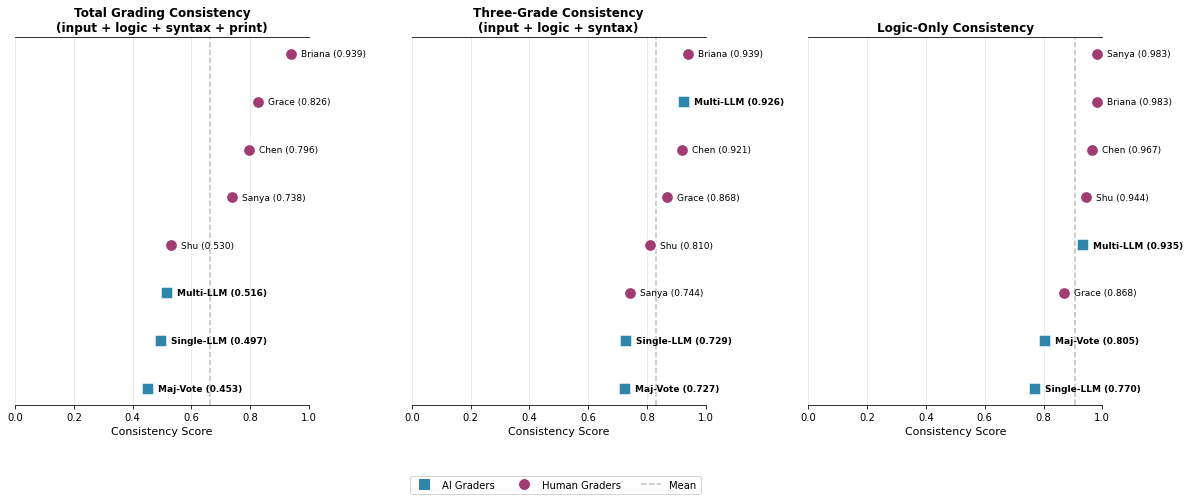


✅ Plot saved to results/analysis/consistency_scores.png


In [58]:
# Set up the figure with three subplots - wider to accommodate labels outside plot area
fig, axes = plt.subplots(1, 3, figsize=(20, 7))  # Increased height for 8 graders

# Colors
ai_color = '#2E86AB'      # Blue for AI
human_color = '#A23B72'   # Purple for humans

# Sort by consistency score for better visualization
results_sorted_total = results_df.sort_values('total_consistency', ascending=True)
results_sorted_three = results_df.sort_values('three_consistency', ascending=True)
results_sorted_logic = results_df.sort_values('logic_consistency', ascending=True)

# --- Plot 1: Total Grading Consistency ---
ax1 = axes[0]
y_positions = range(len(results_sorted_total))

for i, (_, row) in enumerate(results_sorted_total.iterrows()):
    color = ai_color if row['is_ai'] else human_color
    marker = 's' if row['is_ai'] else 'o'  # Square for AI, circle for human
    ax1.scatter(row['total_consistency'], i, c=color, s=150, marker=marker, 
                edgecolors='white', linewidths=1.5, zorder=3)
    # Add grader name label beside the dot (to the right), clip_on=False allows text outside axes
    ax1.annotate(f"{row['display_name']} ({row['total_consistency']:.3f})", 
                 xy=(row['total_consistency'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                 clip_on=False)

ax1.set_yticks([])  # Remove y-axis ticks since labels are beside dots
ax1.set_xlabel('Consistency Score', fontsize=11)
ax1.set_title('Total Grading Consistency\n(input + logic + syntax + print)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1)  # Standard 0-1 range for probability
ax1.axvline(x=results_df['total_consistency'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax1.grid(axis='x', alpha=0.3)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

# --- Plot 2: Three-Grade Consistency ---
ax2 = axes[1]

for i, (_, row) in enumerate(results_sorted_three.iterrows()):
    color = ai_color if row['is_ai'] else human_color
    marker = 's' if row['is_ai'] else 'o'
    ax2.scatter(row['three_consistency'], i, c=color, s=150, marker=marker,
                edgecolors='white', linewidths=1.5, zorder=3)
    ax2.annotate(f"{row['display_name']} ({row['three_consistency']:.3f})", 
                 xy=(row['three_consistency'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                 clip_on=False)

ax2.set_yticks([])
ax2.set_xlabel('Consistency Score', fontsize=11)
ax2.set_title('Three-Grade Consistency\n(input + logic + syntax)', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.axvline(x=results_df['three_consistency'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax2.grid(axis='x', alpha=0.3)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# --- Plot 3: Logic-Only Consistency ---
ax3 = axes[2]

for i, (_, row) in enumerate(results_sorted_logic.iterrows()):
    color = ai_color if row['is_ai'] else human_color
    marker = 's' if row['is_ai'] else 'o'
    ax3.scatter(row['logic_consistency'], i, c=color, s=150, marker=marker,
                edgecolors='white', linewidths=1.5, zorder=3)
    ax3.annotate(f"{row['display_name']} ({row['logic_consistency']:.3f})", 
                 xy=(row['logic_consistency'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                 clip_on=False)

ax3.set_yticks([])
ax3.set_xlabel('Consistency Score', fontsize=11)
ax3.set_title('Logic-Only Consistency', fontsize=12, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.axvline(x=results_df['logic_consistency'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax3.grid(axis='x', alpha=0.3)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='AI Graders'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
    Line2D([0], [0], color='gray', linestyle='--', alpha=0.5, label='Mean')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02))

# Adjust subplot spacing to leave room for annotations on the right
plt.subplots_adjust(bottom=0.15, right=0.88, wspace=0.35)
plt.savefig('results/analysis/consistency_scores.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/consistency_scores.png")


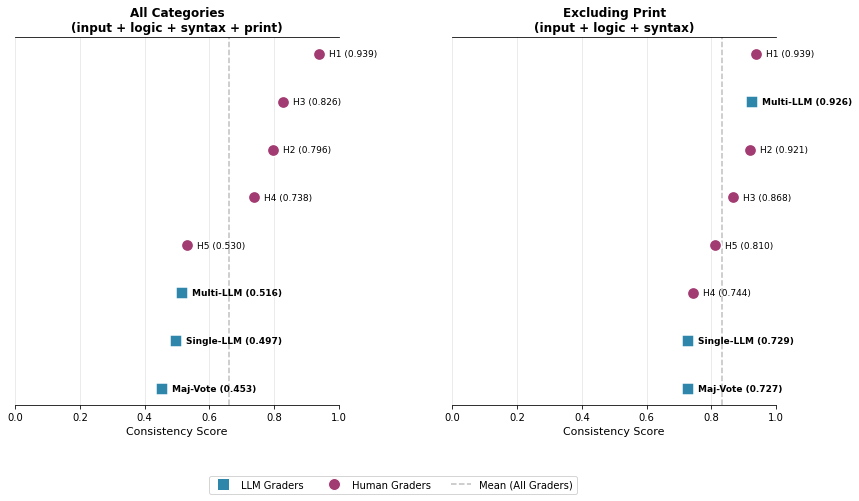


✅ Publication-ready plot saved to results/analysis/consistency_scores_pub.png


In [37]:
# PUBLICATION-READY: Consistency Scores Dot Plot
# Duplicate of original with: 1) Anonymized human names, 2) New subtitles, 3) Mean annotation

# Create anonymized display names
PUB_GRADER_NAMES = {
    'initial': 'Single-LLM',
    'final': 'Multi-LLM',
    'base': 'Maj-Vote',
    'briana': 'H1',
    'chen': 'H2',
    'grace': 'H3',
    'sanya': 'H4',
    'shu': 'H5',
}

# Create a copy with publication names (excluding dummy baseline)
pub_results_df = results_df[results_df['grader'] != 'dummy'].copy()
pub_results_df['pub_name'] = pub_results_df['grader'].map(PUB_GRADER_NAMES)

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Colors - same as original
ai_color = '#2E86AB'      # Blue for AI
human_color = '#A23B72'   # Purple for humans

# Sort by consistency score for better visualization
results_sorted_total = pub_results_df.sort_values('total_consistency', ascending=True)
results_sorted_three = pub_results_df.sort_values('three_consistency', ascending=True)

# --- Plot 1: All Categories ---
ax1 = axes[0]
for i, (_, row) in enumerate(results_sorted_total.iterrows()):
    color = ai_color if row['is_ai'] else human_color
    marker = 's' if row['is_ai'] else 'o'
    ax1.scatter(row['total_consistency'], i, c=color, s=150, marker=marker, 
                edgecolors='white', linewidths=1.5, zorder=3)
    ax1.annotate(f"{row['pub_name']} ({row['total_consistency']:.3f})", 
                 xy=(row['total_consistency'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                 clip_on=False)

ax1.set_yticks([])
ax1.set_xlabel('Consistency Score', fontsize=11)
ax1.set_title('All Categories\n(input + logic + syntax + print)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.axvline(x=pub_results_df['total_consistency'].mean(), color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='x', alpha=0.3)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

# --- Plot 2: Excluding Printing ---
ax2 = axes[1]
for i, (_, row) in enumerate(results_sorted_three.iterrows()):
    color = ai_color if row['is_ai'] else human_color
    marker = 's' if row['is_ai'] else 'o'
    ax2.scatter(row['three_consistency'], i, c=color, s=150, marker=marker,
                edgecolors='white', linewidths=1.5, zorder=3)
    ax2.annotate(f"{row['pub_name']} ({row['three_consistency']:.3f})", 
                 xy=(row['three_consistency'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                 clip_on=False)

ax2.set_yticks([])
ax2.set_xlabel('Consistency Score', fontsize=11)
ax2.set_title('Excluding Print\n(input + logic + syntax)', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.axvline(x=pub_results_df['three_consistency'].mean(), color='gray', linestyle='--', alpha=0.5)
ax2.grid(axis='x', alpha=0.3)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Add legend with mean annotation
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='LLM Graders'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
    Line2D([0], [0], color='gray', linestyle='--', alpha=0.5, label='Mean (All Graders)')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02))

# Adjust subplot spacing to leave room for annotations on the right
plt.subplots_adjust(bottom=0.15, right=0.88, wspace=0.35)
plt.savefig('results/analysis/consistency_scores_pub.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Publication-ready plot saved to results/analysis/consistency_scores_pub.png")

## 6. Combined Dot Plot


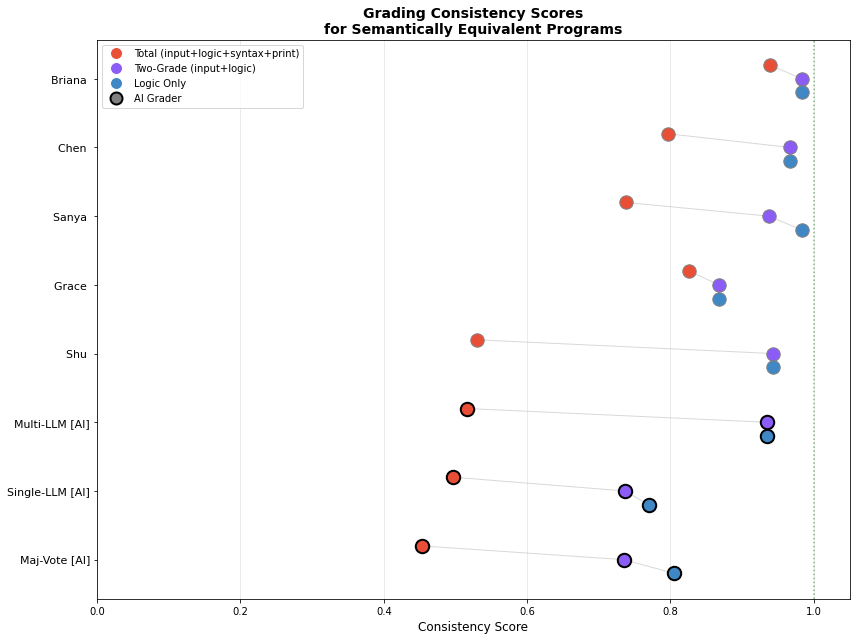


✅ Combined plot saved to results/analysis/consistency_scores_combined.png


In [ ]:
# Create a combined dot plot with all three metrics for each grader
fig, ax = plt.subplots(figsize=(12, 9))  # Increased height for 8 graders

# Sort by average of all three scores
results_df['avg_consistency'] = (results_df['total_consistency'] + results_df['three_consistency'] + results_df['logic_consistency']) / 3
results_sorted = results_df.sort_values('avg_consistency', ascending=True)

y_positions = np.arange(len(results_sorted))
offset = 0.2  # Offset for the three dots

# Colors for metrics
total_color = '#E94F37'  # Red-orange for total
three_color = '#8B5CF6'  # Purple for three-grade
logic_color = '#3F88C5'  # Blue for logic

for i, (_, row) in enumerate(results_sorted.iterrows()):
    # Marker based on AI/human
    edge_color = 'black' if row['is_ai'] else 'gray'
    edge_width = 2 if row['is_ai'] else 1
    
    # Total consistency (upper dot)
    ax.scatter(row['total_consistency'], i + offset, c=total_color, s=180, 
               marker='o', edgecolors=edge_color, linewidths=edge_width, zorder=3)
    
    # Three-grade consistency (middle dot)
    ax.scatter(row['three_consistency'], i, c=three_color, s=180,
               marker='o', edgecolors=edge_color, linewidths=edge_width, zorder=3)
    
    # Logic consistency (lower dot)
    ax.scatter(row['logic_consistency'], i - offset, c=logic_color, s=180,
               marker='o', edgecolors=edge_color, linewidths=edge_width, zorder=3)
    
    # Connect the dots with lines
    ax.plot([row['total_consistency'], row['three_consistency'], row['logic_consistency']], 
            [i + offset, i, i - offset], color='gray', alpha=0.3, linewidth=1, zorder=1)

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels([f"{row['display_name']} {'[AI]' if row['is_ai'] else ''}" 
                    for _, row in results_sorted.iterrows()], fontsize=11)
ax.set_xlabel('Consistency Score', fontsize=12)
ax.set_title('Grading Consistency Scores\nfor Semantically Equivalent Programs', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.05)
ax.grid(axis='x', alpha=0.3)

# Add vertical line at perfect consistency
ax.axvline(x=1.0, color='green', linestyle=':', alpha=0.5, label='Perfect Consistency')

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=total_color, markersize=12, 
           label='Total (input+logic+syntax+print)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=three_color, markersize=12, 
           label='Three-Grade (input+logic+syntax)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=logic_color, markersize=12, 
           label='Logic Only'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=12,
           markeredgecolor='black', markeredgewidth=2, label='AI Grader'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('results/analysis/consistency_scores_combined.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Combined plot saved to results/analysis/consistency_scores_combined.png")


## 7. Save Results


In [45]:
# Save results to CSV
results_df.to_csv('results/analysis/consistency_scores.csv', index=False)
print("✅ Results saved to results/analysis/consistency_scores.csv")

# Display final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nConsistency Score = P(same grade | equivalent programs)")
print(f"\nHigher score = more consistent grading for equivalent programs")
print(f"\nBest Total Consistency: {results_df.loc[results_df['total_consistency'].idxmax(), 'display_name']} ({results_df['total_consistency'].max():.3f})")
print(f"Best Two-Grade Consistency: {results_df.loc[results_df['two_consistency'].idxmax(), 'display_name']} ({results_df['two_consistency'].max():.3f})")
print(f"Best Logic Consistency: {results_df.loc[results_df['logic_consistency'].idxmax(), 'display_name']} ({results_df['logic_consistency'].max():.3f})")


✅ Results saved to results/analysis/consistency_scores.csv

FINAL SUMMARY

Consistency Score = P(same grade | equivalent programs)

Higher score = more consistent grading for equivalent programs

Best Total Consistency: Briana (0.939)
Best Two-Grade Consistency: Briana (0.983)
Best Logic Consistency: Briana (0.983)


## 8. Qualitative Error Analysis - Inconsistent Programs per Grader

For each **grader**, we:
1. Calculate the **reference grade** (majority vote) for each category within each cluster
2. Extract programs where that grader's score differs from their own reference in **any category**
3. Save results to individual CSV files per grader

This approach identifies which programs contribute to each grader's consistency score, enabling targeted qualitative analysis.

In [20]:
from statistics import mode, StatisticsError

def get_majority_grade(grades_list):
    """Get the majority (mode) grade from a list of grades."""
    if not grades_list:
        return None
    try:
        return mode(grades_list)
    except StatisticsError:
        # If no unique mode, use median
        return sorted(grades_list)[len(grades_list)//2]

def extract_inconsistent_programs_for_grader(grading_df, clusters_df, grader):
    """
    For a specific grader, extract programs where their grade differs from 
    their own reference (majority vote) in ANY category within each cluster.
    
    Returns a DataFrame with:
    - cluster_id
    - student_id
    - code
    - input, logic, syntax, print (grader's scores)
    - ref_input, ref_logic, ref_syntax, ref_print (reference scores)
    - inconsistent_categories (which categories differed)
    """
    inconsistent_records = []
    
    for _, cluster in clusters_df.iterrows():
        cluster_id = cluster['cluster_id']
        student_ids = cluster['student_ids_list']
        
        if len(student_ids) < 2:
            continue
        
        # Collect grades for this grader for all programs in cluster
        category_grades = {cat: [] for cat in CATEGORIES}  # {category: [grades]}
        program_data = {}  # student_id -> {category: grade, 'code': code}
        
        for sid in student_ids:
            row = grading_df[grading_df['student_id'] == sid]
            if len(row) == 0:
                continue
            row = row.iloc[0]
            program_data[sid] = {'code': row['code']}
            
            for cat in CATEGORIES:
                col = f"{grader}_{cat}"
                if col in row.index and pd.notna(row[col]):
                    grade = row[col]
                    program_data[sid][cat] = grade
                    category_grades[cat].append(grade)
        
        # Calculate reference grade for each category (majority vote for THIS grader)
        ref_grades = {}
        for cat in CATEGORIES:
            ref_grades[cat] = get_majority_grade(category_grades[cat])
        
        # Find programs where grader differs from their reference in any category
        for sid, data in program_data.items():
            inconsistent_cats = []
            for cat in CATEGORIES:
                if cat in data and ref_grades[cat] is not None:
                    if data[cat] != ref_grades[cat]:
                        inconsistent_cats.append(cat)
            
            # Only include if at least one category is inconsistent
            if inconsistent_cats:
                record = {
                    'cluster_id': cluster_id,
                    'student_id': sid,
                    'code': data['code'],
                    'input': data.get('input', None),
                    'logic': data.get('logic', None),
                    'syntax': data.get('syntax', None),
                    'print': data.get('print', None),
                    'ref_input': ref_grades.get('input', None),
                    'ref_logic': ref_grades.get('logic', None),
                    'ref_syntax': ref_grades.get('syntax', None),
                    'ref_print': ref_grades.get('print', None),
                    'inconsistent_categories': ', '.join(inconsistent_cats)
                }
                inconsistent_records.append(record)
    
    return pd.DataFrame(inconsistent_records)

# Extract inconsistent programs for each grader
grader_inconsistencies = {}
print("="*70)
print("EXTRACTING INCONSISTENT PROGRAMS PER GRADER")
print("="*70)

for grader in ALL_GRADERS:
    df = extract_inconsistent_programs_for_grader(grading_df, multi_program_clusters, grader)
    grader_inconsistencies[grader] = df
    print(f"{GRADER_NAMES[grader]:12s}: {len(df):3d} inconsistent programs")

EXTRACTING INCONSISTENT PROGRAMS PER GRADER
Single-LLM  :  30 inconsistent programs
Multi-LLM   :  24 inconsistent programs
Maj-Vote    :  29 inconsistent programs
Briana      :   3 inconsistent programs
Chen        :  10 inconsistent programs
Grace       :  12 inconsistent programs
Sanya       :   9 inconsistent programs
Shu         :  20 inconsistent programs
All-Zero    :   0 inconsistent programs


In [21]:
# Detailed breakdown by category for each grader
print("="*70)
print("INCONSISTENCY BREAKDOWN BY CATEGORY")
print("="*70)

for grader in ALL_GRADERS:
    df = grader_inconsistencies[grader]
    if len(df) == 0:
        print(f"\n{GRADER_NAMES[grader]}: No inconsistencies")
        continue
    
    # Count inconsistencies by category
    cat_counts = {cat: 0 for cat in CATEGORIES}
    for _, row in df.iterrows():
        for cat in row['inconsistent_categories'].split(', '):
            if cat in cat_counts:
                cat_counts[cat] += 1
    
    print(f"\n{GRADER_NAMES[grader]} ({len(df)} programs with inconsistencies):")
    for cat, count in cat_counts.items():
        if count > 0:
            print(f"  - {cat}: {count} programs")

INCONSISTENCY BREAKDOWN BY CATEGORY

Single-LLM (30 programs with inconsistencies):
  - input: 2 programs
  - logic: 8 programs
  - syntax: 2 programs
  - print: 24 programs

Multi-LLM (24 programs with inconsistencies):
  - input: 1 programs
  - logic: 5 programs
  - syntax: 1 programs
  - print: 23 programs

Maj-Vote (29 programs with inconsistencies):
  - input: 4 programs
  - logic: 7 programs
  - syntax: 2 programs
  - print: 25 programs

Briana (3 programs with inconsistencies):
  - input: 1 programs
  - logic: 2 programs
  - syntax: 3 programs
  - print: 1 programs

Chen (10 programs with inconsistencies):
  - input: 1 programs
  - logic: 5 programs
  - syntax: 1 programs
  - print: 6 programs

Grace (12 programs with inconsistencies):
  - input: 1 programs
  - logic: 10 programs
  - syntax: 1 programs
  - print: 3 programs

Sanya (9 programs with inconsistencies):
  - input: 2 programs
  - logic: 2 programs
  - syntax: 8 programs
  - print: 2 programs

Shu (20 programs with inc

In [22]:
# Show sample of inconsistent programs for AI graders (most interesting)
print("="*70)
print("SAMPLE INCONSISTENT PROGRAMS - AI GRADERS")
print("="*70)

for grader in AI_GRADERS:
    df = grader_inconsistencies[grader]
    if len(df) == 0:
        continue
    
    print(f"\n{'='*70}")
    print(f"{GRADER_NAMES[grader]} - First 3 Inconsistent Programs")
    print(f"{'='*70}")
    
    for idx, (_, row) in enumerate(df.head(3).iterrows()):
        print(f"\n📝 [{idx+1}] Cluster {row['cluster_id']}, Student: {row['student_id']}")
        print(f"   Inconsistent categories: {row['inconsistent_categories']}")
        print(f"   Grades:  input={row['input']} (ref={row['ref_input']}), "
              f"logic={row['logic']} (ref={row['ref_logic']}), "
              f"syntax={row['syntax']} (ref={row['ref_syntax']}), "
              f"print={row['print']} (ref={row['ref_print']})")
        
        # Show first 200 chars of code as preview
        code_preview = row['code'][:200].replace('\n', ' ') + "..."
        print(f"   Code preview: {code_preview}")

SAMPLE INCONSISTENT PROGRAMS - AI GRADERS

Single-LLM - First 3 Inconsistent Programs

📝 [1] Cluster 1, Student: z7YmEH6s4Hag7flPAvJ1xQoCB5H2
   Inconsistent categories: print
   Grades:  input=0 (ref=0), logic=0 (ref=0), syntax=0 (ref=0), print=1 (ref=0)
   Code preview: def main(): #First, we are gonna ask the user their heights in meters.     height_str=input("Enter your height in meters")     height=float(height_str)      if height > 1.6 and height < 1.9:         p...

📝 [2] Cluster 1, Student: bvYuTX2QtIf5PM1Wrbuk20wPVko1
   Inconsistent categories: logic
   Grades:  input=0 (ref=0), logic=1 (ref=0), syntax=0 (ref=0), print=0 (ref=0)
   Code preview: def main():     # TODO write your solution here     h=float(input("Enter your height in meters: "))     if h>1.6 and h<1.9:         print("Correct height to be an astronaut")     if h<=1.6:         pr...

📝 [3] Cluster 1, Student: asf1t44qDJQ2yBQxAvpnYO9OrDy2
   Inconsistent categories: print
   Grades:  input=0 (ref=0), logic=0 (ref=

In [49]:
# Save inconsistent programs to individual CSV files per grader
import os

# Create output directory if needed
output_dir = 'results/analysis/inconsistent_programs'
os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("SAVING INCONSISTENT PROGRAMS TO CSV FILES")
print("="*70)

# Define columns for output
output_columns = ['cluster_id', 'student_id', 'code', 'input', 'logic', 'syntax', 'print',
                  'ref_input', 'ref_logic', 'ref_syntax', 'ref_print', 'inconsistent_categories']

for grader in ALL_GRADERS:
    df = grader_inconsistencies[grader]
    
    # Use grader key for filename
    filename = f"{output_dir}/{grader}_inconsistent.csv"
    
    if len(df) > 0:
        df[output_columns].to_csv(filename, index=False)
        print(f"✅ {GRADER_NAMES[grader]:12s}: Saved {len(df):3d} programs to {filename}")
    else:
        # Create empty file with headers
        pd.DataFrame(columns=output_columns).to_csv(filename, index=False)
        print(f"✅ {GRADER_NAMES[grader]:12s}: No inconsistencies (empty file created)")

print(f"\n📁 All files saved to: {output_dir}/")

SAVING INCONSISTENT PROGRAMS TO CSV FILES
✅ Single-LLM  : Saved  30 programs to results/analysis/inconsistent_programs/initial_inconsistent.csv
✅ Multi-LLM   : Saved  24 programs to results/analysis/inconsistent_programs/final_inconsistent.csv
✅ Maj-Vote    : Saved  29 programs to results/analysis/inconsistent_programs/base_inconsistent.csv
✅ Briana      : Saved   3 programs to results/analysis/inconsistent_programs/briana_inconsistent.csv
✅ Chen        : Saved  10 programs to results/analysis/inconsistent_programs/chen_inconsistent.csv
✅ Grace       : Saved  12 programs to results/analysis/inconsistent_programs/grace_inconsistent.csv
✅ Sanya       : Saved   9 programs to results/analysis/inconsistent_programs/sanya_inconsistent.csv
✅ Shu         : Saved  20 programs to results/analysis/inconsistent_programs/shu_inconsistent.csv

📁 All files saved to: results/analysis/inconsistent_programs/


In [50]:
# Summary of qualitative error analysis
print("="*70)
print("QUALITATIVE ERROR ANALYSIS SUMMARY")
print("="*70)

print("\nFor each grader, we extracted programs where their score differs from")
print("their own majority vote (reference) within each semantic cluster.")
print("\nThis identifies the exact programs that contribute to inconsistency,")
print("enabling targeted qualitative review.")

print("\n" + "-"*70)
print("GRADER INCONSISTENCY SUMMARY")
print("-"*70)
print(f"\n{'Grader':<15} {'Programs':<12} {'Type':<8} {'Consistency Score'}")
print("-"*55)

for grader in ALL_GRADERS:
    count = len(grader_inconsistencies[grader])
    grader_type = "AI" if grader in AI_GRADERS else "Human"
    consistency = results_df[results_df['grader'] == grader]['total_consistency'].values[0]
    print(f"{GRADER_NAMES[grader]:<15} {count:<12} {grader_type:<8} {consistency:.3f}")

# Total by type
ai_count = sum(len(grader_inconsistencies[g]) for g in AI_GRADERS)
human_count = sum(len(grader_inconsistencies[g]) for g in HUMAN_GRADERS)
print(f"\nTotal AI grader inconsistent programs: {ai_count}")
print(f"Total Human grader inconsistent programs: {human_count}")

QUALITATIVE ERROR ANALYSIS SUMMARY

For each grader, we extracted programs where their score differs from
their own majority vote (reference) within each semantic cluster.

This identifies the exact programs that contribute to inconsistency,
enabling targeted qualitative review.

----------------------------------------------------------------------
GRADER INCONSISTENCY SUMMARY
----------------------------------------------------------------------

Grader          Programs     Type     Consistency Score
-------------------------------------------------------
Single-LLM      30           AI       0.497
Multi-LLM       24           AI       0.516
Maj-Vote        29           AI       0.453
Briana          3            Human    0.939
Chen            10           Human    0.796
Grace           12           Human    0.826
Sanya           9            Human    0.738
Shu             20           Human    0.530

Total AI grader inconsistent programs: 83
Total Human grader inconsistent programs

## 9. Consistency-Accuracy Analysis

This section combines consistency with accuracy to create more robust evaluation metrics.

**Problem**: High consistency alone doesn't mean correct grading - a grader could give all programs the same (wrong) score and still achieve perfect consistency.

**Solution**: We use reference grades (derived from cluster-level consensus) to measure accuracy, then combine with consistency.

### Metrics:
1. **Accuracy**: P(grade == reference grade) for individual programs
2. **Correct & Consistent (C&C)**: For pairs of equivalent programs, count only when gradeA == gradeB == gradeRef
3. **Harmonic Mean (CA)**: 2 × consistency × accuracy / (consistency + accuracy)

In [23]:
# Load reference grades
ref_df = pd.read_csv('results/analysis/cdg_cluster_batch1_ref.csv')
print(f"Loaded {len(ref_df)} clusters with reference grades")
print(f"Columns: {ref_df.columns.tolist()}")

# Filter to clusters with reference grades (size > 1)
ref_df_valid = ref_df[ref_df['size'] > 1].copy()
print(f"\nClusters with valid reference grades (size > 1): {len(ref_df_valid)}")

# Parse student_ids
ref_df_valid['student_ids_list'] = ref_df_valid['student_ids'].apply(parse_student_ids)

# Create a lookup: student_id -> reference grades
student_to_ref = {}
for _, row in ref_df_valid.iterrows():
    ref_grades = {
        'input': row['ref_input'],
        'logic': row['ref_logic'],
        'syntax': row['ref_syntax'],
        'print': row['ref_print']
    }
    for sid in row['student_ids_list']:
        student_to_ref[sid] = ref_grades

print(f"Total programs with reference grades: {len(student_to_ref)}")
print(f"\nSample reference grades:")
for i, (sid, ref) in enumerate(list(student_to_ref.items())[:3]):
    print(f"  {sid[:20]}...: input={ref['input']}, logic={ref['logic']}, syntax={ref['syntax']}, print={ref['print']}")

Loaded 34 clusters with reference grades
Columns: ['Unnamed: 0', 'cluster_id', 'size', 'ref_input', 'ref_logic', 'ref_print', 'ref_syntax', 'student_ids']

Clusters with valid reference grades (size > 1): 10
Total programs with reference grades: 73

Sample reference grades:
  3Q7yfPTmBwY24XotEUDS...: input=0.0, logic=0.0, syntax=0.0, print=0.0
  euiprXnBDsModVmfCfYn...: input=0.0, logic=0.0, syntax=0.0, print=0.0
  z7YmEH6s4Hag7flPAvJ1...: input=0.0, logic=0.0, syntax=0.0, print=0.0


In [24]:
def calculate_accuracy(grading_df, student_to_ref, grader, grade_func, ref_grade_func):
    """
    Calculate accuracy for a grader.
    
    Accuracy = (number of correct grades) / (total grades)
    
    A grade is correct if it matches the reference grade.
    
    Args:
        grading_df: DataFrame with grading data
        student_to_ref: Dict mapping student_id to reference grades
        grader: Grader name (e.g., 'initial', 'briana')
        grade_func: Function to extract grade from row (e.g., get_total_grade)
        ref_grade_func: Function to calculate reference grade from ref dict
        
    Returns:
        Tuple of (accuracy, correct_count, total_count)
    """
    correct = 0
    total = 0
    
    for _, row in grading_df.iterrows():
        sid = row['student_id']
        if sid not in student_to_ref:
            continue
        
        grade = grade_func(row, grader)
        ref_grades = student_to_ref[sid]
        ref_grade = ref_grade_func(ref_grades)
        
        if grade is not None and ref_grade is not None:
            total += 1
            if grade == ref_grade:
                correct += 1
    
    if total == 0:
        return 0.0, 0, 0
    return correct / total, correct, total


def get_total_ref(ref_dict):
    """Calculate total reference grade from ref dict."""
    total = 0
    for cat in CATEGORIES:
        val = ref_dict.get(cat)
        if pd.notna(val):
            total += val
        else:
            return None
    return total

def get_three_ref(ref_dict):
    """Calculate three-grade (input+logic+syntax) reference from ref dict."""
    total = 0
    for cat in ['input', 'logic', 'syntax']:
        val = ref_dict.get(cat)
        if pd.notna(val):
            total += val
        else:
            return None
    return total

def get_logic_ref(ref_dict):
    """Get logic reference grade from ref dict."""
    val = ref_dict.get('logic')
    return val if pd.notna(val) else None


def calculate_correct_and_consistent(grading_df, clusters_df, student_to_ref, grader, grade_func, ref_grade_func):
    """
    Calculate "correct and consistent" metric.
    
    For pairs of equivalent programs, count only when gradeA == gradeB == gradeRef.
    
    Returns:
        Tuple of (c_and_c_rate, correct_consistent_pairs, total_pairs)
    """
    correct_consistent_pairs = 0
    total_pairs = 0
    
    for _, cluster in clusters_df.iterrows():
        student_ids = cluster['student_ids_list']
        if len(student_ids) < 2:
            continue
        
        # Get grades and reference for all students in this cluster
        grades_info = []
        for sid in student_ids:
            if sid not in student_to_ref:
                continue
            row = grading_df[grading_df['student_id'] == sid]
            if len(row) > 0:
                grade = grade_func(row.iloc[0], grader)
                ref_grade = ref_grade_func(student_to_ref[sid])
                if grade is not None and ref_grade is not None:
                    grades_info.append({'sid': sid, 'grade': grade, 'ref': ref_grade})
        
        # Count pairs where gradeA == gradeB == ref
        for (info1, info2) in combinations(grades_info, 2):
            total_pairs += 1
            # All three must be equal (gradeA, gradeB, and ref)
            if info1['grade'] == info2['grade'] == info1['ref']:
                correct_consistent_pairs += 1
    
    if total_pairs == 0:
        return 0.0, 0, 0
    return correct_consistent_pairs / total_pairs, correct_consistent_pairs, total_pairs


def harmonic_mean(a, b):
    """Calculate harmonic mean of two values."""
    if a + b == 0:
        return 0.0
    return 2 * a * b / (a + b)


def calculate_ordinal_accuracy(grading_df, clusters_df, student_to_ref, grader, grade_func, ref_grade_func):
    """
    Calculate ordinal accuracy for a grader.
    
    Ordinal Accuracy = P(gradeA > gradeB | refA > refB)
    
    This measures whether the grader preserves the ordering of programs.
    If program A should have a higher (worse) grade than program B,
    does the grader assign A a higher grade than B?
    
    Note: Higher grade = worse (0 is best, 2 is worst)
    
    Returns:
        Tuple of (ordinal_accuracy, correct_orderings, total_orderings)
    """
    correct_orderings = 0
    total_orderings = 0
    
    # Compare all pairs of programs across clusters
    all_programs = []
    for _, cluster in clusters_df.iterrows():
        for sid in cluster['student_ids_list']:
            if sid not in student_to_ref:
                continue
            row = grading_df[grading_df['student_id'] == sid]
            if len(row) > 0:
                grade = grade_func(row.iloc[0], grader)
                ref_grade = ref_grade_func(student_to_ref[sid])
                if grade is not None and ref_grade is not None:
                    all_programs.append({'sid': sid, 'grade': grade, 'ref': ref_grade})
    
    # Compare all pairs where refA > refB (i.e., A is worse than B)
    for i, prog_a in enumerate(all_programs):
        for prog_b in all_programs[i+1:]:
            # Only count pairs where reference grades are different
            if prog_a['ref'] > prog_b['ref']:
                # A should be graded worse than B
                total_orderings += 1
                if prog_a['grade'] > prog_b['grade']:
                    correct_orderings += 1
            elif prog_b['ref'] > prog_a['ref']:
                # B should be graded worse than A
                total_orderings += 1
                if prog_b['grade'] > prog_a['grade']:
                    correct_orderings += 1
    
    if total_orderings == 0:
        return 0.0, 0, 0
    return correct_orderings / total_orderings, correct_orderings, total_orderings


print("✅ Functions defined: calculate_accuracy, calculate_correct_and_consistent, harmonic_mean, calculate_ordinal_accuracy")

✅ Functions defined: calculate_accuracy, calculate_correct_and_consistent, harmonic_mean, calculate_ordinal_accuracy


In [25]:
# Calculate all consistency-accuracy metrics for each grader
ca_results = []

print("="*80)
print("CALCULATING CONSISTENCY-ACCURACY METRICS")
print("="*80)

for grader in ALL_GRADERS:
    print(f"\nProcessing {GRADER_NAMES[grader]}...")
    
    # Get consistency scores from earlier calculation
    consistency_total = results_df[results_df['grader'] == grader]['total_consistency'].values[0]
    consistency_three = results_df[results_df['grader'] == grader]['three_consistency'].values[0]
    consistency_logic = results_df[results_df['grader'] == grader]['logic_consistency'].values[0]
    
    # Calculate accuracy for different grade types
    acc_total, _, _ = calculate_accuracy(grading_df, student_to_ref, grader, get_total_grade, get_total_ref)
    acc_three, _, _ = calculate_accuracy(grading_df, student_to_ref, grader, get_three_grade, get_three_ref)
    acc_logic, _, _ = calculate_accuracy(grading_df, student_to_ref, grader, get_logic_grade, get_logic_ref)
    
    # Calculate correct-and-consistent for different grade types
    cc_total, _, _ = calculate_correct_and_consistent(grading_df, multi_program_clusters, student_to_ref, 
                                                        grader, get_total_grade, get_total_ref)
    cc_three, _, _ = calculate_correct_and_consistent(grading_df, multi_program_clusters, student_to_ref, 
                                                        grader, get_three_grade, get_three_ref)
    cc_logic, _, _ = calculate_correct_and_consistent(grading_df, multi_program_clusters, student_to_ref, 
                                                        grader, get_logic_grade, get_logic_ref)
    
    # Calculate harmonic means
    hm_total = harmonic_mean(consistency_total, acc_total)
    hm_three = harmonic_mean(consistency_three, acc_three)
    hm_logic = harmonic_mean(consistency_logic, acc_logic)
    
    # Calculate ordinal accuracy for different grade types
    ord_acc_total, _, ord_total_pairs = calculate_ordinal_accuracy(grading_df, multi_program_clusters, student_to_ref, 
                                                                    grader, get_total_grade, get_total_ref)
    ord_acc_three, _, _ = calculate_ordinal_accuracy(grading_df, multi_program_clusters, student_to_ref, 
                                                      grader, get_three_grade, get_three_ref)
    ord_acc_logic, _, _ = calculate_ordinal_accuracy(grading_df, multi_program_clusters, student_to_ref, 
                                                      grader, get_logic_grade, get_logic_ref)
    
    ca_results.append({
        'grader': grader,
        'display_name': GRADER_NAMES[grader],
        'is_ai': grader in AI_GRADERS,
        # Total grade metrics
        'consistency_total': consistency_total,
        'accuracy_total': acc_total,
        'ordinal_accuracy_total': ord_acc_total,
        'correct_consistent_total': cc_total,
        'harmonic_mean_total': hm_total,
        # Three-grade metrics
        'consistency_three': consistency_three,
        'accuracy_three': acc_three,
        'ordinal_accuracy_three': ord_acc_three,
        'correct_consistent_three': cc_three,
        'harmonic_mean_three': hm_three,
        # Logic-only metrics  
        'consistency_logic': consistency_logic,
        'accuracy_logic': acc_logic,
        'ordinal_accuracy_logic': ord_acc_logic,
        'correct_consistent_logic': cc_logic,
        'harmonic_mean_logic': hm_logic,
    })

ca_df = pd.DataFrame(ca_results)
print(f"\n✅ Consistency-Accuracy metrics calculated for all graders")
print(f"   Ordinal accuracy based on {ord_total_pairs} cross-cluster pairs with different reference grades")

CALCULATING CONSISTENCY-ACCURACY METRICS

Processing Single-LLM...

Processing Multi-LLM...

Processing Maj-Vote...

Processing Briana...

Processing Chen...

Processing Grace...

Processing Sanya...

Processing Shu...

Processing All-Zero...

✅ Consistency-Accuracy metrics calculated for all graders
   Ordinal accuracy based on 1559 cross-cluster pairs with different reference grades


In [26]:
# Display results in a formatted table
print("="*110)
print("CONSISTENCY-ACCURACY RESULTS - TOTAL GRADE")
print("="*110)
print(f"\n{'Grader':<12} {'Consistency':>12} {'Accuracy':>12} {'Ord.Acc':>12} {'C&C':>12} {'Harmonic':>12} {'Type':<8}")
print("-"*85)

for _, row in ca_df.sort_values('harmonic_mean_total', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else ("BASE" if row['grader'] == 'dummy' else "Human")
    print(f"{row['display_name']:<12} {row['consistency_total']:>12.3f} {row['accuracy_total']:>12.3f} "
          f"{row['ordinal_accuracy_total']:>12.3f} {row['correct_consistent_total']:>12.3f} {row['harmonic_mean_total']:>12.3f} {grader_type:<8}")

print("\n" + "="*110)
print("CONSISTENCY-ACCURACY RESULTS - THREE-GRADE (input + logic + syntax)")
print("="*110)
print(f"\n{'Grader':<12} {'Consistency':>12} {'Accuracy':>12} {'Ord.Acc':>12} {'C&C':>12} {'Harmonic':>12} {'Type':<8}")
print("-"*85)

for _, row in ca_df.sort_values('harmonic_mean_three', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else ("BASE" if row['grader'] == 'dummy' else "Human")
    print(f"{row['display_name']:<12} {row['consistency_three']:>12.3f} {row['accuracy_three']:>12.3f} "
          f"{row['ordinal_accuracy_three']:>12.3f} {row['correct_consistent_three']:>12.3f} {row['harmonic_mean_three']:>12.3f} {grader_type:<8}")

print("\n" + "="*110)
print("CONSISTENCY-ACCURACY RESULTS - LOGIC ONLY")
print("="*110)
print(f"\n{'Grader':<12} {'Consistency':>12} {'Accuracy':>12} {'Ord.Acc':>12} {'C&C':>12} {'Harmonic':>12} {'Type':<8}")
print("-"*85)

for _, row in ca_df.sort_values('harmonic_mean_logic', ascending=False).iterrows():
    grader_type = "AI" if row['is_ai'] else ("BASE" if row['grader'] == 'dummy' else "Human")
    print(f"{row['display_name']:<12} {row['consistency_logic']:>12.3f} {row['accuracy_logic']:>12.3f} "
          f"{row['ordinal_accuracy_logic']:>12.3f} {row['correct_consistent_logic']:>12.3f} {row['harmonic_mean_logic']:>12.3f} {grader_type:<8}")

print("\n" + "-"*85)
print("Legend:")
print("  Consistency: P(gradeA == gradeB) for equivalent program pairs")
print("  Accuracy: P(grade == reference) for individual programs")
print("  Ord.Acc: P(gradeA > gradeB | refA > refB) - ordinal accuracy across clusters")
print("  C&C: P(gradeA == gradeB == reference) for equivalent program pairs")
print("  Harmonic: 2 × Consistency × Accuracy / (Consistency + Accuracy)")

CONSISTENCY-ACCURACY RESULTS - TOTAL GRADE

Grader        Consistency     Accuracy      Ord.Acc          C&C     Harmonic Type    
-------------------------------------------------------------------------------------
Briana              0.939        0.699        0.744        0.818        0.801 Human   
Sanya               0.738        0.767        0.953        0.718        0.752 Human   
Grace               0.826        0.671        0.826        0.736        0.741 Human   
All-Zero            1.000        0.562        0.000        0.855        0.719 BASE    
Chen                0.796        0.603        0.923        0.684        0.686 Human   
Shu                 0.530        0.712        0.827        0.392        0.608 Human   
Multi-LLM           0.516        0.658        0.818        0.398        0.578 AI      
Single-LLM          0.497        0.562        0.756        0.251        0.527 AI      
Maj-Vote            0.453        0.562        0.770        0.271        0.502 AI      


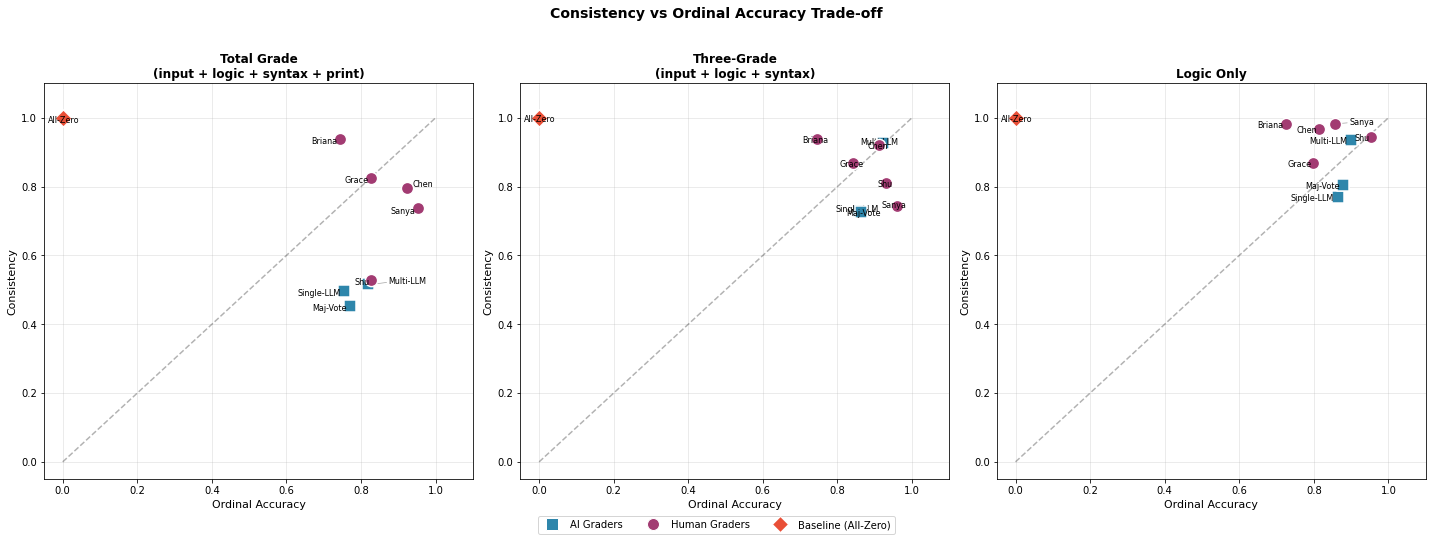


✅ Plot saved to results/analysis/consistency_vs_accuracy.png


In [27]:
# Visualization: Scatter plot of Consistency vs Accuracy
# Use adjustText library if available, otherwise use manual offsets
try:
    from adjustText import adjust_text
    USE_ADJUST_TEXT = True
except ImportError:
    USE_ADJUST_TEXT = False
    print("Note: Install adjustText for better label positioning: pip install adjustText")

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Colors
ai_color = '#2E86AB'      # Blue for AI
human_color = '#A23B72'   # Purple for humans
baseline_color = '#E94F37' # Red for baseline

def get_color(row):
    if row['grader'] == 'dummy':
        return baseline_color
    return ai_color if row['is_ai'] else human_color

def get_marker(row):
    if row['grader'] == 'dummy':
        return 'D'  # Diamond for baseline
    return 's' if row['is_ai'] else 'o'

# --- Plot 1: Total Grade ---
ax1 = axes[0]
texts1 = []
for _, row in ca_df.iterrows():
    color = get_color(row)
    marker = get_marker(row)
    ax1.scatter(row['ordinal_accuracy_total'], row['consistency_total'], c=color, s=150, 
                marker=marker, edgecolors='white', linewidths=1.5, zorder=3)
    texts1.append(ax1.text(row['ordinal_accuracy_total'], row['consistency_total'], row['display_name'], fontsize=8))

if USE_ADJUST_TEXT:
    adjust_text(texts1, ax=ax1, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax1.set_xlabel('Ordinal Accuracy', fontsize=11)
ax1.set_ylabel('Consistency', fontsize=11)
ax1.set_title('Total Grade\n(input + logic + syntax + print)', fontsize=12, fontweight='bold')
ax1.set_xlim(-0.05, 1.1)
ax1.set_ylim(-0.05, 1.1)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
ax1.grid(alpha=0.3)

# --- Plot 2: Three-Grade ---
ax2 = axes[1]
texts2 = []
for _, row in ca_df.iterrows():
    color = get_color(row)
    marker = get_marker(row)
    ax2.scatter(row['ordinal_accuracy_three'], row['consistency_three'], c=color, s=150, 
                marker=marker, edgecolors='white', linewidths=1.5, zorder=3)
    texts2.append(ax2.text(row['ordinal_accuracy_three'], row['consistency_three'], row['display_name'], fontsize=8))

if USE_ADJUST_TEXT:
    adjust_text(texts2, ax=ax2, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax2.set_xlabel('Ordinal Accuracy', fontsize=11)
ax2.set_ylabel('Consistency', fontsize=11)
ax2.set_title('Three-Grade\n(input + logic + syntax)', fontsize=12, fontweight='bold')
ax2.set_xlim(-0.05, 1.1)
ax2.set_ylim(-0.05, 1.1)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
ax2.grid(alpha=0.3)

# --- Plot 3: Logic Only ---
ax3 = axes[2]
texts3 = []
for _, row in ca_df.iterrows():
    color = get_color(row)
    marker = get_marker(row)
    ax3.scatter(row['ordinal_accuracy_logic'], row['consistency_logic'], c=color, s=150, 
                marker=marker, edgecolors='white', linewidths=1.5, zorder=3)
    texts3.append(ax3.text(row['ordinal_accuracy_logic'], row['consistency_logic'], row['display_name'], fontsize=8))

if USE_ADJUST_TEXT:
    adjust_text(texts3, ax=ax3, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax3.set_xlabel('Ordinal Accuracy', fontsize=11)
ax3.set_ylabel('Consistency', fontsize=11)
ax3.set_title('Logic Only', fontsize=12, fontweight='bold')
ax3.set_xlim(-0.05, 1.1)
ax3.set_ylim(-0.05, 1.1)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
ax3.grid(alpha=0.3)

# Add legend with baseline
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='AI Graders'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=baseline_color, markersize=12, label='Baseline (All-Zero)'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Consistency vs Ordinal Accuracy Trade-off', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('results/analysis/consistency_vs_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/consistency_vs_accuracy.png")

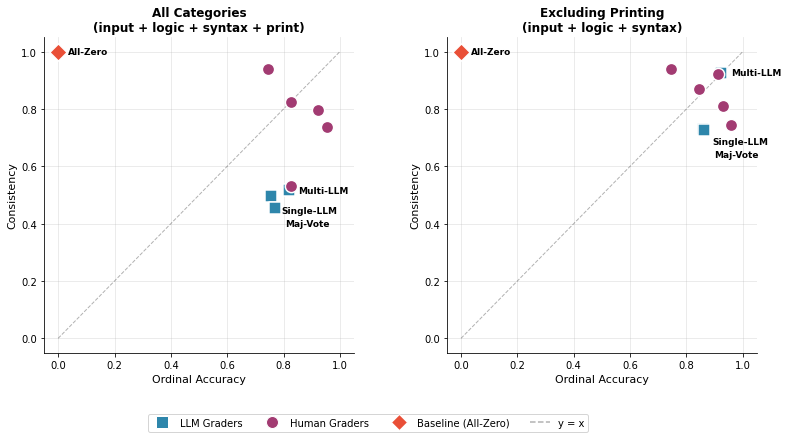


✅ Publication-ready plot saved to results/analysis/consistency_vs_accuracy_pub.png


In [38]:
# PUBLICATION-READY: Consistency vs Accuracy Scatter Plot
# Changes: 1) Anonymized human graders (H1-H5), 2) Labels to the right of dots, 3) Cleaner design

# Check if ca_df exists (requires running earlier cells in Section 9)
if 'ca_df' not in dir():
    raise NameError("ca_df not found. Please run the cells in Section 9 (Consistency-Accuracy Analysis) first.")

# Anonymized display names
PUB_NAMES = {
    'initial': 'Single-LLM',
    'final': 'Multi-LLM',
    'base': 'Maj-Vote',
    'briana': 'H1',
    'chen': 'H2',
    'grace': 'H3',
    'sanya': 'H4',
    'shu': 'H5',
    'dummy': 'All-Zero'
}

# Create a copy with publication names
pub_ca_df = ca_df.copy()
pub_ca_df['pub_name'] = pub_ca_df['grader'].map(PUB_NAMES)

# Include all graders (with dummy baseline)
plot_ca_df = pub_ca_df.copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Colors
ai_color = '#2E86AB'      # Blue for AI
human_color = '#A23B72'   # Purple for humans
baseline_color = '#E94F37' # Red for baseline

def get_color_pub(row):
    if row['grader'] == 'dummy':
        return baseline_color
    return ai_color if row['is_ai'] else human_color

def get_marker_pub(row):
    if row['grader'] == 'dummy':
        return 'D'  # Diamond for baseline
    return 's' if row['is_ai'] else 'o'

# --- Plot 1: All Categories ---
ax1 = axes[0]
for _, row in plot_ca_df.iterrows():
    color = get_color_pub(row)
    marker = get_marker_pub(row)
    ax1.scatter(row['ordinal_accuracy_total'], row['consistency_total'], c=color, s=150, 
                marker=marker, edgecolors='white', linewidths=1.5, zorder=3)
    # Only label AI graders and baseline (not human graders)
    if row['is_ai'] or row['grader'] == 'dummy':
        # Custom y offsets for specific graders
        if row['grader'] == 'initial':  # Single-LLM
            y_offset = -15
        elif row['grader'] == 'base':  # Maj-Vote
            y_offset = -15
        else:
            y_offset = 0
        ax1.annotate(row['pub_name'], 
                     xy=(row['ordinal_accuracy_total'], row['consistency_total']),
                     xytext=(10, y_offset), textcoords='offset points',
                     fontsize=9, va='center', fontweight='bold')

ax1.set_xlabel('Ordinal Accuracy', fontsize=11)
ax1.set_ylabel('Consistency', fontsize=11)
ax1.set_title('All Categories\n(input + logic + syntax + print)', fontsize=12, fontweight='bold')
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
ax1.grid(alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# --- Plot 2: Excluding Printing ---
ax2 = axes[1]
for _, row in plot_ca_df.iterrows():
    color = get_color_pub(row)
    marker = get_marker_pub(row)
    ax2.scatter(row['ordinal_accuracy_three'], row['consistency_three'], c=color, s=150, 
                marker=marker, edgecolors='white', linewidths=1.5, zorder=3)
    # Only label AI graders and baseline (not human graders)
    if row['is_ai'] or row['grader'] == 'dummy':
        # Custom y offsets - Single-LLM and Maj-Vote at distinct levels
        if row['grader'] == 'initial':  # Single-LLM
            y_offset = -12
        elif row['grader'] == 'base':  # Maj-Vote
            y_offset = -25
        else:
            y_offset = 0
        ax2.annotate(row['pub_name'], 
                     xy=(row['ordinal_accuracy_three'], row['consistency_three']),
                     xytext=(10, y_offset), textcoords='offset points',
                     fontsize=9, va='center', fontweight='bold')

ax2.set_xlabel('Ordinal Accuracy', fontsize=11)
ax2.set_ylabel('Consistency', fontsize=11)
ax2.set_title('Excluding Printing\n(input + logic + syntax)', fontsize=12, fontweight='bold')
ax2.set_xlim(-0.05, 1.05)
ax2.set_ylim(-0.05, 1.05)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
ax2.grid(alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='LLM Graders'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=baseline_color, markersize=12, label='Baseline (All-Zero)'),
    Line2D([0], [0], color='k', linestyle='--', alpha=0.3, label='y = x')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.02))

plt.subplots_adjust(bottom=0.15, right=0.95, wspace=0.3)
plt.savefig('results/analysis/consistency_vs_accuracy_pub.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Publication-ready plot saved to results/analysis/consistency_vs_accuracy_pub.png")

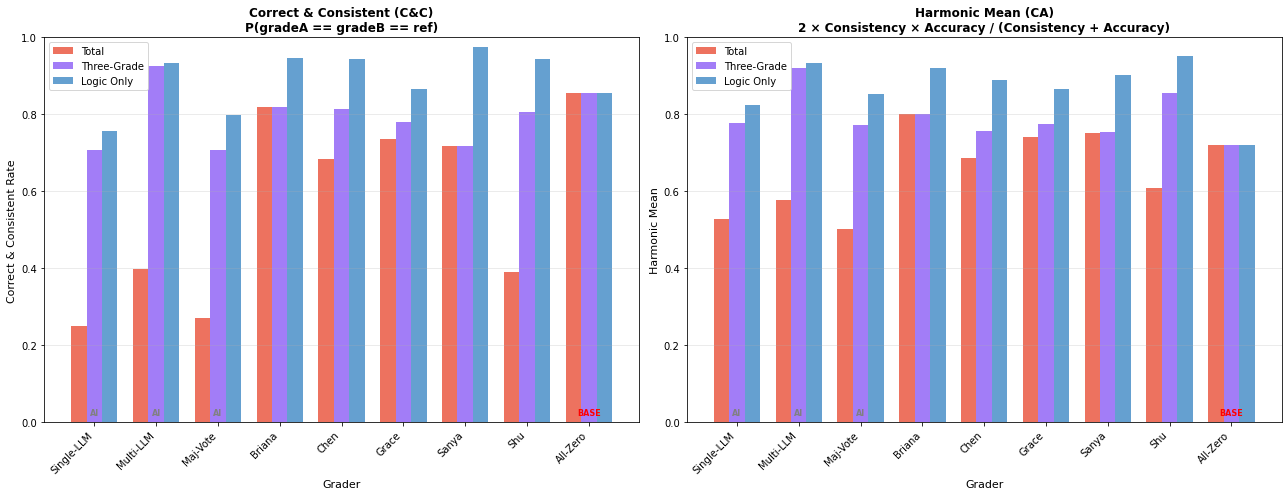


✅ Plot saved to results/analysis/combined_metrics.png


In [ ]:
# Visualization: Bar chart comparing combined metrics
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Prepare data
graders = ca_df['display_name'].tolist()
x = np.arange(len(graders))
width = 0.25

# Colors for grade types
total_color = '#E94F37'   # Red for total
three_color = '#8B5CF6'   # Purple for three-grade
logic_color = '#3F88C5'   # Blue for logic

# --- Plot 1: Correct & Consistent (C&C) ---
ax1 = axes[0]
bars1 = ax1.bar(x - width, ca_df['correct_consistent_total'], width, label='Total', color=total_color, alpha=0.8)
bars2 = ax1.bar(x, ca_df['correct_consistent_three'], width, label='Three-Grade', color=three_color, alpha=0.8)
bars3 = ax1.bar(x + width, ca_df['correct_consistent_logic'], width, label='Logic Only', color=logic_color, alpha=0.8)

ax1.set_xlabel('Grader', fontsize=11)
ax1.set_ylabel('Correct & Consistent Rate', fontsize=11)
ax1.set_title('Correct & Consistent (C&C)\nP(gradeA == gradeB == ref)', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(graders, rotation=45, ha='right')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add AI/Human/Baseline markers
for i, grader in enumerate(ca_df['grader']):
    if grader == 'dummy':
        ax1.annotate('BASE', xy=(i, 0.02), ha='center', fontsize=8, fontweight='bold', color='red')
    elif grader in AI_GRADERS:
        ax1.annotate('AI', xy=(i, 0.02), ha='center', fontsize=8, fontweight='bold', color='gray')

# --- Plot 2: Harmonic Mean ---
ax2 = axes[1]
bars4 = ax2.bar(x - width, ca_df['harmonic_mean_total'], width, label='Total', color=total_color, alpha=0.8)
bars5 = ax2.bar(x, ca_df['harmonic_mean_three'], width, label='Three-Grade', color=three_color, alpha=0.8)
bars6 = ax2.bar(x + width, ca_df['harmonic_mean_logic'], width, label='Logic Only', color=logic_color, alpha=0.8)

ax2.set_xlabel('Grader', fontsize=11)
ax2.set_ylabel('Harmonic Mean', fontsize=11)
ax2.set_title('Harmonic Mean (CA)\n2 × Consistency × Accuracy / (Consistency + Accuracy)', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(graders, rotation=45, ha='right')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add AI/Human/Baseline markers
for i, grader in enumerate(ca_df['grader']):
    if grader == 'dummy':
        ax2.annotate('BASE', xy=(i, 0.02), ha='center', fontsize=8, fontweight='bold', color='red')
    elif grader in AI_GRADERS:
        ax2.annotate('AI', xy=(i, 0.02), ha='center', fontsize=8, fontweight='bold', color='gray')

plt.tight_layout()
plt.savefig('results/analysis/combined_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/combined_metrics.png")

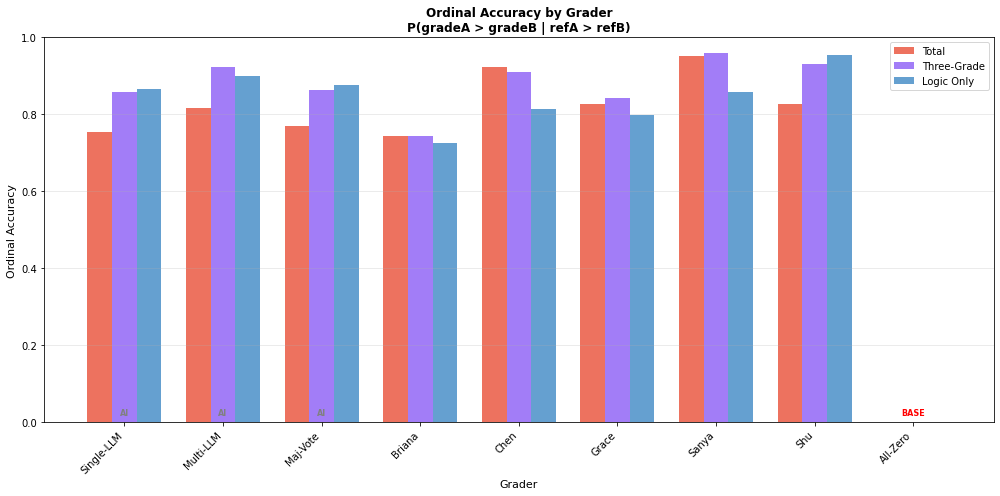


✅ Plot saved to results/analysis/ordinal_accuracy_comparison.png


In [55]:
# Ordinal Accuracy Bar Chart - All Graders
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data
graders = ca_df['display_name'].tolist()
x = np.arange(len(graders))
width = 0.25

# Colors for grade types
total_color = '#E94F37'   # Red for total
three_color = '#8B5CF6'   # Purple for three-grade
logic_color = '#3F88C5'   # Blue for logic

# Create bars
bars1 = ax.bar(x - width, ca_df['ordinal_accuracy_total'], width, label='Total', color=total_color, alpha=0.8)
bars2 = ax.bar(x, ca_df['ordinal_accuracy_three'], width, label='Three-Grade', color=three_color, alpha=0.8)
bars3 = ax.bar(x + width, ca_df['ordinal_accuracy_logic'], width, label='Logic Only', color=logic_color, alpha=0.8)

ax.set_xlabel('Grader', fontsize=11)
ax.set_ylabel('Ordinal Accuracy', fontsize=11)
ax.set_title('Ordinal Accuracy by Grader\nP(gradeA > gradeB | refA > refB)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(graders, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add AI/Human/Baseline markers
for i, grader in enumerate(ca_df['grader']):
    if grader == 'dummy':
        ax.annotate('BASE', xy=(i, 0.02), ha='center', fontsize=8, fontweight='bold', color='red')
    elif grader in AI_GRADERS:
        ax.annotate('AI', xy=(i, 0.02), ha='center', fontsize=8, fontweight='bold', color='gray')

plt.tight_layout()
plt.savefig('results/analysis/ordinal_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/ordinal_accuracy_comparison.png")

In [25]:
# Save consistency-accuracy results to CSV
ca_output_path = 'results/analysis/consistency_accuracy_scores.csv'
ca_df.to_csv(ca_output_path, index=False)
print(f"✅ Consistency-Accuracy results saved to: {ca_output_path}")

# Display summary
print("\n" + "="*80)
print("SUMMARY: TOP PERFORMERS BY COMBINED METRICS")
print("="*80)

print("\n📊 Best by Harmonic Mean (Total Grade):")
best_hm = ca_df.sort_values('harmonic_mean_total', ascending=False).head(3)
for i, (_, row) in enumerate(best_hm.iterrows(), 1):
    print(f"  {i}. {row['display_name']}: {row['harmonic_mean_total']:.3f} (Cons={row['consistency_total']:.3f}, Acc={row['accuracy_total']:.3f})")

print("\n📊 Best by Correct & Consistent (Total Grade):")
best_cc = ca_df.sort_values('correct_consistent_total', ascending=False).head(3)
for i, (_, row) in enumerate(best_cc.iterrows(), 1):
    print(f"  {i}. {row['display_name']}: {row['correct_consistent_total']:.3f}")

print("\n📊 Best by Harmonic Mean (Logic Only):")
best_hm_logic = ca_df.sort_values('harmonic_mean_logic', ascending=False).head(3)
for i, (_, row) in enumerate(best_hm_logic.iterrows(), 1):
    print(f"  {i}. {row['display_name']}: {row['harmonic_mean_logic']:.3f} (Cons={row['consistency_logic']:.3f}, Acc={row['accuracy_logic']:.3f})")

✅ Consistency-Accuracy results saved to: results/analysis/consistency_accuracy_scores.csv

SUMMARY: TOP PERFORMERS BY COMBINED METRICS

📊 Best by Harmonic Mean (Total Grade):
  1. Briana: 0.801 (Cons=0.939, Acc=0.699)
  2. Sanya: 0.752 (Cons=0.738, Acc=0.767)
  3. Grace: 0.741 (Cons=0.826, Acc=0.671)

📊 Best by Correct & Consistent (Total Grade):
  1. All-Zero: 0.855
  2. Briana: 0.818
  3. Grace: 0.736

📊 Best by Harmonic Mean (Logic Only):
  1. Shu: 0.951 (Cons=0.944, Acc=0.959)
  2. Multi-LLM: 0.933 (Cons=0.935, Acc=0.932)
  3. Briana: 0.919 (Cons=0.983, Acc=0.863)


## 10. Lenient Grading Analysis

This section analyzes grading results from the **lenient mode** of the autograder, which doesn't penalize minor differences in input/output/print message wording as long as the semantic meaning is correct.

### Graders in Lenient Mode:
- **Lenient-Single**: Initial grader with lenient_messages=True
- **Lenient-Multi**: Full adversarial grading (grader + critic + revision) with lenient_messages=True

We calculate the same consistency and accuracy metrics to compare with the strict grading mode.

In [9]:
# Load lenient grading results
lenient_df = pd.read_csv('results/diag1_batch1_lenient.csv')
print(f"Loaded {len(lenient_df)} lenient grading records")
print(f"Columns: {lenient_df.columns.tolist()}")

# Merge lenient grades into grading_df
# Rename columns to match pattern: lenient_initial_{cat} and lenient_final_{cat}
lenient_cols = {}
for col in lenient_df.columns:
    if col.startswith('initial_') and not col.endswith('explanation'):
        cat = col.replace('initial_', '')
        lenient_cols[col] = f'lenient_initial_{cat}'
    elif col.startswith('final_') and not col.endswith('explanation'):
        cat = col.replace('final_', '')
        lenient_cols[col] = f'lenient_final_{cat}'

lenient_renamed = lenient_df[['student_id'] + list(lenient_cols.keys())].rename(columns=lenient_cols)
print(f"\nRenamed columns: {list(lenient_cols.values())}")

# Merge with main grading dataframe
grading_df_lenient = grading_df.merge(lenient_renamed, on='student_id', how='left')
print(f"Merged dataframe shape: {grading_df_lenient.shape}")

Loaded 100 lenient grading records
Columns: ['student_id', 'initial_input', 'initial_logic', 'initial_syntax', 'initial_print', 'initial_explanation', 'final_input', 'final_logic', 'final_syntax', 'final_print', 'final_explanation']

Renamed columns: ['lenient_initial_input', 'lenient_initial_logic', 'lenient_initial_syntax', 'lenient_initial_print', 'lenient_final_input', 'lenient_final_logic', 'lenient_final_syntax', 'lenient_final_print']
Merged dataframe shape: (100, 42)


In [10]:
# Define lenient graders
LENIENT_GRADERS = ['lenient_initial', 'lenient_final']
LENIENT_GRADER_NAMES = {
    'lenient_initial': 'Lenient-Single',
    'lenient_final': 'Lenient-Multi'
}

# Update grade functions to handle lenient graders
def get_total_grade_lenient(row, grader):
    """Get total grade for a grader (handles lenient graders)."""
    if grader == 'dummy':
        return 0
    total = 0
    for cat in CATEGORIES:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
    return total

def get_three_grade_lenient(row, grader):
    """Get three-grade for a grader (handles lenient graders)."""
    if grader == 'dummy':
        return 0
    total = 0
    for cat in ['input', 'logic', 'syntax']:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
        else:
            return None
    return total

def get_logic_grade_lenient(row, grader):
    """Get logic grade for a grader (handles lenient graders)."""
    if grader == 'dummy':
        return 0
    col = f"{grader}_logic"
    if col in row.index and pd.notna(row[col]):
        return row[col]
    return None

print(f"Lenient graders: {LENIENT_GRADERS}")
print("Grade functions updated for lenient grading analysis")

Lenient graders: ['lenient_initial', 'lenient_final']
Grade functions updated for lenient grading analysis


In [15]:
# Calculate consistency and accuracy for lenient graders
lenient_results = []

print("="*80)
print("CALCULATING LENIENT GRADING METRICS")
print("="*80)

for grader in LENIENT_GRADERS:
    print(f"\nProcessing {LENIENT_GRADER_NAMES[grader]}...")
    
    # Calculate consistency
    consistency_total, cons_pairs, total_pairs = calculate_consistency(
        grading_df_lenient, multi_program_clusters, grader, get_total_grade_lenient)
    consistency_three, _, _ = calculate_consistency(
        grading_df_lenient, multi_program_clusters, grader, get_three_grade_lenient)
    consistency_logic, _, _ = calculate_consistency(
        grading_df_lenient, multi_program_clusters, grader, get_logic_grade_lenient)
    
    # Calculate accuracy
    acc_total, _, _ = calculate_accuracy(grading_df_lenient, student_to_ref, grader, get_total_grade_lenient, get_total_ref)
    acc_three, _, _ = calculate_accuracy(grading_df_lenient, student_to_ref, grader, get_three_grade_lenient, get_three_ref)
    acc_logic, _, _ = calculate_accuracy(grading_df_lenient, student_to_ref, grader, get_logic_grade_lenient, get_logic_ref)
    
    # Calculate ordinal accuracy
    ord_acc_total, _, _ = calculate_ordinal_accuracy(grading_df_lenient, multi_program_clusters, student_to_ref, 
                                                      grader, get_total_grade_lenient, get_total_ref)
    ord_acc_three, _, _ = calculate_ordinal_accuracy(grading_df_lenient, multi_program_clusters, student_to_ref, 
                                                      grader, get_three_grade_lenient, get_three_ref)
    ord_acc_logic, _, _ = calculate_ordinal_accuracy(grading_df_lenient, multi_program_clusters, student_to_ref, 
                                                      grader, get_logic_grade_lenient, get_logic_ref)
    
    # Calculate correct-and-consistent
    cc_total, _, _ = calculate_correct_and_consistent(grading_df_lenient, multi_program_clusters, student_to_ref, 
                                                       grader, get_total_grade_lenient, get_total_ref)
    cc_three, _, _ = calculate_correct_and_consistent(grading_df_lenient, multi_program_clusters, student_to_ref, 
                                                       grader, get_three_grade_lenient, get_three_ref)
    cc_logic, _, _ = calculate_correct_and_consistent(grading_df_lenient, multi_program_clusters, student_to_ref, 
                                                       grader, get_logic_grade_lenient, get_logic_ref)
    
    # Calculate harmonic means
    hm_total = harmonic_mean(consistency_total, acc_total)
    hm_three = harmonic_mean(consistency_three, acc_three)
    hm_logic = harmonic_mean(consistency_logic, acc_logic)
    
    lenient_results.append({
        'grader': grader,
        'display_name': LENIENT_GRADER_NAMES[grader],
        'is_lenient': True,
        # Total grade metrics
        'consistency_total': consistency_total,
        'accuracy_total': acc_total,
        'ordinal_accuracy_total': ord_acc_total,
        'correct_consistent_total': cc_total,
        'harmonic_mean_total': hm_total,
        # Three-grade metrics
        'consistency_three': consistency_three,
        'accuracy_three': acc_three,
        'ordinal_accuracy_three': ord_acc_three,
        'correct_consistent_three': cc_three,
        'harmonic_mean_three': hm_three,
        # Logic-only metrics  
        'consistency_logic': consistency_logic,
        'accuracy_logic': acc_logic,
        'ordinal_accuracy_logic': ord_acc_logic,
        'correct_consistent_logic': cc_logic,
        'harmonic_mean_logic': hm_logic,
    })
    
    print(f"  Consistency (total): {consistency_total:.3f}")
    print(f"  Accuracy (total): {acc_total:.3f}")
    print(f"  Ordinal Accuracy (total): {ord_acc_total:.3f}")

lenient_df_results = pd.DataFrame(lenient_results)
print("\n✅ Lenient grading metrics calculated")

CALCULATING LENIENT GRADING METRICS

Processing Lenient-Single...
  Consistency (total): 0.659
  Accuracy (total): 0.753
  Ordinal Accuracy (total): 0.816

Processing Lenient-Multi...
  Consistency (total): 0.693
  Accuracy (total): 0.795
  Ordinal Accuracy (total): 0.887

✅ Lenient grading metrics calculated


In [34]:
# Compare strict vs lenient grading
print("="*110)
print("STRICT vs LENIENT GRADING COMPARISON")
print("="*110)

# Get strict results for comparison
strict_single = ca_df[ca_df['grader'] == 'initial'].iloc[0]
strict_multi = ca_df[ca_df['grader'] == 'final'].iloc[0]
lenient_single = lenient_df_results[lenient_df_results['grader'] == 'lenient_initial'].iloc[0]
lenient_multi = lenient_df_results[lenient_df_results['grader'] == 'lenient_final'].iloc[0]

print("\n--- TOTAL GRADE ---")
print(f"{'Mode':<20} {'Consistency':>12} {'Accuracy':>12} {'Ord.Acc':>12} {'C&C':>12} {'Harmonic':>12}")
print("-"*85)
print(f"{'Strict Single-LLM':<20} {strict_single['consistency_total']:>12.3f} {strict_single['accuracy_total']:>12.3f} "
      f"{strict_single['ordinal_accuracy_total']:>12.3f} {strict_single['correct_consistent_total']:>12.3f} {strict_single['harmonic_mean_total']:>12.3f}")
print(f"{'Lenient Single-LLM':<20} {lenient_single['consistency_total']:>12.3f} {lenient_single['accuracy_total']:>12.3f} "
      f"{lenient_single['ordinal_accuracy_total']:>12.3f} {lenient_single['correct_consistent_total']:>12.3f} {lenient_single['harmonic_mean_total']:>12.3f}")
print(f"{'Δ Single':<20} {lenient_single['consistency_total'] - strict_single['consistency_total']:>+12.3f} "
      f"{lenient_single['accuracy_total'] - strict_single['accuracy_total']:>+12.3f} "
      f"{lenient_single['ordinal_accuracy_total'] - strict_single['ordinal_accuracy_total']:>+12.3f} "
      f"{lenient_single['correct_consistent_total'] - strict_single['correct_consistent_total']:>+12.3f} "
      f"{lenient_single['harmonic_mean_total'] - strict_single['harmonic_mean_total']:>+12.3f}")
print()
print(f"{'Strict Multi-LLM':<20} {strict_multi['consistency_total']:>12.3f} {strict_multi['accuracy_total']:>12.3f} "
      f"{strict_multi['ordinal_accuracy_total']:>12.3f} {strict_multi['correct_consistent_total']:>12.3f} {strict_multi['harmonic_mean_total']:>12.3f}")
print(f"{'Lenient Multi-LLM':<20} {lenient_multi['consistency_total']:>12.3f} {lenient_multi['accuracy_total']:>12.3f} "
      f"{lenient_multi['ordinal_accuracy_total']:>12.3f} {lenient_multi['correct_consistent_total']:>12.3f} {lenient_multi['harmonic_mean_total']:>12.3f}")
print(f"{'Δ Multi':<20} {lenient_multi['consistency_total'] - strict_multi['consistency_total']:>+12.3f} "
      f"{lenient_multi['accuracy_total'] - strict_multi['accuracy_total']:>+12.3f} "
      f"{lenient_multi['ordinal_accuracy_total'] - strict_multi['ordinal_accuracy_total']:>+12.3f} "
      f"{lenient_multi['correct_consistent_total'] - strict_multi['correct_consistent_total']:>+12.3f} "
      f"{lenient_multi['harmonic_mean_total'] - strict_multi['harmonic_mean_total']:>+12.3f}")

print("\n--- LOGIC ONLY ---")
print(f"{'Mode':<20} {'Consistency':>12} {'Accuracy':>12} {'Ord.Acc':>12} {'C&C':>12} {'Harmonic':>12}")
print("-"*85)
print(f"{'Strict Single-LLM':<20} {strict_single['consistency_logic']:>12.3f} {strict_single['accuracy_logic']:>12.3f} "
      f"{strict_single['ordinal_accuracy_logic']:>12.3f} {strict_single['correct_consistent_logic']:>12.3f} {strict_single['harmonic_mean_logic']:>12.3f}")
print(f"{'Lenient Single-LLM':<20} {lenient_single['consistency_logic']:>12.3f} {lenient_single['accuracy_logic']:>12.3f} "
      f"{lenient_single['ordinal_accuracy_logic']:>12.3f} {lenient_single['correct_consistent_logic']:>12.3f} {lenient_single['harmonic_mean_logic']:>12.3f}")

STRICT vs LENIENT GRADING COMPARISON

--- TOTAL GRADE ---
Mode                  Consistency     Accuracy      Ord.Acc          C&C     Harmonic
-------------------------------------------------------------------------------------
Strict Single-LLM           0.497        0.562        0.756        0.251        0.527
Lenient Single-LLM          0.659        0.753        0.816        0.622        0.703
Δ Single                   +0.163       +0.192       +0.060       +0.371       +0.176

Strict Multi-LLM            0.516        0.658        0.818        0.398        0.578
Lenient Multi-LLM           0.693        0.795        0.887        0.672        0.740
Δ Multi                    +0.177       +0.137       +0.069       +0.274       +0.162

--- LOGIC ONLY ---
Mode                  Consistency     Accuracy      Ord.Acc          C&C     Harmonic
-------------------------------------------------------------------------------------
Strict Single-LLM           0.770        0.890        0.866  

In [52]:
# Create combined dataframe for visualization (strict + lenient)
# Add lenient graders to the ca_df with 'is_ai' flag
lenient_df_results['is_ai'] = False  # Lenient graders are a separate category
lenient_df_results['is_lenient'] = True

# Add is_lenient column to strict graders
ca_df_with_flag = ca_df.copy()
ca_df_with_flag['is_lenient'] = False

# Combine all graders
all_graders_df = pd.concat([ca_df_with_flag, lenient_df_results], ignore_index=True)
print(f"Combined dataframe: {len(all_graders_df)} graders")
print(all_graders_df[['grader', 'display_name', 'is_ai', 'is_lenient', 'consistency_total', 'ordinal_accuracy_total']].to_string())

Combined dataframe: 11 graders
             grader    display_name  is_ai  is_lenient  consistency_total  ordinal_accuracy_total
0           initial      Single-LLM   True       False           0.496799                0.755613
1             final       Multi-LLM   True       False           0.516005                0.817832
2              base        Maj-Vote   True       False           0.453265                0.769724
3            briana          Briana  False       False           0.938540                0.744067
4              chen            Chen  False       False           0.796415                0.923028
5             grace           Grace  False       False           0.825864                0.826171
6             sanya           Sanya  False       False           0.737516                0.952534
7               shu             Shu  False       False           0.530090                0.827453
8             dummy        All-Zero  False       False           1.000000              

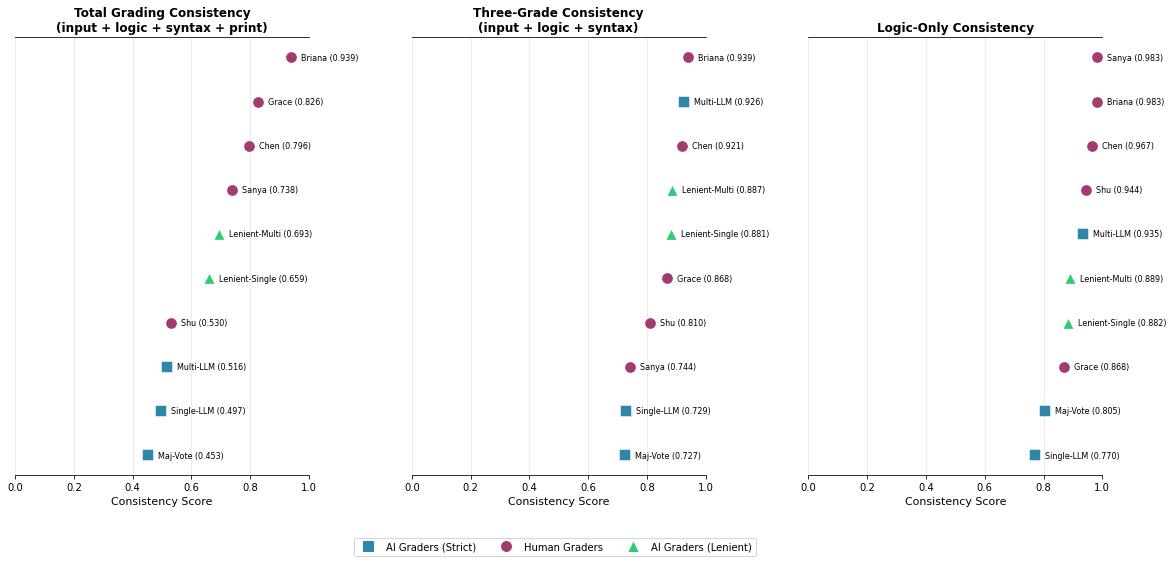


✅ Plot saved to results/analysis/consistency_scores_lenient.png


In [54]:
# Visualization 1: Consistency Scores Dot Plot (Lenient version)
# Exclude the dummy (All-Zero) baseline from this visualization
plot_df = all_graders_df[all_graders_df['grader'] != 'dummy'].copy()

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Colors
ai_color = '#2E86AB'        # Blue for AI
human_color = '#A23B72'     # Purple for humans
baseline_color = '#E94F37'  # Red for baseline
lenient_color = '#2ECC71'   # Green for lenient

def get_color_all(row):
    if row['grader'] == 'dummy':
        return baseline_color
    if row.get('is_lenient', False):
        return lenient_color
    return ai_color if row['is_ai'] else human_color

def get_marker_all(row):
    if row['grader'] == 'dummy':
        return 'D'  # Diamond for baseline
    if row.get('is_lenient', False):
        return '^'  # Triangle for lenient
    return 's' if row['is_ai'] else 'o'

# Sort by consistency score (using plot_df which excludes dummy baseline)
results_sorted_total = plot_df.sort_values('consistency_total', ascending=True)
results_sorted_three = plot_df.sort_values('consistency_three', ascending=True)
results_sorted_logic = plot_df.sort_values('consistency_logic', ascending=True)

# --- Plot 1: Total Grading Consistency ---
ax1 = axes[0]
for i, (_, row) in enumerate(results_sorted_total.iterrows()):
    color = get_color_all(row)
    marker = get_marker_all(row)
    ax1.scatter(row['consistency_total'], i, c=color, s=150, marker=marker, 
                edgecolors='white', linewidths=1.5, zorder=3)
    ax1.annotate(f"{row['display_name']} ({row['consistency_total']:.3f})", 
                 xy=(row['consistency_total'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=8, va='center', clip_on=False)

ax1.set_yticks([])
ax1.set_xlabel('Consistency Score', fontsize=11)
ax1.set_title('Total Grading Consistency\n(input + logic + syntax + print)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(axis='x', alpha=0.3)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

# --- Plot 2: Three-Grade Consistency ---
ax2 = axes[1]
for i, (_, row) in enumerate(results_sorted_three.iterrows()):
    color = get_color_all(row)
    marker = get_marker_all(row)
    ax2.scatter(row['consistency_three'], i, c=color, s=150, marker=marker,
                edgecolors='white', linewidths=1.5, zorder=3)
    ax2.annotate(f"{row['display_name']} ({row['consistency_three']:.3f})", 
                 xy=(row['consistency_three'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=8, va='center', clip_on=False)

ax2.set_yticks([])
ax2.set_xlabel('Consistency Score', fontsize=11)
ax2.set_title('Three-Grade Consistency\n(input + logic + syntax)', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(axis='x', alpha=0.3)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# --- Plot 3: Logic-Only Consistency ---
ax3 = axes[2]
for i, (_, row) in enumerate(results_sorted_logic.iterrows()):
    color = get_color_all(row)
    marker = get_marker_all(row)
    ax3.scatter(row['consistency_logic'], i, c=color, s=150, marker=marker,
                edgecolors='white', linewidths=1.5, zorder=3)
    ax3.annotate(f"{row['display_name']} ({row['consistency_logic']:.3f})", 
                 xy=(row['consistency_logic'], i),
                 xytext=(10, 0), textcoords='offset points',
                 fontsize=8, va='center', clip_on=False)

ax3.set_yticks([])
ax3.set_xlabel('Consistency Score', fontsize=11)
ax3.set_title('Logic-Only Consistency', fontsize=12, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.grid(axis='x', alpha=0.3)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

# Add legend (without dummy baseline since it's excluded from this plot)
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='AI Graders (Strict)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=lenient_color, markersize=12, label='AI Graders (Lenient)'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02))

plt.subplots_adjust(bottom=0.12, right=0.88, wspace=0.35)
plt.savefig('results/analysis/consistency_scores_lenient.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/consistency_scores_lenient.png")

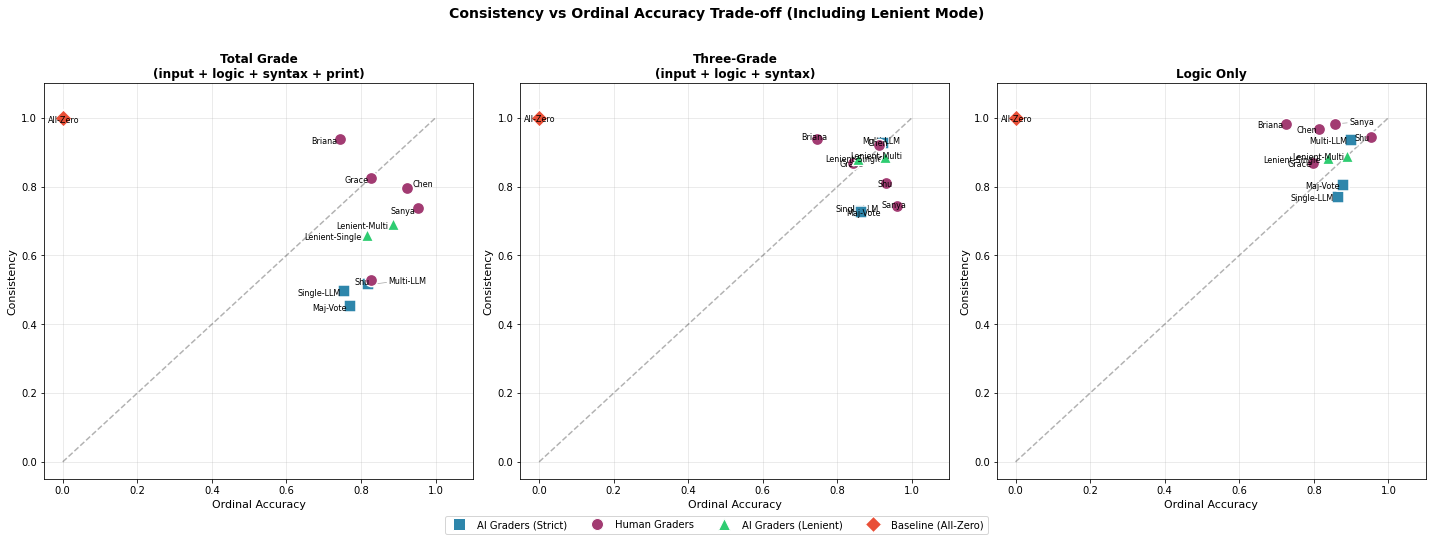


✅ Plot saved to results/analysis/consistency_vs_accuracy_lenient.png


In [ ]:
# Visualization 2: Consistency vs Accuracy Scatter Plot (with lenient)
try:
    from adjustText import adjust_text
    USE_ADJUST_TEXT = True
except ImportError:
    USE_ADJUST_TEXT = False

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# --- Plot 1: Total Grade ---
ax1 = axes[0]
texts1 = []
for _, row in all_graders_df.iterrows():
    color = get_color_all(row)
    marker = get_marker_all(row)
    ax1.scatter(row['ordinal_accuracy_total'], row['consistency_total'], c=color, s=150, 
                marker=marker, edgecolors='white', linewidths=1.5, zorder=3)
    texts1.append(ax1.text(row['ordinal_accuracy_total'], row['consistency_total'], row['display_name'], fontsize=8))

if USE_ADJUST_TEXT:
    adjust_text(texts1, ax=ax1, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax1.set_xlabel('Ordinal Accuracy', fontsize=11)
ax1.set_ylabel('Consistency', fontsize=11)
ax1.set_title('Total Grade\n(input + logic + syntax + print)', fontsize=12, fontweight='bold')
ax1.set_xlim(-0.05, 1.1)
ax1.set_ylim(-0.05, 1.1)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
ax1.grid(alpha=0.3)

# --- Plot 2: Three-Grade ---
ax2 = axes[1]
texts2 = []
for _, row in all_graders_df.iterrows():
    color = get_color_all(row)
    marker = get_marker_all(row)
    ax2.scatter(row['ordinal_accuracy_three'], row['consistency_three'], c=color, s=150, 
                marker=marker, edgecolors='white', linewidths=1.5, zorder=3)
    texts2.append(ax2.text(row['ordinal_accuracy_three'], row['consistency_three'], row['display_name'], fontsize=8))

if USE_ADJUST_TEXT:
    adjust_text(texts2, ax=ax2, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax2.set_xlabel('Ordinal Accuracy', fontsize=11)
ax2.set_ylabel('Consistency', fontsize=11)
ax2.set_title('Three-Grade\n(input + logic + syntax)', fontsize=12, fontweight='bold')
ax2.set_xlim(-0.05, 1.1)
ax2.set_ylim(-0.05, 1.1)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
ax2.grid(alpha=0.3)

# --- Plot 3: Logic Only ---
ax3 = axes[2]
texts3 = []
for _, row in all_graders_df.iterrows():
    color = get_color_all(row)
    marker = get_marker_all(row)
    ax3.scatter(row['ordinal_accuracy_logic'], row['consistency_logic'], c=color, s=150, 
                marker=marker, edgecolors='white', linewidths=1.5, zorder=3)
    texts3.append(ax3.text(row['ordinal_accuracy_logic'], row['consistency_logic'], row['display_name'], fontsize=8))

if USE_ADJUST_TEXT:
    adjust_text(texts3, ax=ax3, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax3.set_xlabel('Ordinal Accuracy', fontsize=11)
ax3.set_ylabel('Consistency', fontsize=11)
ax3.set_title('Logic Only', fontsize=12, fontweight='bold')
ax3.set_xlim(-0.05, 1.1)
ax3.set_ylim(-0.05, 1.1)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='y=x')
ax3.grid(alpha=0.3)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='AI Graders (Strict)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor=lenient_color, markersize=12, label='AI Graders (Lenient)'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor=baseline_color, markersize=12, label='Baseline (All-Zero)'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Consistency vs Ordinal Accuracy Trade-off (Including Lenient Mode)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('results/analysis/consistency_vs_accuracy_lenient.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/consistency_vs_accuracy_lenient.png")

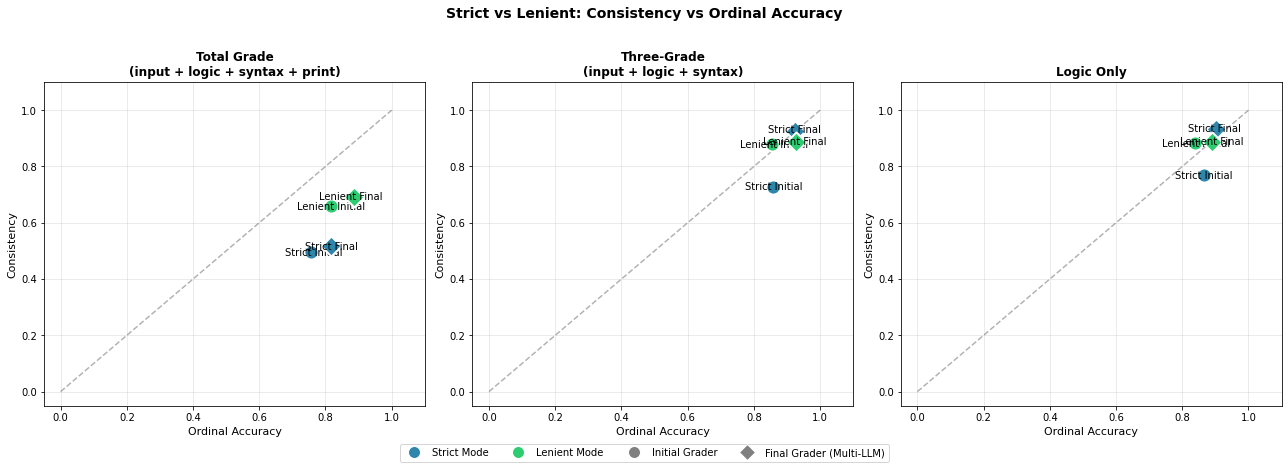


✅ Plot saved to results/analysis/strict_vs_lenient_comparison.png

STRICT vs LENIENT COMPARISON TABLE

Grader                Consistency   Ord.Accuracy   Three-Cons    Three-Ord
---------------------------------------------------------------------------
Strict Initial              0.497          0.756        0.729        0.858
Strict Final                0.516          0.818        0.926        0.924
Lenient Initial             0.659          0.816        0.881        0.854
Lenient Final               0.693          0.887        0.887        0.928


In [53]:
# Focused Comparison: Strict vs Lenient (Initial and Final only)
# Create a focused dataframe with just the 4 graders we want to compare

focus_graders = ['initial', 'final', 'lenient_initial', 'lenient_final']
focus_names = {
    'initial': 'Strict Initial',
    'final': 'Strict Final',
    'lenient_initial': 'Lenient Initial',
    'lenient_final': 'Lenient Final'
}

# Filter to just these graders
focus_df = all_graders_df[all_graders_df['grader'].isin(focus_graders)].copy()
focus_df['focus_name'] = focus_df['grader'].map(focus_names)

# Define colors and markers
strict_color = '#2E86AB'   # Blue for strict
lenient_color = '#2ECC71'  # Green for lenient

try:
    from adjustText import adjust_text
    USE_ADJUST_TEXT = True
except ImportError:
    USE_ADJUST_TEXT = False

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Helper functions for this plot
def get_focus_color(grader):
    if 'lenient' in grader:
        return lenient_color
    return strict_color

def get_focus_marker(grader):
    if 'final' in grader:
        return 'D'  # Diamond for final
    return 'o'  # Circle for initial

# --- Plot 1: Total Grade ---
ax1 = axes[0]
texts1 = []
for _, row in focus_df.iterrows():
    color = get_focus_color(row['grader'])
    marker = get_focus_marker(row['grader'])
    ax1.scatter(row['ordinal_accuracy_total'], row['consistency_total'], c=color, s=200, 
                marker=marker, edgecolors='white', linewidths=2, zorder=3)
    texts1.append(ax1.text(row['ordinal_accuracy_total'], row['consistency_total'], row['focus_name'], fontsize=10))

if USE_ADJUST_TEXT:
    adjust_text(texts1, ax=ax1, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax1.set_xlabel('Ordinal Accuracy', fontsize=11)
ax1.set_ylabel('Consistency', fontsize=11)
ax1.set_title('Total Grade\n(input + logic + syntax + print)', fontsize=12, fontweight='bold')
ax1.set_xlim(-0.05, 1.1)
ax1.set_ylim(-0.05, 1.1)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax1.grid(alpha=0.3)

# --- Plot 2: Three-Grade ---
ax2 = axes[1]
texts2 = []
for _, row in focus_df.iterrows():
    color = get_focus_color(row['grader'])
    marker = get_focus_marker(row['grader'])
    ax2.scatter(row['ordinal_accuracy_three'], row['consistency_three'], c=color, s=200, 
                marker=marker, edgecolors='white', linewidths=2, zorder=3)
    texts2.append(ax2.text(row['ordinal_accuracy_three'], row['consistency_three'], row['focus_name'], fontsize=10))

if USE_ADJUST_TEXT:
    adjust_text(texts2, ax=ax2, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax2.set_xlabel('Ordinal Accuracy', fontsize=11)
ax2.set_ylabel('Consistency', fontsize=11)
ax2.set_title('Three-Grade\n(input + logic + syntax)', fontsize=12, fontweight='bold')
ax2.set_xlim(-0.05, 1.1)
ax2.set_ylim(-0.05, 1.1)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax2.grid(alpha=0.3)

# --- Plot 3: Logic Only ---
ax3 = axes[2]
texts3 = []
for _, row in focus_df.iterrows():
    color = get_focus_color(row['grader'])
    marker = get_focus_marker(row['grader'])
    ax3.scatter(row['ordinal_accuracy_logic'], row['consistency_logic'], c=color, s=200, 
                marker=marker, edgecolors='white', linewidths=2, zorder=3)
    texts3.append(ax3.text(row['ordinal_accuracy_logic'], row['consistency_logic'], row['focus_name'], fontsize=10))

if USE_ADJUST_TEXT:
    adjust_text(texts3, ax=ax3, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

ax3.set_xlabel('Ordinal Accuracy', fontsize=11)
ax3.set_ylabel('Consistency', fontsize=11)
ax3.set_title('Logic Only', fontsize=12, fontweight='bold')
ax3.set_xlim(-0.05, 1.1)
ax3.set_ylim(-0.05, 1.1)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax3.grid(alpha=0.3)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=strict_color, markersize=12, label='Strict Mode'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=lenient_color, markersize=12, label='Lenient Mode'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=12, label='Initial Grader'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='gray', markersize=12, label='Final Grader (Multi-LLM)'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Strict vs Lenient: Consistency vs Ordinal Accuracy', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('results/analysis/strict_vs_lenient_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/strict_vs_lenient_comparison.png")

# Print comparison table
print("\n" + "="*80)
print("STRICT vs LENIENT COMPARISON TABLE")
print("="*80)
print(f"\n{'Grader':<20} {'Consistency':>12} {'Ord.Accuracy':>14} {'Three-Cons':>12} {'Three-Ord':>12}")
print("-"*75)
for _, row in focus_df.iterrows():
    print(f"{row['focus_name']:<20} {row['consistency_total']:>12.3f} {row['ordinal_accuracy_total']:>14.3f} "
          f"{row['consistency_three']:>12.3f} {row['ordinal_accuracy_three']:>12.3f}")

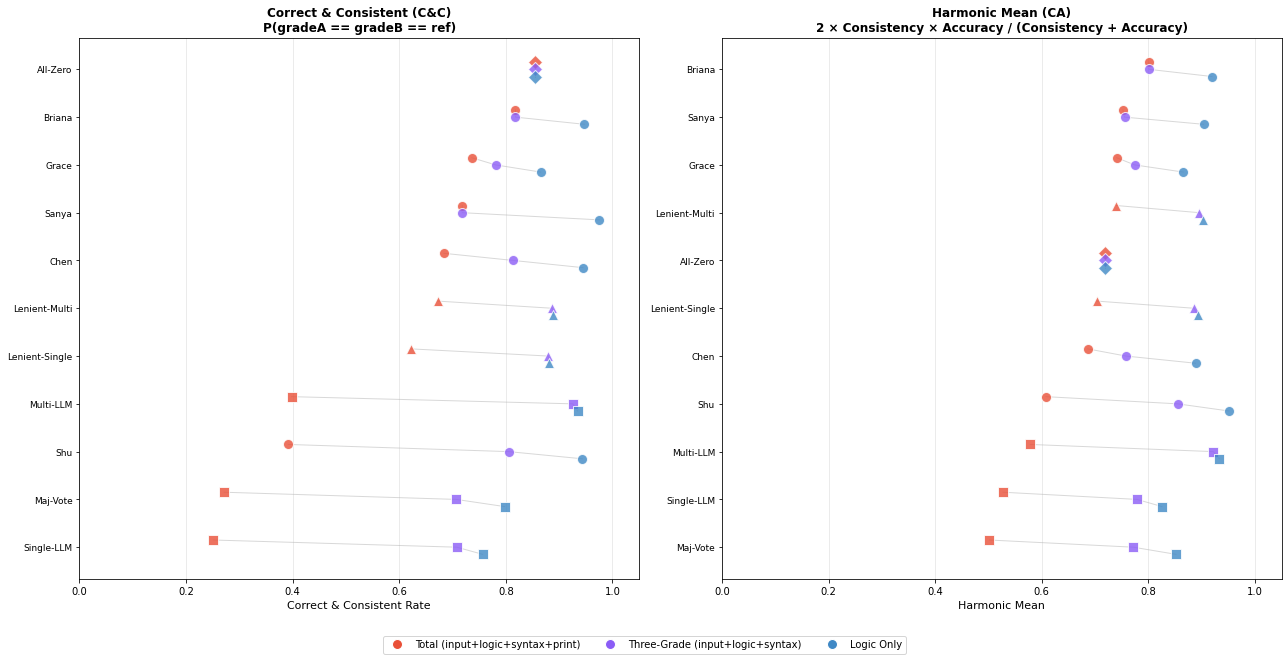


✅ Plot saved to results/analysis/combined_metrics_lenient.png


In [38]:
# Visualization 3: Combined Metrics Dot Plot (with lenient)
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Sort by C&C for left plot, by Harmonic Mean for right plot
sorted_by_cc = all_graders_df.sort_values('correct_consistent_total', ascending=True)
sorted_by_hm = all_graders_df.sort_values('harmonic_mean_total', ascending=True)

# --- Plot 1: Correct & Consistent (C&C) Dot Plot ---
ax1 = axes[0]
for i, (_, row) in enumerate(sorted_by_cc.iterrows()):
    color = get_color_all(row)
    marker = get_marker_all(row)
    
    # Plot three dots for each grader (total, three, logic)
    ax1.scatter(row['correct_consistent_total'], i + 0.15, c='#E94F37', s=100, marker=marker, 
                edgecolors='white', linewidths=1, zorder=3, alpha=0.8)
    ax1.scatter(row['correct_consistent_three'], i, c='#8B5CF6', s=100, marker=marker, 
                edgecolors='white', linewidths=1, zorder=3, alpha=0.8)
    ax1.scatter(row['correct_consistent_logic'], i - 0.15, c='#3F88C5', s=100, marker=marker, 
                edgecolors='white', linewidths=1, zorder=3, alpha=0.8)
    
    # Connect dots
    ax1.plot([row['correct_consistent_total'], row['correct_consistent_three'], row['correct_consistent_logic']], 
             [i + 0.15, i, i - 0.15], color='gray', alpha=0.3, linewidth=1, zorder=1)

ax1.set_yticks(range(len(sorted_by_cc)))
ax1.set_yticklabels([f"{row['display_name']}" for _, row in sorted_by_cc.iterrows()], fontsize=9)
ax1.set_xlabel('Correct & Consistent Rate', fontsize=11)
ax1.set_title('Correct & Consistent (C&C)\nP(gradeA == gradeB == ref)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 1.05)
ax1.grid(axis='x', alpha=0.3)

# --- Plot 2: Harmonic Mean Dot Plot ---
ax2 = axes[1]
for i, (_, row) in enumerate(sorted_by_hm.iterrows()):
    color = get_color_all(row)
    marker = get_marker_all(row)
    
    # Plot three dots for each grader (total, three, logic)
    ax2.scatter(row['harmonic_mean_total'], i + 0.15, c='#E94F37', s=100, marker=marker, 
                edgecolors='white', linewidths=1, zorder=3, alpha=0.8)
    ax2.scatter(row['harmonic_mean_three'], i, c='#8B5CF6', s=100, marker=marker, 
                edgecolors='white', linewidths=1, zorder=3, alpha=0.8)
    ax2.scatter(row['harmonic_mean_logic'], i - 0.15, c='#3F88C5', s=100, marker=marker, 
                edgecolors='white', linewidths=1, zorder=3, alpha=0.8)
    
    # Connect dots
    ax2.plot([row['harmonic_mean_total'], row['harmonic_mean_three'], row['harmonic_mean_logic']], 
             [i + 0.15, i, i - 0.15], color='gray', alpha=0.3, linewidth=1, zorder=1)

ax2.set_yticks(range(len(sorted_by_hm)))
ax2.set_yticklabels([f"{row['display_name']}" for _, row in sorted_by_hm.iterrows()], fontsize=9)
ax2.set_xlabel('Harmonic Mean', fontsize=11)
ax2.set_title('Harmonic Mean (CA)\n2 × Consistency × Accuracy / (Consistency + Accuracy)', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1.05)
ax2.grid(axis='x', alpha=0.3)

# Add legend for metric types
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#E94F37', markersize=10, label='Total (input+logic+syntax+print)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#8B5CF6', markersize=10, label='Three-Grade (input+logic+syntax)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3F88C5', markersize=10, label='Logic Only'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.savefig('results/analysis/combined_metrics_lenient.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Plot saved to results/analysis/combined_metrics_lenient.png")

In [39]:
# Save lenient analysis results
lenient_output_path = 'results/analysis/consistency_accuracy_scores_lenient.csv'
lenient_df_results.to_csv(lenient_output_path, index=False)
print(f"✅ Lenient grading results saved to: {lenient_output_path}")

# Save combined results
combined_output_path = 'results/analysis/consistency_accuracy_scores_all.csv'
all_graders_df.to_csv(combined_output_path, index=False)
print(f"✅ Combined results saved to: {combined_output_path}")

# Final summary
print("\n" + "="*80)
print("LENIENT GRADING ANALYSIS SUMMARY")
print("="*80)
print("\nKey findings:")
print(f"  - Lenient-Single consistency (total): {lenient_single['consistency_total']:.3f} (Δ from Strict: {lenient_single['consistency_total'] - strict_single['consistency_total']:+.3f})")
print(f"  - Lenient-Multi consistency (total): {lenient_multi['consistency_total']:.3f} (Δ from Strict: {lenient_multi['consistency_total'] - strict_multi['consistency_total']:+.3f})")
print(f"  - Lenient-Single accuracy (total): {lenient_single['accuracy_total']:.3f} (Δ from Strict: {lenient_single['accuracy_total'] - strict_single['accuracy_total']:+.3f})")
print(f"  - Lenient-Multi accuracy (total): {lenient_multi['accuracy_total']:.3f} (Δ from Strict: {lenient_multi['accuracy_total'] - strict_multi['accuracy_total']:+.3f})")

print("\nOutput files:")
print(f"  📊 results/analysis/consistency_scores_lenient.png")
print(f"  📊 results/analysis/consistency_vs_accuracy_lenient.png")
print(f"  📊 results/analysis/combined_metrics_lenient.png")
print(f"  📄 results/analysis/consistency_accuracy_scores_lenient.csv")
print(f"  📄 results/analysis/consistency_accuracy_scores_all.csv")

✅ Lenient grading results saved to: results/analysis/consistency_accuracy_scores_lenient.csv
✅ Combined results saved to: results/analysis/consistency_accuracy_scores_all.csv

LENIENT GRADING ANALYSIS SUMMARY

Key findings:
  - Lenient-Single consistency (total): 0.659 (Δ from Strict: +0.163)
  - Lenient-Multi consistency (total): 0.693 (Δ from Strict: +0.177)
  - Lenient-Single accuracy (total): 0.753 (Δ from Strict: +0.192)
  - Lenient-Multi accuracy (total): 0.795 (Δ from Strict: +0.137)

Output files:
  📊 results/analysis/consistency_scores_lenient.png
  📊 results/analysis/consistency_vs_accuracy_lenient.png
  📊 results/analysis/combined_metrics_lenient.png
  📄 results/analysis/consistency_accuracy_scores_lenient.csv
  📄 results/analysis/consistency_accuracy_scores_all.csv


## 11. Lenient Grading Change Analysis

Extract programs where the initial lenient score differs from the final lenient score (i.e., where the critic caused a grade change).

In [40]:
# Load the full lenient grading results
lenient_full_df = pd.read_csv('results/diag1_batch1_lenient.csv')
print(f"Loaded {len(lenient_full_df)} lenient grading records")

# Define the categories to compare
categories = ['input', 'logic', 'syntax', 'print']

# Find programs where any category changed between initial and final
def has_score_change(row):
    """Check if any category score changed between initial and final."""
    for cat in categories:
        initial_col = f'initial_{cat}'
        final_col = f'final_{cat}'
        if row[initial_col] != row[final_col]:
            return True
    return False

# Add a column indicating which categories changed
def get_changed_categories(row):
    """Get list of categories that changed."""
    changed = []
    for cat in categories:
        initial_col = f'initial_{cat}'
        final_col = f'final_{cat}'
        if row[initial_col] != row[final_col]:
            changed.append(f"{cat}: {row[initial_col]}→{row[final_col]}")
    return "; ".join(changed) if changed else "none"

# Filter to programs with changes
lenient_full_df['has_change'] = lenient_full_df.apply(has_score_change, axis=1)
lenient_full_df['changed_categories'] = lenient_full_df.apply(get_changed_categories, axis=1)

changed_df = lenient_full_df[lenient_full_df['has_change']].copy()
print(f"\nPrograms with score changes: {len(changed_df)} / {len(lenient_full_df)} ({100*len(changed_df)/len(lenient_full_df):.1f}%)")

# Show summary of changes
print("\n" + "="*70)
print("SCORE CHANGE SUMMARY")
print("="*70)

for cat in categories:
    initial_col = f'initial_{cat}'
    final_col = f'final_{cat}'
    cat_changes = changed_df[changed_df[initial_col] != changed_df[final_col]]
    if len(cat_changes) > 0:
        print(f"\n{cat.upper()} changes: {len(cat_changes)} programs")
        # Show direction of changes
        for _, row in cat_changes.iterrows():
            direction = "↑" if row[final_col] > row[initial_col] else "↓"
            print(f"  {row['student_id'][:20]}...: {row[initial_col]} → {row[final_col]} {direction}")

Loaded 100 lenient grading records

Programs with score changes: 17 / 100 (17.0%)

SCORE CHANGE SUMMARY

LOGIC changes: 13 programs
  JXjesS8GwhfdJDwsUVkf...: 0 → 1 ↑
  54WbvvuBnLNRgql13Pio...: 0 → 1 ↑
  5G2izZR8aaV3O6ZEYNyJ...: 1 → 2 ↑
  fAs4qGtu3YfqcXJzT3ls...: 0 → 1 ↑
  mEtx8thTCMfZM3zFQRAA...: 1 → 2 ↑
  h3y8BbCkTcPf19i48ngO...: 1 → 2 ↑
  EHhPwcRZDze6PAVWSCE1...: 0 → 1 ↑
  0VF7NfAuyVfKtCXQJCNz...: 1 → 2 ↑
  pb3Mg9bNdmStwOb2jdFR...: 0 → 1 ↑
  OrjlEixNsKU935DlyhBv...: 1 → 2 ↑
  9i2VYwFeifbkZnO1OhOS...: 1 → 2 ↑
  OESApcstMLhqBubmr8uv...: 0 → 2 ↑
  rxHLG4923SQAX7yRsbbb...: 1 → 2 ↑

SYNTAX changes: 1 programs
  cLqjRj5fWTdUXvB0hrzw...: 1 → 2 ↑

PRINT changes: 6 programs
  JXjesS8GwhfdJDwsUVkf...: 0 → 2 ↑
  NtPBwP7JwuREuTooA8Pd...: 1 → 0 ↓
  8hee7q9vyXfVRPIQPJbZ...: 1 → 0 ↓
  9gRKBhqUTJZ4ZIg690VI...: 1 → 0 ↓
  0VF7NfAuyVfKtCXQJCNz...: 0 → 1 ↑
  OrjlEixNsKU935DlyhBv...: 1 → 2 ↑


In [41]:
# Save programs with changed scores
# Keep all original columns plus the new columns
output_path = 'results/diag1_batch1_lenient_change.csv'
changed_df.to_csv(output_path, index=False)

print(f"✅ Saved {len(changed_df)} programs with score changes to: {output_path}")
print(f"\nColumns in output file: {changed_df.columns.tolist()}")

# Show a preview
print("\n" + "="*70)
print("PREVIEW OF CHANGED PROGRAMS")
print("="*70)
preview_cols = ['student_id', 'initial_input', 'final_input', 'initial_logic', 'final_logic', 
                'initial_syntax', 'final_syntax', 'initial_print', 'final_print', 'changed_categories']
print(changed_df[preview_cols].head(10).to_string())

✅ Saved 17 programs with score changes to: results/diag1_batch1_lenient_change.csv

Columns in output file: ['student_id', 'initial_input', 'initial_logic', 'initial_syntax', 'initial_print', 'initial_explanation', 'final_input', 'final_logic', 'final_syntax', 'final_print', 'final_explanation', 'has_change', 'changed_categories']

PREVIEW OF CHANGED PROGRAMS
                      student_id  initial_input  final_input  initial_logic  final_logic  initial_syntax  final_syntax  initial_print  final_print      changed_categories
19  JXjesS8GwhfdJDwsUVkf9UAMyAN2              0            0              0            1               0             0              0            2  logic: 0→1; print: 0→2
22  54WbvvuBnLNRgql13PiopcQ9JF02              0            0              0            1               0             0              0            0              logic: 0→1
28  NtPBwP7JwuREuTooA8PdpESmPbH3              0            0              1            1               0             0       

## 12. Strict vs Lenient Comparison

Compare strict grading with lenient grading to identify programs where leniency changed the score.
- **Initial Strict vs Initial Lenient**: How does lenient mode affect the initial grader?
- **Final Strict vs Final Lenient**: How does lenient mode affect the adversarial grading outcome?

Focus on:
1. Print category changes (expected to be most affected)
2. Other category changes
3. Severity: 0↔1 or 0↔2 changes (perfect ↔ error) vs 1↔2 changes (minor ↔ major error)

In [16]:
# Load original (strict) grading data
# The original data uses 'initial_' and 'final_' columns in grading_df
# We need to compare with lenient_df which has the same column names

# First, load the original strict grading
strict_df = pd.read_csv('results/diag1_batch1.csv')
print(f"Loaded {len(strict_df)} strict grading records")

# The strict_df has JSON in initial_grade and final_grade columns
# We need to parse these to get the individual scores
import json

def extract_strict_scores(row, stage='initial'):
    """Extract scores from the JSON grade column."""
    grade_col = f'{stage}_grade'
    try:
        grades = json.loads(row[grade_col])
        return {
            f'{stage}_input': grades.get('input', {}).get('option'),
            f'{stage}_logic': grades.get('conditional_logic', {}).get('option'),
            f'{stage}_syntax': grades.get('syntax_errors', {}).get('option'),
            f'{stage}_print': grades.get('printing', {}).get('option'),
        }
    except:
        return {f'{stage}_input': None, f'{stage}_logic': None, f'{stage}_syntax': None, f'{stage}_print': None}

# Extract scores for initial and final
strict_initial_scores = strict_df.apply(lambda r: extract_strict_scores(r, 'initial'), axis=1, result_type='expand')
strict_final_scores = strict_df.apply(lambda r: extract_strict_scores(r, 'final'), axis=1, result_type='expand')

# Create strict dataframe with extracted scores
strict_extracted = pd.concat([
    strict_df[['student_id']],
    strict_initial_scores,
    strict_final_scores
], axis=1)

# Rename columns to indicate these are strict scores
strict_extracted = strict_extracted.rename(columns={
    'initial_input': 'strict_initial_input',
    'initial_logic': 'strict_initial_logic',
    'initial_syntax': 'strict_initial_syntax',
    'initial_print': 'strict_initial_print',
    'final_input': 'strict_final_input',
    'final_logic': 'strict_final_logic',
    'final_syntax': 'strict_final_syntax',
    'final_print': 'strict_final_print',
})

print(f"Extracted strict scores: {strict_extracted.columns.tolist()}")

Loaded 100 strict grading records
Extracted strict scores: ['student_id', 'strict_initial_input', 'strict_initial_logic', 'strict_initial_syntax', 'strict_initial_print', 'strict_final_input', 'strict_final_logic', 'strict_final_syntax', 'strict_final_print']


In [17]:
# Rename lenient columns for clarity
lenient_renamed_df = lenient_full_df.rename(columns={
    'initial_input': 'lenient_initial_input',
    'initial_logic': 'lenient_initial_logic',
    'initial_syntax': 'lenient_initial_syntax',
    'initial_print': 'lenient_initial_print',
    'initial_explanation': 'lenient_initial_explanation',
    'final_input': 'lenient_final_input',
    'final_logic': 'lenient_final_logic',
    'final_syntax': 'lenient_final_syntax',
    'final_print': 'lenient_final_print',
    'final_explanation': 'lenient_final_explanation',
})

# Merge strict and lenient data
comparison_df = strict_extracted.merge(lenient_renamed_df, on='student_id', how='inner')
print(f"Merged comparison dataframe: {len(comparison_df)} programs")

# Define helper functions for change analysis
def categorize_change(old_val, new_val):
    """Categorize the type of change."""
    if old_val == new_val:
        return 'no_change'
    elif {old_val, new_val} == {0, 1}:
        return '0↔1'  # Perfect ↔ minor error
    elif {old_val, new_val} == {0, 2}:
        return '0↔2'  # Perfect ↔ major error
    elif {old_val, new_val} == {1, 2}:
        return '1↔2'  # Minor ↔ major error
    else:
        return f'{old_val}→{new_val}'

def get_change_direction(old_val, new_val):
    """Get direction: stricter (↑), lenient (↓), or same."""
    if old_val == new_val:
        return 'same'
    elif new_val > old_val:
        return 'stricter'  # Higher score = worse = stricter
    else:
        return 'lenient'  # Lower score = better = more lenient

print("Helper functions defined")

NameError: name 'lenient_full_df' is not defined

In [44]:
# Compare INITIAL Strict vs INITIAL Lenient
print("="*80)
print("COMPARISON: INITIAL STRICT vs INITIAL LENIENT")
print("="*80)

categories = ['input', 'logic', 'syntax', 'print']

# Check for changes in each category
for cat in categories:
    strict_col = f'strict_initial_{cat}'
    lenient_col = f'lenient_initial_{cat}'
    comparison_df[f'initial_{cat}_change'] = comparison_df.apply(
        lambda r: categorize_change(r[strict_col], r[lenient_col]), axis=1)
    comparison_df[f'initial_{cat}_direction'] = comparison_df.apply(
        lambda r: get_change_direction(r[strict_col], r[lenient_col]), axis=1)

# Find programs with any initial change
comparison_df['initial_has_change'] = comparison_df.apply(
    lambda r: any(r[f'initial_{cat}_change'] != 'no_change' for cat in categories), axis=1)

# Get changed categories description
def get_initial_changed_desc(row):
    changes = []
    for cat in categories:
        strict_col = f'strict_initial_{cat}'
        lenient_col = f'lenient_initial_{cat}'
        if row[strict_col] != row[lenient_col]:
            changes.append(f"{cat}: {row[strict_col]}→{row[lenient_col]}")
    return "; ".join(changes) if changes else "none"

comparison_df['initial_changed_categories'] = comparison_df.apply(get_initial_changed_desc, axis=1)

# Filter to changed programs
initial_changed_df = comparison_df[comparison_df['initial_has_change']].copy()
print(f"\nPrograms with INITIAL changes: {len(initial_changed_df)} / {len(comparison_df)} ({100*len(initial_changed_df)/len(comparison_df):.1f}%)")

COMPARISON: INITIAL STRICT vs INITIAL LENIENT

Programs with INITIAL changes: 34 / 100 (34.0%)


In [45]:
# Compare FINAL Strict vs FINAL Lenient
print("\n" + "="*80)
print("COMPARISON: FINAL STRICT vs FINAL LENIENT")
print("="*80)

# Check for changes in each category
for cat in categories:
    strict_col = f'strict_final_{cat}'
    lenient_col = f'lenient_final_{cat}'
    comparison_df[f'final_{cat}_change'] = comparison_df.apply(
        lambda r: categorize_change(r[strict_col], r[lenient_col]), axis=1)
    comparison_df[f'final_{cat}_direction'] = comparison_df.apply(
        lambda r: get_change_direction(r[strict_col], r[lenient_col]), axis=1)

# Find programs with any final change
comparison_df['final_has_change'] = comparison_df.apply(
    lambda r: any(r[f'final_{cat}_change'] != 'no_change' for cat in categories), axis=1)

# Get changed categories description
def get_final_changed_desc(row):
    changes = []
    for cat in categories:
        strict_col = f'strict_final_{cat}'
        lenient_col = f'lenient_final_{cat}'
        if row[strict_col] != row[lenient_col]:
            changes.append(f"{cat}: {row[strict_col]}→{row[lenient_col]}")
    return "; ".join(changes) if changes else "none"

comparison_df['final_changed_categories'] = comparison_df.apply(get_final_changed_desc, axis=1)

# Filter to changed programs
final_changed_df = comparison_df[comparison_df['final_has_change']].copy()
print(f"\nPrograms with FINAL changes: {len(final_changed_df)} / {len(comparison_df)} ({100*len(final_changed_df)/len(comparison_df):.1f}%)")


COMPARISON: FINAL STRICT vs FINAL LENIENT

Programs with FINAL changes: 35 / 100 (35.0%)


In [46]:
# Save the changed programs to CSV files
# Select relevant columns for output

initial_output_cols = ['student_id', 
                       'strict_initial_input', 'strict_initial_logic', 'strict_initial_syntax', 'strict_initial_print',
                       'lenient_initial_input', 'lenient_initial_logic', 'lenient_initial_syntax', 'lenient_initial_print',
                       'lenient_initial_explanation',
                       'initial_input_change', 'initial_logic_change', 'initial_syntax_change', 'initial_print_change',
                       'initial_input_direction', 'initial_logic_direction', 'initial_syntax_direction', 'initial_print_direction',
                       'initial_changed_categories']

final_output_cols = ['student_id', 
                     'strict_final_input', 'strict_final_logic', 'strict_final_syntax', 'strict_final_print',
                     'lenient_final_input', 'lenient_final_logic', 'lenient_final_syntax', 'lenient_final_print',
                     'lenient_final_explanation',
                     'final_input_change', 'final_logic_change', 'final_syntax_change', 'final_print_change',
                     'final_input_direction', 'final_logic_direction', 'final_syntax_direction', 'final_print_direction',
                     'final_changed_categories']

# Save initial changes
initial_output_path = 'results/diag1_batch1_strict_vs_lenient_initial.csv'
initial_changed_df[initial_output_cols].to_csv(initial_output_path, index=False)
print(f"✅ Saved {len(initial_changed_df)} initial changes to: {initial_output_path}")

# Save final changes
final_output_path = 'results/diag1_batch1_strict_vs_lenient_final.csv'
final_changed_df[final_output_cols].to_csv(final_output_path, index=False)
print(f"✅ Saved {len(final_changed_df)} final changes to: {final_output_path}")

✅ Saved 34 initial changes to: results/diag1_batch1_strict_vs_lenient_initial.csv
✅ Saved 35 final changes to: results/diag1_batch1_strict_vs_lenient_final.csv


In [47]:
# STATISTICAL ANALYSIS
print("="*90)
print("STATISTICAL ANALYSIS: STRICT vs LENIENT GRADING CHANGES")
print("="*90)

def analyze_changes(df, stage, categories):
    """Analyze changes for a given stage (initial or final)."""
    print(f"\n{'='*90}")
    print(f"{stage.upper()} STRICT vs LENIENT - DETAILED ANALYSIS")
    print(f"{'='*90}")
    
    total_programs = len(comparison_df)
    changed_programs = len(df)
    
    print(f"\n📊 OVERVIEW:")
    print(f"   Total programs: {total_programs}")
    print(f"   Programs with changes: {changed_programs} ({100*changed_programs/total_programs:.1f}%)")
    
    # Analyze by category
    print(f"\n📊 CHANGES BY CATEGORY:")
    category_stats = {}
    for cat in categories:
        change_col = f'{stage}_{cat}_change'
        direction_col = f'{stage}_{cat}_direction'
        
        # Count programs with changes in this category
        changed_in_cat = df[df[change_col] != 'no_change']
        n_changed = len(changed_in_cat)
        
        category_stats[cat] = {
            'total_changed': n_changed,
            'changes': changed_in_cat[change_col].value_counts().to_dict(),
            'directions': changed_in_cat[direction_col].value_counts().to_dict()
        }
        
        print(f"\n   {cat.upper()}: {n_changed} programs changed ({100*n_changed/changed_programs:.1f}% of changed)")
        
        if n_changed > 0:
            # Show change types
            print(f"      Change types:")
            for change_type, count in changed_in_cat[change_col].value_counts().items():
                pct = 100*count/n_changed
                severity = "⚠️  CRITICAL" if change_type in ['0↔1', '0↔2'] else ""
                print(f"         {change_type}: {count} ({pct:.1f}%) {severity}")
            
            # Show directions
            print(f"      Directions:")
            for direction, count in changed_in_cat[direction_col].value_counts().items():
                pct = 100*count/n_changed
                print(f"         {direction}: {count} ({pct:.1f}%)")
    
    # Print vs Other categories
    print(f"\n📊 PRINT vs OTHER CATEGORIES:")
    print_changed = df[df[f'{stage}_print_change'] != 'no_change']
    other_changed = df[(df[f'{stage}_input_change'] != 'no_change') | 
                       (df[f'{stage}_logic_change'] != 'no_change') | 
                       (df[f'{stage}_syntax_change'] != 'no_change')]
    print_only = df[(df[f'{stage}_print_change'] != 'no_change') & 
                    (df[f'{stage}_input_change'] == 'no_change') & 
                    (df[f'{stage}_logic_change'] == 'no_change') & 
                    (df[f'{stage}_syntax_change'] == 'no_change')]
    
    print(f"   Programs with PRINT changes: {len(print_changed)} ({100*len(print_changed)/changed_programs:.1f}%)")
    print(f"   Programs with OTHER category changes: {len(other_changed)} ({100*len(other_changed)/changed_programs:.1f}%)")
    print(f"   Programs with ONLY PRINT changes: {len(print_only)} ({100*len(print_only)/changed_programs:.1f}%)")
    
    # Critical changes (0↔1 or 0↔2)
    print(f"\n⚠️  CRITICAL CHANGES (Perfect ↔ Error):")
    for cat in categories:
        change_col = f'{stage}_{cat}_change'
        critical = df[df[change_col].isin(['0↔1', '0↔2'])]
        if len(critical) > 0:
            print(f"   {cat.upper()}: {len(critical)} programs with 0↔1 or 0↔2 changes")
            # Show details
            for _, row in critical.iterrows():
                strict_col = f'strict_{stage}_{cat}'
                lenient_col = f'lenient_{stage}_{cat}'
                direction = "→" if row[lenient_col] > row[strict_col] else "←"
                print(f"      {row['student_id'][:25]}...: {row[strict_col]} {direction} {row[lenient_col]}")
    
    return category_stats

# Run analysis for both stages
initial_stats = analyze_changes(initial_changed_df, 'initial', categories)
final_stats = analyze_changes(final_changed_df, 'final', categories)

STATISTICAL ANALYSIS: STRICT vs LENIENT GRADING CHANGES

INITIAL STRICT vs LENIENT - DETAILED ANALYSIS

📊 OVERVIEW:
   Total programs: 100
   Programs with changes: 34 (34.0%)

📊 CHANGES BY CATEGORY:

   INPUT: 2 programs changed (5.9% of changed)
      Change types:
         0↔1: 2 (100.0%) ⚠️  CRITICAL
      Directions:
         lenient: 2 (100.0%)

   LOGIC: 11 programs changed (32.4% of changed)
      Change types:
         0↔1: 10 (90.9%) ⚠️  CRITICAL
         1↔2: 1 (9.1%) 
      Directions:
         lenient: 11 (100.0%)

   SYNTAX: 3 programs changed (8.8% of changed)
      Change types:
         1↔2: 2 (66.7%) 
         0↔1: 1 (33.3%) ⚠️  CRITICAL
      Directions:
         lenient: 2 (66.7%)
         stricter: 1 (33.3%)

   PRINT: 24 programs changed (70.6% of changed)
      Change types:
         0↔1: 22 (91.7%) ⚠️  CRITICAL
         1↔2: 2 (8.3%) 
      Directions:
         lenient: 23 (95.8%)
         stricter: 1 (4.2%)

📊 PRINT vs OTHER CATEGORIES:
   Programs with PRINT c

In [48]:
# SUMMARY COMPARISON
print("\n" + "="*90)
print("SUMMARY: IMPACT OF LENIENT MODE")
print("="*90)

print(f"\n📊 OVERALL IMPACT:")
print(f"   INITIAL grading: {len(initial_changed_df)} programs changed ({100*len(initial_changed_df)/len(comparison_df):.1f}%)")
print(f"   FINAL grading: {len(final_changed_df)} programs changed ({100*len(final_changed_df)/len(comparison_df):.1f}%)")

print(f"\n📊 CHANGES BY CATEGORY (Initial / Final):")
for cat in categories:
    initial_n = initial_stats[cat]['total_changed']
    final_n = final_stats[cat]['total_changed']
    print(f"   {cat.upper():8s}: {initial_n:3d} / {final_n:3d}")

print(f"\n📊 SEVERITY BREAKDOWN:")
for stage, stats, df in [('INITIAL', initial_stats, initial_changed_df), ('FINAL', final_stats, final_changed_df)]:
    print(f"\n   {stage}:")
    total_critical = 0
    total_minor = 0
    for cat in categories:
        change_col = f'{stage.lower()}_{cat}_change'
        critical = len(df[df[change_col].isin(['0↔1', '0↔2'])])
        minor = len(df[df[change_col] == '1↔2'])
        total_critical += critical
        total_minor += minor
    print(f"      Critical (0↔1 or 0↔2): {total_critical} changes")
    print(f"      Minor (1↔2): {total_minor} changes")

print(f"\n📋 OUTPUT FILES:")
print(f"   📄 {initial_output_path}")
print(f"   📄 {final_output_path}")


SUMMARY: IMPACT OF LENIENT MODE

📊 OVERALL IMPACT:
   INITIAL grading: 34 programs changed (34.0%)
   FINAL grading: 35 programs changed (35.0%)

📊 CHANGES BY CATEGORY (Initial / Final):
   INPUT   :   2 /   1
   LOGIC   :  11 /  10
   SYNTAX  :   3 /   3
   PRINT   :  24 /  26

📊 SEVERITY BREAKDOWN:

   INITIAL:
      Critical (0↔1 or 0↔2): 35 changes
      Minor (1↔2): 5 changes

   FINAL:
      Critical (0↔1 or 0↔2): 28 changes
      Minor (1↔2): 12 changes

📋 OUTPUT FILES:
   📄 results/diag1_batch1_strict_vs_lenient_initial.csv
   📄 results/diag1_batch1_strict_vs_lenient_final.csv


## 13. Cluster-Specific Consistency Analysis

Analyze consistency scores for specific clusters to understand grader behavior on particular program groups.

Clusters analyzed: **1, 3, 9, 10**

In [18]:
# Define clusters to analyze
TARGET_CLUSTERS = [1, 3, 9, 10]

# Filter to target clusters
target_clusters_df = cluster_df[cluster_df['cluster_id'].isin(TARGET_CLUSTERS)].copy()
print(f"Analyzing {len(target_clusters_df)} clusters: {TARGET_CLUSTERS}")

# Display cluster info
for _, row in target_clusters_df.iterrows():
    print(f"  Cluster {row['cluster_id']}: {row['size']} programs")
    
# Verify all target clusters have >= 2 programs (needed for consistency)
for cid in TARGET_CLUSTERS:
    cluster_row = cluster_df[cluster_df['cluster_id'] == cid]
    if len(cluster_row) == 0:
        print(f"⚠️ Cluster {cid} not found!")
    elif cluster_row.iloc[0]['size'] < 2:
        print(f"⚠️ Cluster {cid} has only {cluster_row.iloc[0]['size']} program(s) - not enough for consistency!")

Analyzing 4 clusters: [1, 3, 9, 10]
  Cluster 1: 37 programs
  Cluster 3: 13 programs
  Cluster 10: 8 programs
  Cluster 9: 3 programs


In [19]:
# Calculate consistency for EACH target cluster separately - Original graders only (no lenient)
# Graders: initial (Single-LLM), final (Multi-LLM), base (Maj-Vote), 5 human graders

CLUSTER_GRADERS = ['initial', 'final', 'base'] + HUMAN_GRADERS

# Store results for each cluster separately
cluster_results_by_id = {}

for cluster_id in TARGET_CLUSTERS:
    # Filter to just this one cluster
    single_cluster_df = cluster_df[cluster_df['cluster_id'] == cluster_id].copy()
    cluster_size = single_cluster_df.iloc[0]['size'] if len(single_cluster_df) > 0 else 0
    
    print(f"\n=== Cluster {cluster_id} (size: {cluster_size}) ===")
    
    cluster_results = []
    for grader in CLUSTER_GRADERS:
        # Total grading consistency
        total_score, total_consistent, total_pairs = calculate_consistency(
            grading_df, single_cluster_df, grader, get_total_grade
        )
        
        # Three-grade consistency
        three_score, three_consistent, three_pairs = calculate_consistency(
            grading_df, single_cluster_df, grader, get_three_grade
        )
        
        # Logic-only consistency
        logic_score, logic_consistent, logic_pairs = calculate_consistency(
            grading_df, single_cluster_df, grader, get_logic_grade
        )
        
        cluster_results.append({
            'grader': grader,
            'display_name': GRADER_NAMES[grader],
            'is_ai': grader in AI_GRADERS,
            'total_consistency': total_score,
            'total_consistent_pairs': total_consistent,
            'total_pairs': total_pairs,
            'three_consistency': three_score,
            'three_consistent_pairs': three_consistent,
            'logic_consistency': logic_score,
            'logic_consistent_pairs': logic_consistent,
        })
    
    cluster_results_df = pd.DataFrame(cluster_results)
    cluster_results_by_id[cluster_id] = cluster_results_df
    
    print(cluster_results_df[['display_name', 'total_consistency', 'three_consistency', 'logic_consistency', 'total_pairs']].to_string(index=False))


=== Cluster 1 (size: 37) ===
display_name  total_consistency  three_consistency  logic_consistency  total_pairs
  Single-LLM           0.465465           0.720721           0.759760          666
   Multi-LLM           0.483483           0.945946           0.945946          666
    Maj-Vote           0.412913           0.720721           0.801802          666
      Briana           0.945946           0.945946           1.000000          666
        Chen           0.801802           0.945946           1.000000          666
       Grace           0.846847           0.894895           0.894895          666
       Sanya           0.713213           0.720721           1.000000          666
         Shu           0.472973           0.797297           0.945946          666

=== Cluster 3 (size: 13) ===
display_name  total_consistency  three_consistency  logic_consistency  total_pairs
  Single-LLM           0.846154           0.846154           0.846154           78
   Multi-LLM           0.84

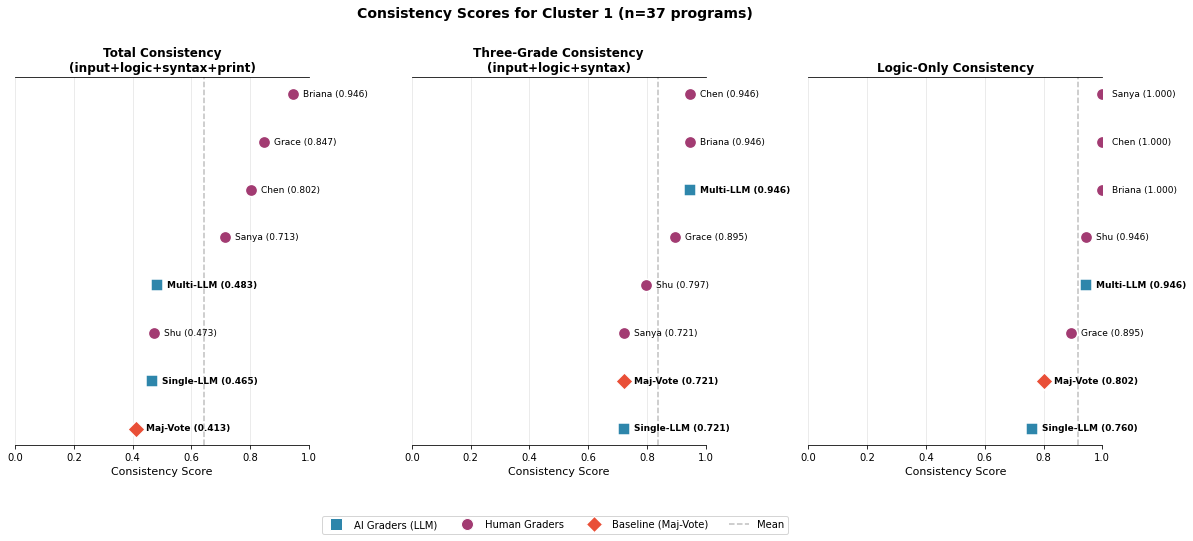

✅ Plot saved to results/analysis/consistency_scores_cluster_1.png



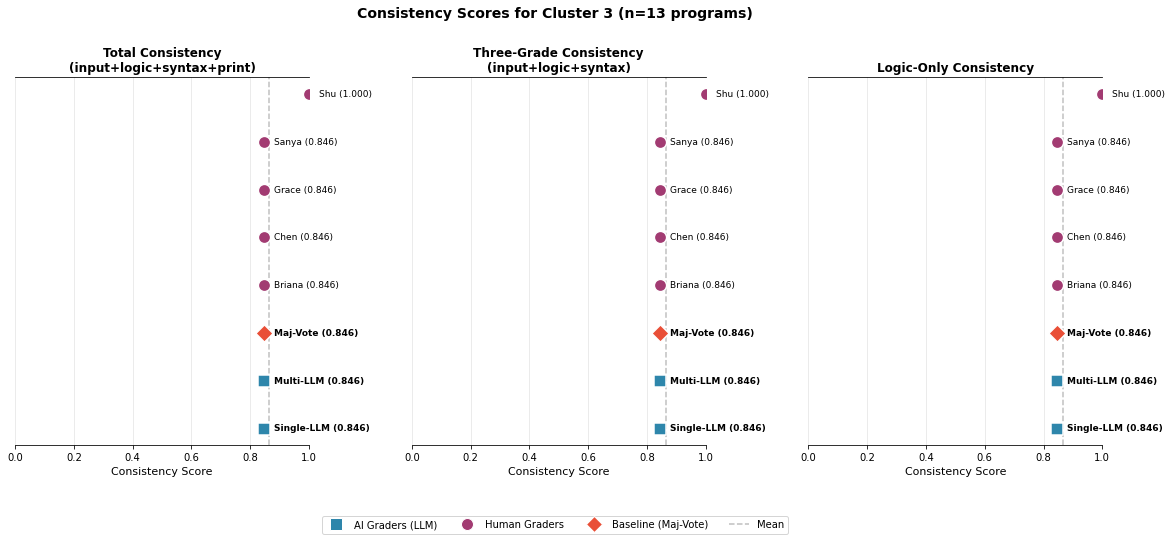

✅ Plot saved to results/analysis/consistency_scores_cluster_3.png



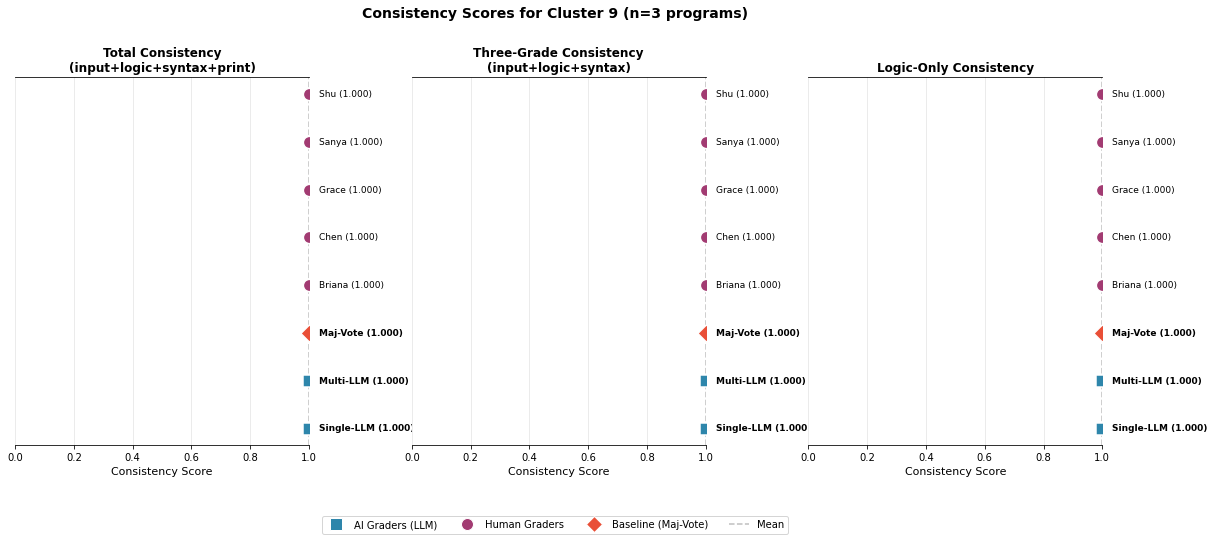

✅ Plot saved to results/analysis/consistency_scores_cluster_9.png



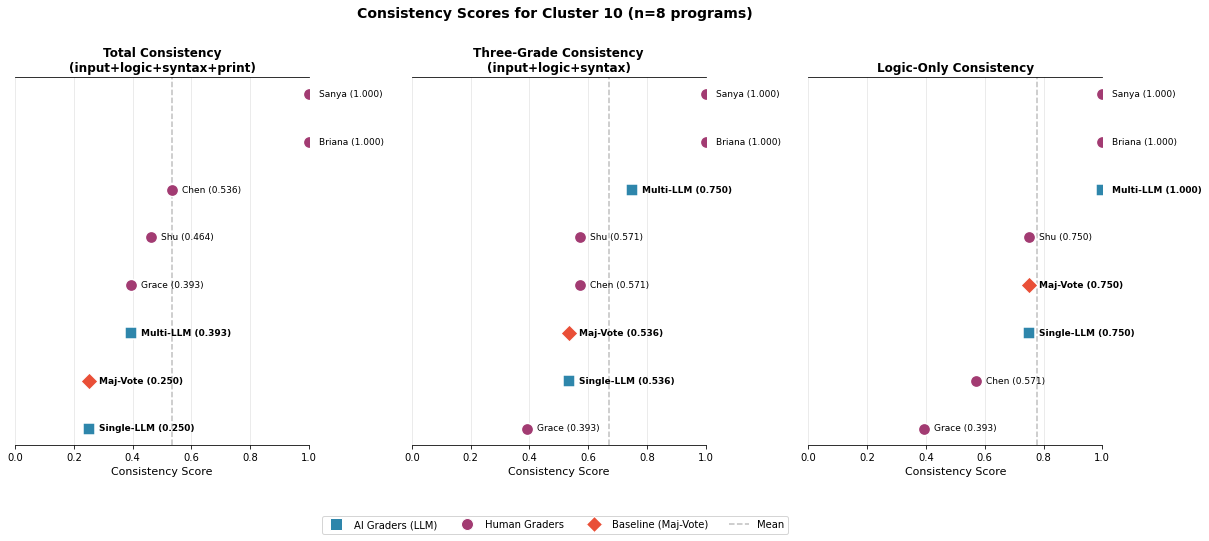

✅ Plot saved to results/analysis/consistency_scores_cluster_10.png



In [11]:
# Visualization: Create a separate plot for EACH cluster (Original Graders Only)

# Colors
ai_color = '#2E86AB'        # Blue for AI
human_color = '#A23B72'     # Purple for humans
baseline_color = '#E94F37'  # Red for baseline

def get_color_cluster(row):
    if row['grader'] == 'base':
        return baseline_color
    return ai_color if row['is_ai'] else human_color

def get_marker_cluster(row):
    if row['grader'] == 'base':
        return 'D'  # Diamond for baseline
    return 's' if row['is_ai'] else 'o'

# Create one plot for each cluster
for cluster_id in TARGET_CLUSTERS:
    cluster_results_df = cluster_results_by_id[cluster_id]
    cluster_size = cluster_df[cluster_df['cluster_id'] == cluster_id].iloc[0]['size']
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Sort by consistency score
    results_sorted_total = cluster_results_df.sort_values('total_consistency', ascending=True)
    results_sorted_three = cluster_results_df.sort_values('three_consistency', ascending=True)
    results_sorted_logic = cluster_results_df.sort_values('logic_consistency', ascending=True)
    
    # --- Plot 1: Total Consistency ---
    ax1 = axes[0]
    for i, (_, row) in enumerate(results_sorted_total.iterrows()):
        color = get_color_cluster(row)
        marker = get_marker_cluster(row)
        ax1.scatter(row['total_consistency'], i, c=color, s=150, marker=marker,
                    edgecolors='white', linewidths=1.5, zorder=3)
        ax1.annotate(f"{row['display_name']} ({row['total_consistency']:.3f})", 
                     xy=(row['total_consistency'], i),
                     xytext=(10, 0), textcoords='offset points',
                     fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                     clip_on=False)
    
    ax1.set_yticks([])
    ax1.set_xlabel('Consistency Score', fontsize=11)
    ax1.set_title('Total Consistency\n(input+logic+syntax+print)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.axvline(x=cluster_results_df['total_consistency'].mean(), color='gray', linestyle='--', alpha=0.5)
    ax1.grid(axis='x', alpha=0.3)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    # --- Plot 2: Three-Grade Consistency ---
    ax2 = axes[1]
    for i, (_, row) in enumerate(results_sorted_three.iterrows()):
        color = get_color_cluster(row)
        marker = get_marker_cluster(row)
        ax2.scatter(row['three_consistency'], i, c=color, s=150, marker=marker,
                    edgecolors='white', linewidths=1.5, zorder=3)
        ax2.annotate(f"{row['display_name']} ({row['three_consistency']:.3f})", 
                     xy=(row['three_consistency'], i),
                     xytext=(10, 0), textcoords='offset points',
                     fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                     clip_on=False)
    
    ax2.set_yticks([])
    ax2.set_xlabel('Consistency Score', fontsize=11)
    ax2.set_title('Three-Grade Consistency\n(input+logic+syntax)', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.axvline(x=cluster_results_df['three_consistency'].mean(), color='gray', linestyle='--', alpha=0.5)
    ax2.grid(axis='x', alpha=0.3)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    # --- Plot 3: Logic-Only Consistency ---
    ax3 = axes[2]
    for i, (_, row) in enumerate(results_sorted_logic.iterrows()):
        color = get_color_cluster(row)
        marker = get_marker_cluster(row)
        ax3.scatter(row['logic_consistency'], i, c=color, s=150, marker=marker,
                    edgecolors='white', linewidths=1.5, zorder=3)
        ax3.annotate(f"{row['display_name']} ({row['logic_consistency']:.3f})", 
                     xy=(row['logic_consistency'], i),
                     xytext=(10, 0), textcoords='offset points',
                     fontsize=9, va='center', fontweight='bold' if row['is_ai'] else 'normal',
                     clip_on=False)
    
    ax3.set_yticks([])
    ax3.set_xlabel('Consistency Score', fontsize=11)
    ax3.set_title('Logic-Only Consistency', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 1)
    ax3.axvline(x=cluster_results_df['logic_consistency'].mean(), color='gray', linestyle='--', alpha=0.5)
    ax3.grid(axis='x', alpha=0.3)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    
    # Add legend
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='AI Graders (LLM)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor=baseline_color, markersize=12, label='Baseline (Maj-Vote)'),
        Line2D([0], [0], color='gray', linestyle='--', alpha=0.5, label='Mean')
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.02))
    
    plt.suptitle(f'Consistency Scores for Cluster {cluster_id} (n={cluster_size} programs)', fontsize=14, fontweight='bold', y=1.02)
    plt.subplots_adjust(bottom=0.15, right=0.88, wspace=0.35)
    
    filename = f'results/analysis/consistency_scores_cluster_{cluster_id}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Plot saved to {filename}\n")

In [20]:
# Add lenient LLM grades for cluster-specific analysis
# Load lenient grading data if not already in grading_df
lenient_df = pd.read_csv('results/diag1_batch1_lenient.csv')
print(f"Loaded {len(lenient_df)} lenient grading records")

# Create a merged dataframe with lenient columns
grading_with_lenient = grading_df.copy()
for cat in CATEGORIES:
    grading_with_lenient[f'lenient_initial_{cat}'] = grading_with_lenient['student_id'].map(
        lenient_df.set_index('student_id')[f'initial_{cat}']
    )
    grading_with_lenient[f'lenient_final_{cat}'] = grading_with_lenient['student_id'].map(
        lenient_df.set_index('student_id')[f'final_{cat}']
    )

print("Lenient columns added to grading data")

Loaded 100 lenient grading records
Lenient columns added to grading data


In [21]:
# Define grade functions for lenient graders
def get_total_grade_lenient(row, grader):
    """Get total grade for lenient graders."""
    total = 0
    for cat in CATEGORIES:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
    return total

def get_three_grade_lenient(row, grader):
    """Get three-grade sum (input+logic+syntax) for lenient graders."""
    total = 0
    for cat in ['input', 'logic', 'syntax']:
        col = f"{grader}_{cat}"
        if col in row.index and pd.notna(row[col]):
            total += row[col]
        else:
            return None
    return total

def get_logic_grade_lenient(row, grader):
    """Get logic grade for lenient graders."""
    col = f"{grader}_logic"
    if col in row.index and pd.notna(row[col]):
        return row[col]
    return None

# Extended grader list including lenient
CLUSTER_GRADERS_WITH_LENIENT = ['initial', 'final', 'base', 'lenient_initial', 'lenient_final'] + HUMAN_GRADERS

CLUSTER_GRADER_NAMES = {
    'initial': 'Single-LLM',
    'final': 'Multi-LLM',
    'base': 'Maj-Vote',
    'lenient_initial': 'Lenient Single-LLM',
    'lenient_final': 'Lenient Multi-LLM',
    'briana': 'Briana',
    'chen': 'Chen',
    'grace': 'Grace',
    'sanya': 'Sanya',
    'shu': 'Shu'
}

# Calculate consistency with lenient graders FOR EACH CLUSTER SEPARATELY
cluster_results_lenient_by_id = {}

for cluster_id in TARGET_CLUSTERS:
    # Filter to just this one cluster
    single_cluster_df = cluster_df[cluster_df['cluster_id'] == cluster_id].copy()
    cluster_size = single_cluster_df.iloc[0]['size'] if len(single_cluster_df) > 0 else 0
    
    print(f"\n=== Cluster {cluster_id} (size: {cluster_size}) - Including Lenient ===")
    
    cluster_results_with_lenient = []
    
    for grader in CLUSTER_GRADERS_WITH_LENIENT:
        is_lenient = grader.startswith('lenient_')
        df_to_use = grading_with_lenient
        
        # Choose the appropriate grade function
        if is_lenient:
            total_func = get_total_grade_lenient
            three_func = get_three_grade_lenient
            logic_func = get_logic_grade_lenient
        else:
            total_func = get_total_grade
            three_func = get_three_grade
            logic_func = get_logic_grade
        
        # Total grading consistency
        total_score, total_consistent, total_pairs = calculate_consistency(
            df_to_use, single_cluster_df, grader, total_func
        )
        
        # Three-grade consistency
        three_score, three_consistent, three_pairs = calculate_consistency(
            df_to_use, single_cluster_df, grader, three_func
        )
        
        # Logic-only consistency
        logic_score, logic_consistent, logic_pairs = calculate_consistency(
            df_to_use, single_cluster_df, grader, logic_func
        )
        
        cluster_results_with_lenient.append({
            'grader': grader,
            'display_name': CLUSTER_GRADER_NAMES[grader],
            'is_ai': grader in ['initial', 'final', 'base', 'lenient_initial', 'lenient_final'],
            'is_lenient': is_lenient,
            'is_baseline': grader == 'base',
            'total_consistency': total_score,
            'total_consistent_pairs': total_consistent,
            'total_pairs': total_pairs,
            'three_consistency': three_score,
            'three_consistent_pairs': three_consistent,
            'logic_consistency': logic_score,
            'logic_consistent_pairs': logic_consistent,
        })
    
    cluster_results_lenient_df = pd.DataFrame(cluster_results_with_lenient)
    cluster_results_lenient_by_id[cluster_id] = cluster_results_lenient_df
    
    print(cluster_results_lenient_df[['display_name', 'total_consistency', 'three_consistency', 'logic_consistency', 'total_pairs']].to_string(index=False))


=== Cluster 1 (size: 37) - Including Lenient ===
      display_name  total_consistency  three_consistency  logic_consistency  total_pairs
        Single-LLM           0.465465           0.720721           0.759760          666
         Multi-LLM           0.483483           0.945946           0.945946          666
          Maj-Vote           0.412913           0.720721           0.801802          666
Lenient Single-LLM           0.651652           0.894895           0.894895          666
 Lenient Multi-LLM           0.675676           0.893393           0.893393          666
            Briana           0.945946           0.945946           1.000000          666
              Chen           0.801802           0.945946           1.000000          666
             Grace           0.846847           0.894895           0.894895          666
             Sanya           0.713213           0.720721           1.000000          666
               Shu           0.472973           0.797297    

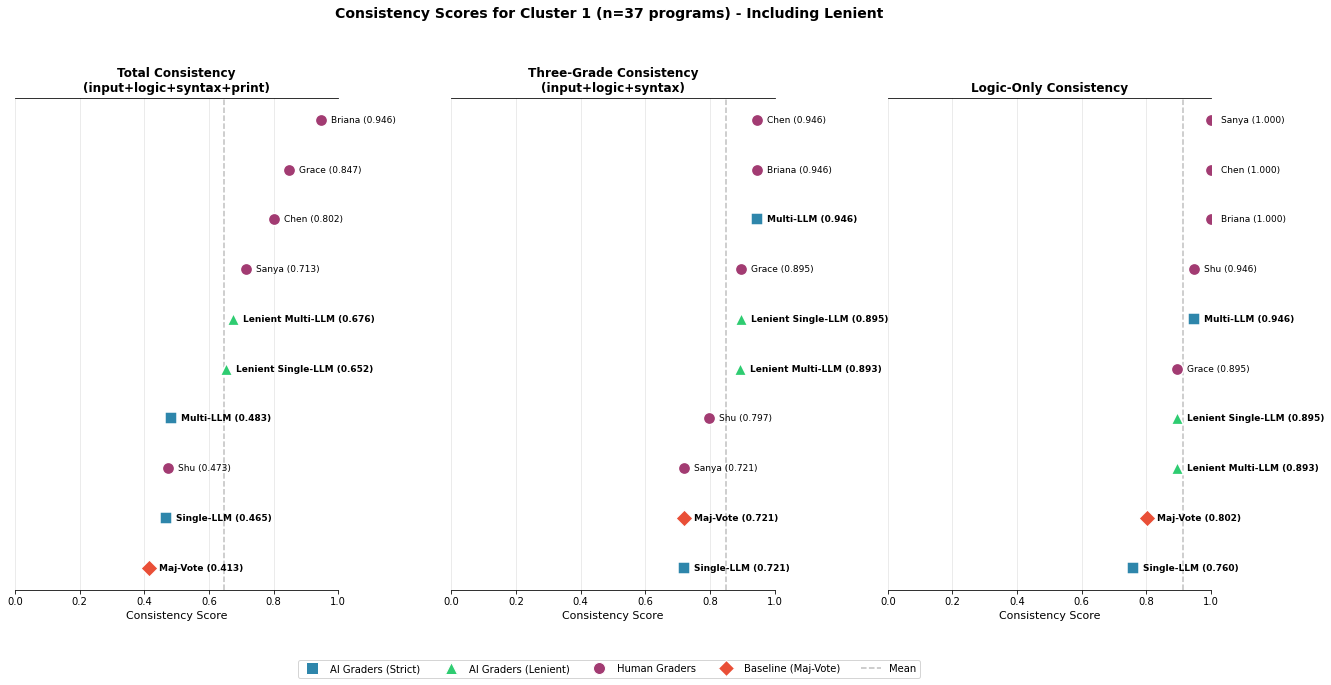

✅ Plot saved to results/analysis/consistency_scores_cluster_1_with_lenient.png



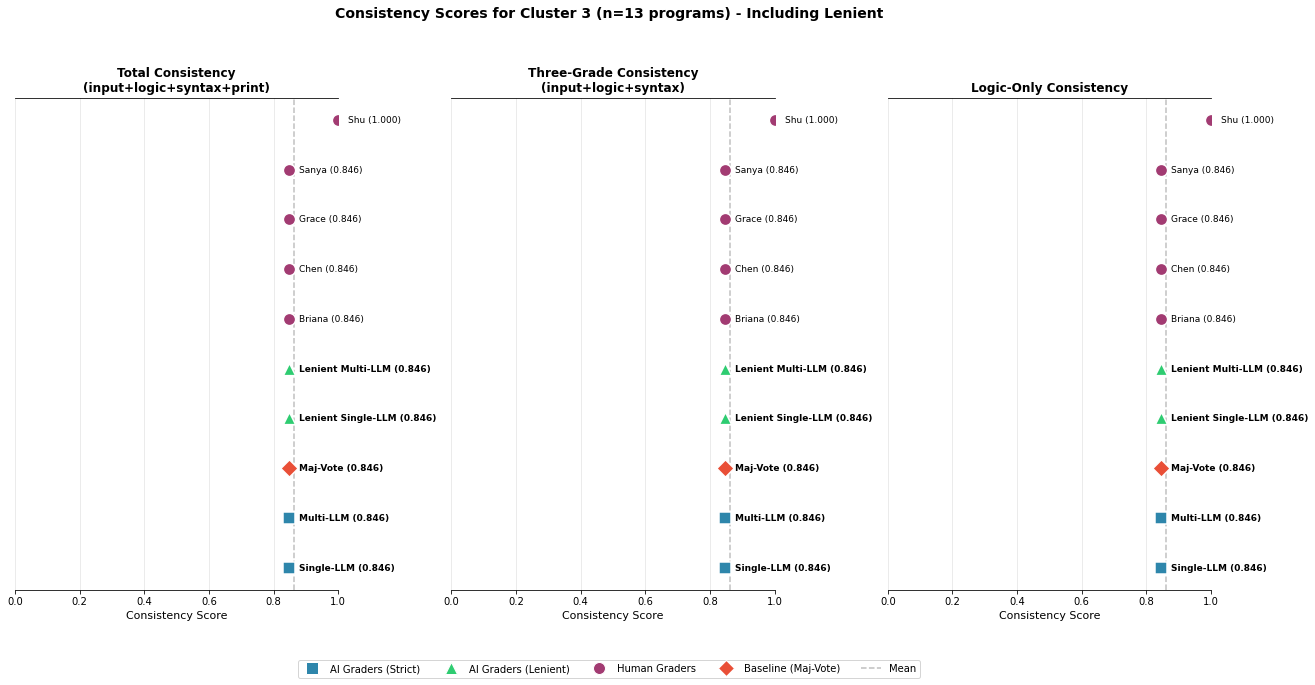

✅ Plot saved to results/analysis/consistency_scores_cluster_3_with_lenient.png



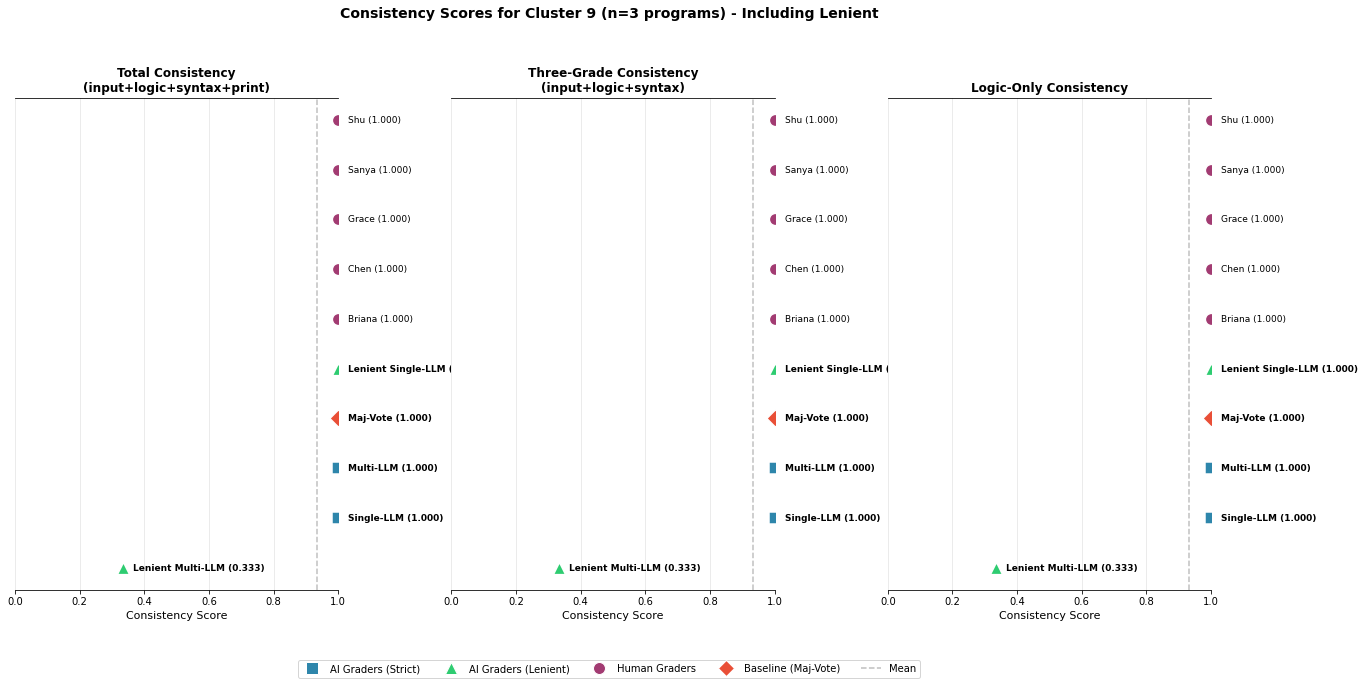

✅ Plot saved to results/analysis/consistency_scores_cluster_9_with_lenient.png



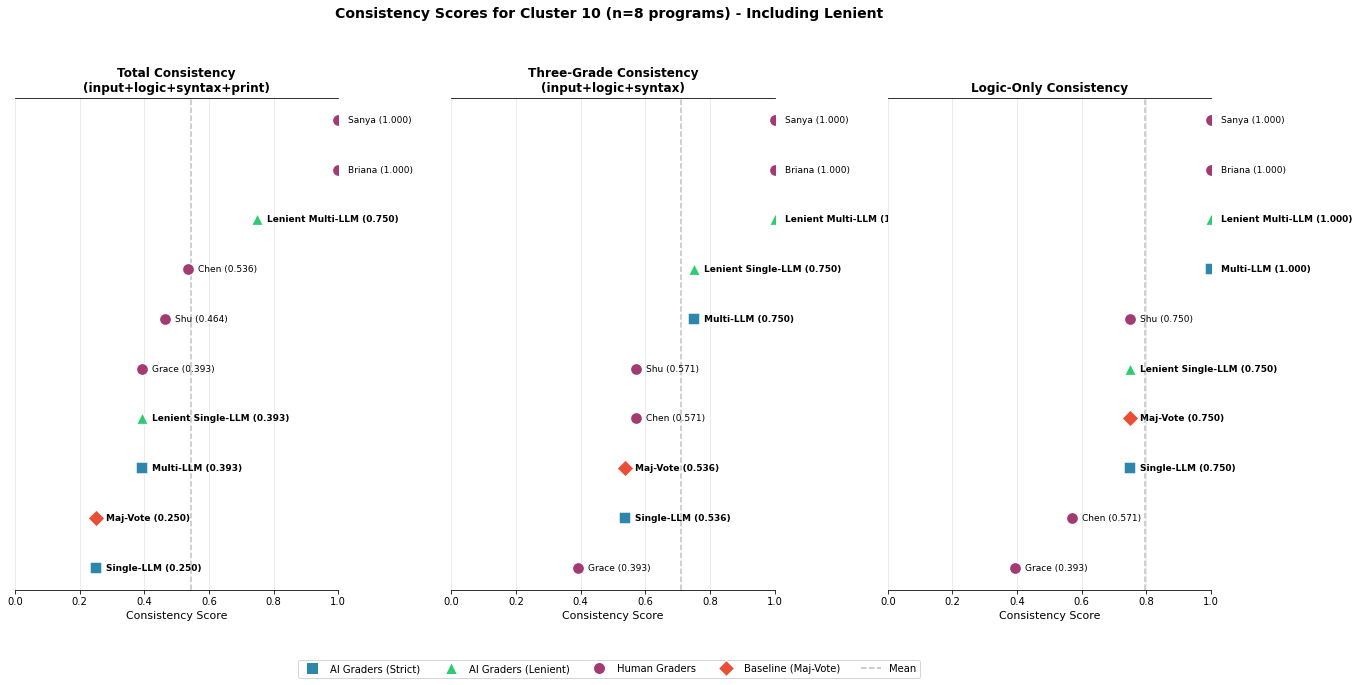

✅ Plot saved to results/analysis/consistency_scores_cluster_10_with_lenient.png



In [14]:
# Visualization: Create a separate plot for EACH cluster (Including Lenient LLMs)

# Colors
ai_color = '#2E86AB'        # Blue for strict AI
human_color = '#A23B72'     # Purple for humans
baseline_color = '#E94F37'  # Red for baseline
lenient_color = '#2ECC71'   # Green for lenient

def get_color_cluster_lenient(row):
    if row['is_baseline']:
        return baseline_color
    if row['is_lenient']:
        return lenient_color
    if row['is_ai']:
        return ai_color
    return human_color

def get_marker_cluster_lenient(row):
    if row['is_baseline']:
        return 'D'  # Diamond for baseline
    if row['is_lenient']:
        return '^'  # Triangle for lenient
    if row['is_ai']:
        return 's'  # Square for strict AI
    return 'o'  # Circle for humans

# Create one plot for each cluster
for cluster_id in TARGET_CLUSTERS:
    cluster_results_lenient_df = cluster_results_lenient_by_id[cluster_id]
    cluster_size = cluster_df[cluster_df['cluster_id'] == cluster_id].iloc[0]['size']
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 9))
    
    # Sort by consistency score
    results_sorted_total = cluster_results_lenient_df.sort_values('total_consistency', ascending=True)
    results_sorted_three = cluster_results_lenient_df.sort_values('three_consistency', ascending=True)
    results_sorted_logic = cluster_results_lenient_df.sort_values('logic_consistency', ascending=True)
    
    # --- Plot 1: Total Consistency ---
    ax1 = axes[0]
    for i, (_, row) in enumerate(results_sorted_total.iterrows()):
        color = get_color_cluster_lenient(row)
        marker = get_marker_cluster_lenient(row)
        ax1.scatter(row['total_consistency'], i, c=color, s=150, marker=marker,
                    edgecolors='white', linewidths=1.5, zorder=3)
        fontweight = 'bold' if row['is_ai'] else 'normal'
        ax1.annotate(f"{row['display_name']} ({row['total_consistency']:.3f})", 
                     xy=(row['total_consistency'], i),
                     xytext=(10, 0), textcoords='offset points',
                     fontsize=9, va='center', fontweight=fontweight,
                     clip_on=False)
    
    ax1.set_yticks([])
    ax1.set_xlabel('Consistency Score', fontsize=11)
    ax1.set_title('Total Consistency\n(input+logic+syntax+print)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.axvline(x=cluster_results_lenient_df['total_consistency'].mean(), color='gray', linestyle='--', alpha=0.5)
    ax1.grid(axis='x', alpha=0.3)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    
    # --- Plot 2: Three-Grade Consistency ---
    ax2 = axes[1]
    for i, (_, row) in enumerate(results_sorted_three.iterrows()):
        color = get_color_cluster_lenient(row)
        marker = get_marker_cluster_lenient(row)
        ax2.scatter(row['three_consistency'], i, c=color, s=150, marker=marker,
                    edgecolors='white', linewidths=1.5, zorder=3)
        fontweight = 'bold' if row['is_ai'] else 'normal'
        ax2.annotate(f"{row['display_name']} ({row['three_consistency']:.3f})", 
                     xy=(row['three_consistency'], i),
                     xytext=(10, 0), textcoords='offset points',
                     fontsize=9, va='center', fontweight=fontweight,
                     clip_on=False)
    
    ax2.set_yticks([])
    ax2.set_xlabel('Consistency Score', fontsize=11)
    ax2.set_title('Three-Grade Consistency\n(input+logic+syntax)', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.axvline(x=cluster_results_lenient_df['three_consistency'].mean(), color='gray', linestyle='--', alpha=0.5)
    ax2.grid(axis='x', alpha=0.3)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    # --- Plot 3: Logic-Only Consistency ---
    ax3 = axes[2]
    for i, (_, row) in enumerate(results_sorted_logic.iterrows()):
        color = get_color_cluster_lenient(row)
        marker = get_marker_cluster_lenient(row)
        ax3.scatter(row['logic_consistency'], i, c=color, s=150, marker=marker,
                    edgecolors='white', linewidths=1.5, zorder=3)
        fontweight = 'bold' if row['is_ai'] else 'normal'
        ax3.annotate(f"{row['display_name']} ({row['logic_consistency']:.3f})", 
                     xy=(row['logic_consistency'], i),
                     xytext=(10, 0), textcoords='offset points',
                     fontsize=9, va='center', fontweight=fontweight,
                     clip_on=False)
    
    ax3.set_yticks([])
    ax3.set_xlabel('Consistency Score', fontsize=11)
    ax3.set_title('Logic-Only Consistency', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 1)
    ax3.axvline(x=cluster_results_lenient_df['logic_consistency'].mean(), color='gray', linestyle='--', alpha=0.5)
    ax3.grid(axis='x', alpha=0.3)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    
    # Add legend
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', markerfacecolor=ai_color, markersize=12, label='AI Graders (Strict)'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor=lenient_color, markersize=12, label='AI Graders (Lenient)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=human_color, markersize=12, label='Human Graders'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor=baseline_color, markersize=12, label='Baseline (Maj-Vote)'),
        Line2D([0], [0], color='gray', linestyle='--', alpha=0.5, label='Mean')
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.02))
    
    plt.suptitle(f'Consistency Scores for Cluster {cluster_id} (n={cluster_size} programs) - Including Lenient', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.subplots_adjust(bottom=0.12, right=0.88, wspace=0.35)
    
    filename = f'results/analysis/consistency_scores_cluster_{cluster_id}_with_lenient.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Plot saved to {filename}\n")

## 14. Cluster vs Overall Consistency Comparison

Compare cluster-specific consistency scores against overall (reference) consistency scores for Single-LLM and Multi-LLM graders, both strict and lenient modes.

**Visualization shows:**
- Solid markers: Cluster-specific consistency scores
- Dashed horizontal lines: Overall (reference) consistency scores across all clusters

**Clusters analyzed:** 1, 3, 8

In [24]:
# Define clusters for this comparison
COMPARISON_CLUSTERS = [1, 3, 10]

# Get overall (reference) consistency scores from ca_df and lenient_df_results
# These are the scores across ALL clusters
ref_single_strict = ca_df[ca_df['grader'] == 'initial'].iloc[0]
ref_multi_strict = ca_df[ca_df['grader'] == 'final'].iloc[0]
ref_single_lenient = lenient_df_results[lenient_df_results['grader'] == 'lenient_initial'].iloc[0]
ref_multi_lenient = lenient_df_results[lenient_df_results['grader'] == 'lenient_final'].iloc[0]

print("=== REFERENCE SCORES (Overall across all clusters) ===")
print(f"{'Grader':<20} {'Total':>10} {'Three':>10} {'Logic':>10}")
print("-" * 55)
print(f"{'Single-LLM (Strict)':<20} {ref_single_strict['consistency_total']:>10.3f} {ref_single_strict['consistency_three']:>10.3f} {ref_single_strict['consistency_logic']:>10.3f}")
print(f"{'Multi-LLM (Strict)':<20} {ref_multi_strict['consistency_total']:>10.3f} {ref_multi_strict['consistency_three']:>10.3f} {ref_multi_strict['consistency_logic']:>10.3f}")
print(f"{'Single-LLM (Lenient)':<20} {ref_single_lenient['consistency_total']:>10.3f} {ref_single_lenient['consistency_three']:>10.3f} {ref_single_lenient['consistency_logic']:>10.3f}")
print(f"{'Multi-LLM (Lenient)':<20} {ref_multi_lenient['consistency_total']:>10.3f} {ref_multi_lenient['consistency_three']:>10.3f} {ref_multi_lenient['consistency_logic']:>10.3f}")

=== REFERENCE SCORES (Overall across all clusters) ===
Grader                    Total      Three      Logic
-------------------------------------------------------
Single-LLM (Strict)       0.497      0.729      0.770
Multi-LLM (Strict)        0.516      0.926      0.935
Single-LLM (Lenient)      0.659      0.881      0.882
Multi-LLM (Lenient)       0.693      0.887      0.889


In [25]:
# Calculate cluster-specific scores for clusters 1, 3, 8
# Graders: initial (Single-LLM), final (Multi-LLM), lenient_initial, lenient_final

FOCUS_GRADERS = ['initial', 'final', 'lenient_initial', 'lenient_final']
FOCUS_GRADER_NAMES = {
    'initial': 'Single-LLM (Strict)',
    'final': 'Multi-LLM (Strict)',
    'lenient_initial': 'Single-LLM (Lenient)',
    'lenient_final': 'Multi-LLM (Lenient)'
}

# Calculate scores for each cluster
cluster_comparison_results = {}

for cluster_id in COMPARISON_CLUSTERS:
    # Filter to just this one cluster
    single_cluster_df = cluster_df[cluster_df['cluster_id'] == cluster_id].copy()
    cluster_size = single_cluster_df.iloc[0]['size'] if len(single_cluster_df) > 0 else 0
    
    print(f"\n=== Cluster {cluster_id} (size: {cluster_size}) ===")
    
    cluster_scores = {}
    for grader in FOCUS_GRADERS:
        is_lenient = grader.startswith('lenient_')
        
        # Choose the appropriate grade function and dataframe
        if is_lenient:
            total_func = get_total_grade_lenient
            three_func = get_three_grade_lenient
            logic_func = get_logic_grade_lenient
            df_to_use = grading_with_lenient
        else:
            total_func = get_total_grade
            three_func = get_three_grade
            logic_func = get_logic_grade
            df_to_use = grading_df
        
        # Calculate consistency for this cluster
        total_score, _, _ = calculate_consistency(df_to_use, single_cluster_df, grader, total_func)
        three_score, _, _ = calculate_consistency(df_to_use, single_cluster_df, grader, three_func)
        logic_score, _, _ = calculate_consistency(df_to_use, single_cluster_df, grader, logic_func)
        
        cluster_scores[grader] = {
            'total': total_score,
            'three': three_score,
            'logic': logic_score
        }
        
        print(f"  {FOCUS_GRADER_NAMES[grader]:<25} Total: {total_score:.3f}, Three: {three_score:.3f}, Logic: {logic_score:.3f}")
    
    cluster_comparison_results[cluster_id] = {
        'size': cluster_size,
        'scores': cluster_scores
    }


=== Cluster 1 (size: 37) ===
  Single-LLM (Strict)       Total: 0.465, Three: 0.721, Logic: 0.760
  Multi-LLM (Strict)        Total: 0.483, Three: 0.946, Logic: 0.946
  Single-LLM (Lenient)      Total: 0.652, Three: 0.895, Logic: 0.895
  Multi-LLM (Lenient)       Total: 0.676, Three: 0.893, Logic: 0.893

=== Cluster 3 (size: 13) ===
  Single-LLM (Strict)       Total: 0.846, Three: 0.846, Logic: 0.846
  Multi-LLM (Strict)        Total: 0.846, Three: 0.846, Logic: 0.846
  Single-LLM (Lenient)      Total: 0.846, Three: 0.846, Logic: 0.846
  Multi-LLM (Lenient)       Total: 0.846, Three: 0.846, Logic: 0.846

=== Cluster 10 (size: 8) ===
  Single-LLM (Strict)       Total: 0.250, Three: 0.536, Logic: 0.750
  Multi-LLM (Strict)        Total: 0.393, Three: 0.750, Logic: 1.000
  Single-LLM (Lenient)      Total: 0.393, Three: 0.750, Logic: 0.750
  Multi-LLM (Lenient)       Total: 0.750, Three: 1.000, Logic: 1.000


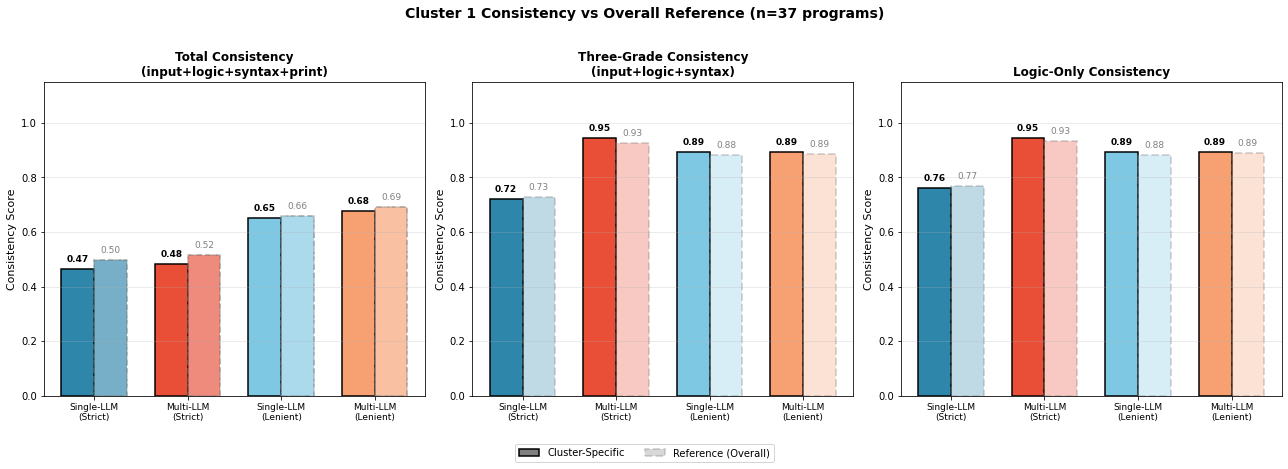

✅ Saved: results/analysis/cluster_1_vs_reference.png



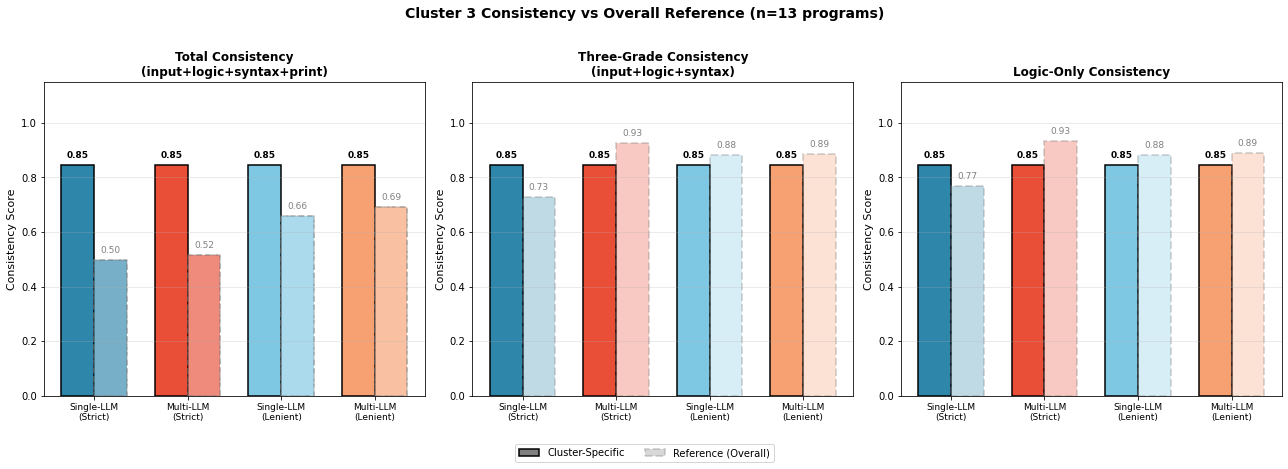

✅ Saved: results/analysis/cluster_3_vs_reference.png



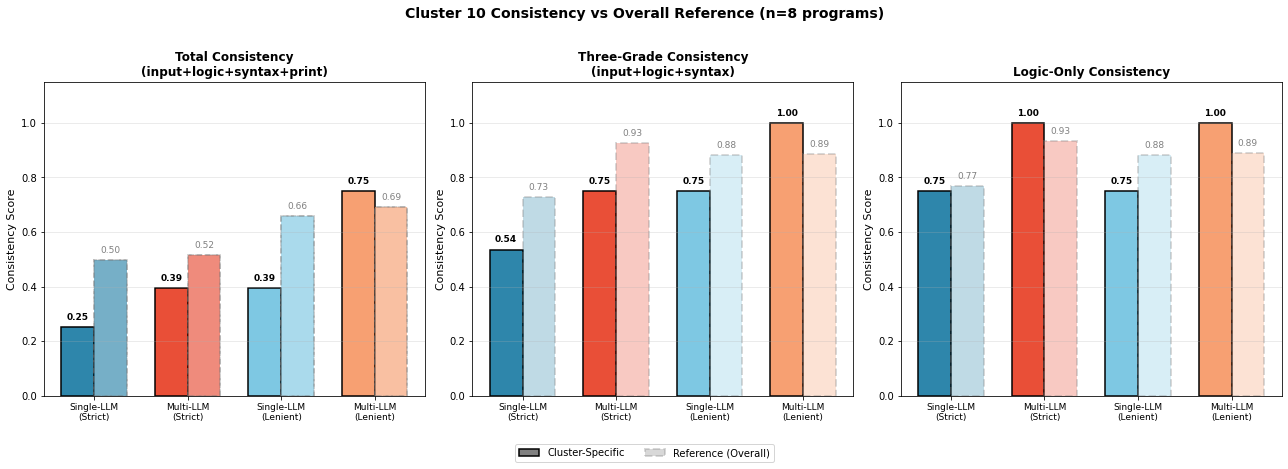

✅ Saved: results/analysis/cluster_10_vs_reference.png



In [26]:
# Create visualization for each cluster: Cluster scores vs Reference scores
# One plot per cluster, showing Total, Three, and Logic consistency

# Colors for graders
single_strict_color = '#2E86AB'   # Blue
multi_strict_color = '#E94F37'    # Red  
single_lenient_color = '#7EC8E3'  # Light blue
multi_lenient_color = '#F7A072'   # Light red/orange

for cluster_id in COMPARISON_CLUSTERS:
    cluster_data = cluster_comparison_results[cluster_id]
    cluster_size = cluster_data['size']
    cluster_scores = cluster_data['scores']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Grader labels for x-axis
    grader_labels = ['Single-LLM\n(Strict)', 'Multi-LLM\n(Strict)', 'Single-LLM\n(Lenient)', 'Multi-LLM\n(Lenient)']
    grader_keys = ['initial', 'final', 'lenient_initial', 'lenient_final']
    x_pos = np.arange(len(grader_labels))
    
    # Colors for each grader
    colors = [single_strict_color, multi_strict_color, single_lenient_color, multi_lenient_color]
    
    # Reference scores (overall)
    ref_scores = {
        'initial': {'total': ref_single_strict['consistency_total'], 
                    'three': ref_single_strict['consistency_three'], 
                    'logic': ref_single_strict['consistency_logic']},
        'final': {'total': ref_multi_strict['consistency_total'], 
                  'three': ref_multi_strict['consistency_three'], 
                  'logic': ref_multi_strict['consistency_logic']},
        'lenient_initial': {'total': ref_single_lenient['consistency_total'], 
                            'three': ref_single_lenient['consistency_three'], 
                            'logic': ref_single_lenient['consistency_logic']},
        'lenient_final': {'total': ref_multi_lenient['consistency_total'], 
                          'three': ref_multi_lenient['consistency_three'], 
                          'logic': ref_multi_lenient['consistency_logic']}
    }
    
    # --- Plot 1: Total Consistency ---
    ax1 = axes[0]
    bar_width = 0.35
    
    # Cluster-specific bars
    cluster_vals = [cluster_scores[g]['total'] for g in grader_keys]
    bars1 = ax1.bar(x_pos - bar_width/2, cluster_vals, bar_width, 
                    color=colors, edgecolor='black', linewidth=1.5, label='Cluster-Specific')
    
    # Reference bars (lighter, dashed outline)
    ref_vals = [ref_scores[g]['total'] for g in grader_keys]
    bars2 = ax1.bar(x_pos + bar_width/2, ref_vals, bar_width, 
                    color=[c + '40' for c in colors],  # Won't work, use alpha instead
                    edgecolor='gray', linewidth=1.5, linestyle='--', alpha=0.5, label='Reference (Overall)')
    
    # Redraw reference bars with correct styling
    for i, (x, ref_val, color) in enumerate(zip(x_pos, ref_vals, colors)):
        ax1.bar(x + bar_width/2, ref_val, bar_width, 
                color=color, alpha=0.3, edgecolor='gray', linewidth=2, linestyle='--')
    
    # Add value labels
    for i, (cv, rv) in enumerate(zip(cluster_vals, ref_vals)):
        ax1.text(x_pos[i] - bar_width/2, cv + 0.02, f'{cv:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        ax1.text(x_pos[i] + bar_width/2, rv + 0.02, f'{rv:.2f}', ha='center', va='bottom', fontsize=9, color='gray')
    
    ax1.set_ylabel('Consistency Score', fontsize=11)
    ax1.set_title('Total Consistency\n(input+logic+syntax+print)', fontsize=12, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(grader_labels, fontsize=9)
    ax1.set_ylim(0, 1.15)
    ax1.grid(axis='y', alpha=0.3)
    
    # --- Plot 2: Three-Grade Consistency ---
    ax2 = axes[1]
    
    cluster_vals = [cluster_scores[g]['three'] for g in grader_keys]
    ref_vals = [ref_scores[g]['three'] for g in grader_keys]
    
    # Cluster-specific bars
    for i, (x, cv, color) in enumerate(zip(x_pos, cluster_vals, colors)):
        ax2.bar(x - bar_width/2, cv, bar_width, color=color, edgecolor='black', linewidth=1.5)
    
    # Reference bars
    for i, (x, rv, color) in enumerate(zip(x_pos, ref_vals, colors)):
        ax2.bar(x + bar_width/2, rv, bar_width, color=color, alpha=0.3, edgecolor='gray', linewidth=2, linestyle='--')
    
    # Add value labels
    for i, (cv, rv) in enumerate(zip(cluster_vals, ref_vals)):
        ax2.text(x_pos[i] - bar_width/2, cv + 0.02, f'{cv:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        ax2.text(x_pos[i] + bar_width/2, rv + 0.02, f'{rv:.2f}', ha='center', va='bottom', fontsize=9, color='gray')
    
    ax2.set_ylabel('Consistency Score', fontsize=11)
    ax2.set_title('Three-Grade Consistency\n(input+logic+syntax)', fontsize=12, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(grader_labels, fontsize=9)
    ax2.set_ylim(0, 1.15)
    ax2.grid(axis='y', alpha=0.3)
    
    # --- Plot 3: Logic-Only Consistency ---
    ax3 = axes[2]
    
    cluster_vals = [cluster_scores[g]['logic'] for g in grader_keys]
    ref_vals = [ref_scores[g]['logic'] for g in grader_keys]
    
    # Cluster-specific bars
    for i, (x, cv, color) in enumerate(zip(x_pos, cluster_vals, colors)):
        ax3.bar(x - bar_width/2, cv, bar_width, color=color, edgecolor='black', linewidth=1.5)
    
    # Reference bars
    for i, (x, rv, color) in enumerate(zip(x_pos, ref_vals, colors)):
        ax3.bar(x + bar_width/2, rv, bar_width, color=color, alpha=0.3, edgecolor='gray', linewidth=2, linestyle='--')
    
    # Add value labels
    for i, (cv, rv) in enumerate(zip(cluster_vals, ref_vals)):
        ax3.text(x_pos[i] - bar_width/2, cv + 0.02, f'{cv:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        ax3.text(x_pos[i] + bar_width/2, rv + 0.02, f'{rv:.2f}', ha='center', va='bottom', fontsize=9, color='gray')
    
    ax3.set_ylabel('Consistency Score', fontsize=11)
    ax3.set_title('Logic-Only Consistency', fontsize=12, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(grader_labels, fontsize=9)
    ax3.set_ylim(0, 1.15)
    ax3.grid(axis='y', alpha=0.3)
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, facecolor='gray', edgecolor='black', linewidth=1.5, label='Cluster-Specific'),
        plt.Rectangle((0,0), 1, 1, facecolor='gray', alpha=0.3, edgecolor='gray', linewidth=2, linestyle='--', label='Reference (Overall)'),
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.02), fontsize=10)
    
    plt.suptitle(f'Cluster {cluster_id} Consistency vs Overall Reference (n={cluster_size} programs)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    
    filename = f'results/analysis/cluster_{cluster_id}_vs_reference.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {filename}\n")

In [27]:
# Summary table: Cluster scores vs Reference scores
print("=" * 100)
print("SUMMARY: Cluster Consistency vs Overall Reference (Total Grade)")
print("=" * 100)
print(f"\n{'Cluster':<12} {'Single-Strict':<16} {'Multi-Strict':<16} {'Single-Lenient':<16} {'Multi-Lenient':<16}")
print(f"{'':12} {'Cluster/Ref':<16} {'Cluster/Ref':<16} {'Cluster/Ref':<16} {'Cluster/Ref':<16}")
print("-" * 100)

for cluster_id in COMPARISON_CLUSTERS:
    cluster_scores = cluster_comparison_results[cluster_id]['scores']
    cluster_size = cluster_comparison_results[cluster_id]['size']
    
    cs_ss = cluster_scores['initial']['total']
    cs_ms = cluster_scores['final']['total']
    cs_sl = cluster_scores['lenient_initial']['total']
    cs_ml = cluster_scores['lenient_final']['total']
    
    ref_ss = ref_single_strict['consistency_total']
    ref_ms = ref_multi_strict['consistency_total']
    ref_sl = ref_single_lenient['consistency_total']
    ref_ml = ref_multi_lenient['consistency_total']
    
    print(f"Cluster {cluster_id:<4} (n={cluster_size:<2}) "
          f"{cs_ss:.2f}/{ref_ss:.2f}         {cs_ms:.2f}/{ref_ms:.2f}         "
          f"{cs_sl:.2f}/{ref_sl:.2f}         {cs_ml:.2f}/{ref_ml:.2f}")

print("\n" + "=" * 100)
print("Δ = Cluster - Reference (positive = cluster has higher consistency)")
print("=" * 100)

for cluster_id in COMPARISON_CLUSTERS:
    cluster_scores = cluster_comparison_results[cluster_id]['scores']
    
    delta_ss = cluster_scores['initial']['total'] - ref_single_strict['consistency_total']
    delta_ms = cluster_scores['final']['total'] - ref_multi_strict['consistency_total']
    delta_sl = cluster_scores['lenient_initial']['total'] - ref_single_lenient['consistency_total']
    delta_ml = cluster_scores['lenient_final']['total'] - ref_multi_lenient['consistency_total']
    
    print(f"Cluster {cluster_id}:    "
          f"Δ={delta_ss:+.3f}          Δ={delta_ms:+.3f}          "
          f"Δ={delta_sl:+.3f}          Δ={delta_ml:+.3f}")

SUMMARY: Cluster Consistency vs Overall Reference (Total Grade)

Cluster      Single-Strict    Multi-Strict     Single-Lenient   Multi-Lenient   
             Cluster/Ref      Cluster/Ref      Cluster/Ref      Cluster/Ref     
----------------------------------------------------------------------------------------------------
Cluster 1    (n=37) 0.47/0.50         0.48/0.52         0.65/0.66         0.68/0.69
Cluster 3    (n=13) 0.85/0.50         0.85/0.52         0.85/0.66         0.85/0.69
Cluster 10   (n=8 ) 0.25/0.50         0.39/0.52         0.39/0.66         0.75/0.69

Δ = Cluster - Reference (positive = cluster has higher consistency)
Cluster 1:    Δ=-0.031          Δ=-0.033          Δ=-0.008          Δ=-0.017
Cluster 3:    Δ=+0.349          Δ=+0.330          Δ=+0.187          Δ=+0.153
Cluster 10:    Δ=-0.247          Δ=-0.123          Δ=-0.267          Δ=+0.057


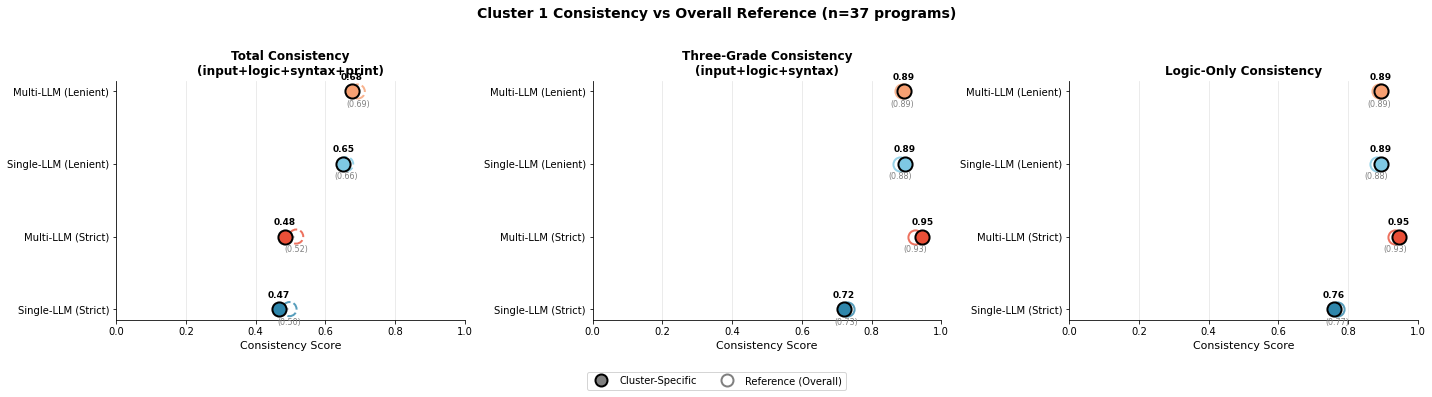

✅ Saved: results/analysis/cluster_1_vs_reference_dotplot.png



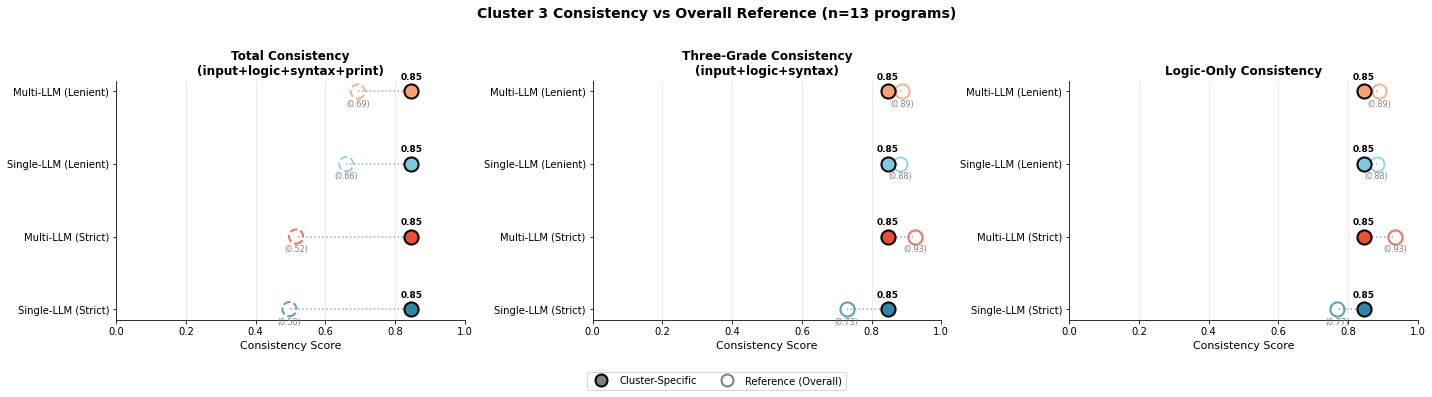

✅ Saved: results/analysis/cluster_3_vs_reference_dotplot.png



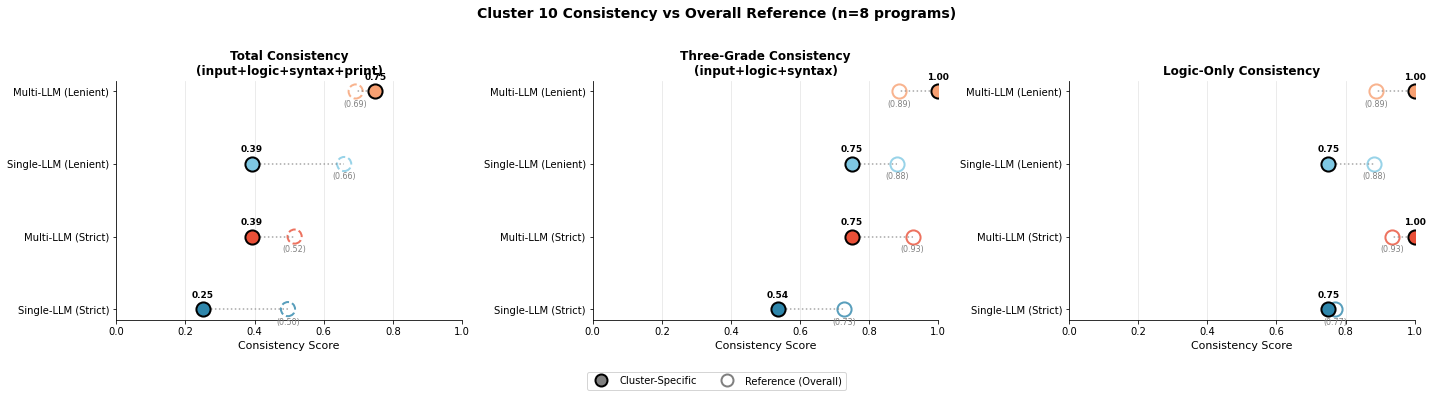

✅ Saved: results/analysis/cluster_10_vs_reference_dotplot.png



In [28]:
# Alternative Visualization: Dot Plot (consistency on x-axis, grader on y-axis)
# Similar style to consistency_scores.png

# Colors for graders
single_strict_color = '#2E86AB'   # Blue
multi_strict_color = '#E94F37'    # Red  
single_lenient_color = '#7EC8E3'  # Light blue
multi_lenient_color = '#F7A072'   # Light red/orange

grader_labels = ['Single-LLM (Strict)', 'Multi-LLM (Strict)', 'Single-LLM (Lenient)', 'Multi-LLM (Lenient)']
grader_keys = ['initial', 'final', 'lenient_initial', 'lenient_final']
colors = [single_strict_color, multi_strict_color, single_lenient_color, multi_lenient_color]

# Reference scores (overall)
ref_scores = {
    'initial': {'total': ref_single_strict['consistency_total'], 
                'three': ref_single_strict['consistency_three'], 
                'logic': ref_single_strict['consistency_logic']},
    'final': {'total': ref_multi_strict['consistency_total'], 
              'three': ref_multi_strict['consistency_three'], 
              'logic': ref_multi_strict['consistency_logic']},
    'lenient_initial': {'total': ref_single_lenient['consistency_total'], 
                        'three': ref_single_lenient['consistency_three'], 
                        'logic': ref_single_lenient['consistency_logic']},
    'lenient_final': {'total': ref_multi_lenient['consistency_total'], 
                      'three': ref_multi_lenient['consistency_three'], 
                      'logic': ref_multi_lenient['consistency_logic']}
}

for cluster_id in COMPARISON_CLUSTERS:
    cluster_data = cluster_comparison_results[cluster_id]
    cluster_size = cluster_data['size']
    cluster_scores = cluster_data['scores']
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    y_pos = np.arange(len(grader_labels))
    
    # --- Plot 1: Total Consistency ---
    ax1 = axes[0]
    
    for i, (grader_key, label, color) in enumerate(zip(grader_keys, grader_labels, colors)):
        cluster_val = cluster_scores[grader_key]['total']
        ref_val = ref_scores[grader_key]['total']
        
        # Cluster-specific score (solid marker)
        ax1.scatter(cluster_val, i, c=color, s=200, marker='o', 
                    edgecolors='black', linewidths=2, zorder=3, label='Cluster' if i == 0 else '')
        
        # Reference score (hollow marker with dashed edge)
        ax1.scatter(ref_val, i, c='white', s=200, marker='o', 
                    edgecolors=color, linewidths=2, linestyle='--', zorder=2, alpha=0.8)
        
        # Connect with a line to show difference
        ax1.plot([cluster_val, ref_val], [i, i], color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
        
        # Add value labels
        ax1.annotate(f'{cluster_val:.2f}', xy=(cluster_val, i), xytext=(0, 12), 
                     textcoords='offset points', ha='center', fontsize=9, fontweight='bold')
        ax1.annotate(f'({ref_val:.2f})', xy=(ref_val, i), xytext=(0, -15), 
                     textcoords='offset points', ha='center', fontsize=8, color='gray')
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(grader_labels, fontsize=10)
    ax1.set_xlabel('Consistency Score', fontsize=11)
    ax1.set_title('Total Consistency\n(input+logic+syntax+print)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    # --- Plot 2: Three-Grade Consistency ---
    ax2 = axes[1]
    
    for i, (grader_key, label, color) in enumerate(zip(grader_keys, grader_labels, colors)):
        cluster_val = cluster_scores[grader_key]['three']
        ref_val = ref_scores[grader_key]['three']
        
        ax2.scatter(cluster_val, i, c=color, s=200, marker='o', 
                    edgecolors='black', linewidths=2, zorder=3)
        ax2.scatter(ref_val, i, c='white', s=200, marker='o', 
                    edgecolors=color, linewidths=2, zorder=2, alpha=0.8)
        ax2.plot([cluster_val, ref_val], [i, i], color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
        
        ax2.annotate(f'{cluster_val:.2f}', xy=(cluster_val, i), xytext=(0, 12), 
                     textcoords='offset points', ha='center', fontsize=9, fontweight='bold')
        ax2.annotate(f'({ref_val:.2f})', xy=(ref_val, i), xytext=(0, -15), 
                     textcoords='offset points', ha='center', fontsize=8, color='gray')
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(grader_labels, fontsize=10)
    ax2.set_xlabel('Consistency Score', fontsize=11)
    ax2.set_title('Three-Grade Consistency\n(input+logic+syntax)', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.grid(axis='x', alpha=0.3)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    # --- Plot 3: Logic-Only Consistency ---
    ax3 = axes[2]
    
    for i, (grader_key, label, color) in enumerate(zip(grader_keys, grader_labels, colors)):
        cluster_val = cluster_scores[grader_key]['logic']
        ref_val = ref_scores[grader_key]['logic']
        
        ax3.scatter(cluster_val, i, c=color, s=200, marker='o', 
                    edgecolors='black', linewidths=2, zorder=3)
        ax3.scatter(ref_val, i, c='white', s=200, marker='o', 
                    edgecolors=color, linewidths=2, zorder=2, alpha=0.8)
        ax3.plot([cluster_val, ref_val], [i, i], color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
        
        ax3.annotate(f'{cluster_val:.2f}', xy=(cluster_val, i), xytext=(0, 12), 
                     textcoords='offset points', ha='center', fontsize=9, fontweight='bold')
        ax3.annotate(f'({ref_val:.2f})', xy=(ref_val, i), xytext=(0, -15), 
                     textcoords='offset points', ha='center', fontsize=8, color='gray')
    
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(grader_labels, fontsize=10)
    ax3.set_xlabel('Consistency Score', fontsize=11)
    ax3.set_title('Logic-Only Consistency', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 1)
    ax3.grid(axis='x', alpha=0.3)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    
    # Add legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='black',
               markersize=12, markeredgewidth=2, label='Cluster-Specific'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markeredgecolor='gray',
               markersize=12, markeredgewidth=2, label='Reference (Overall)'),
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.02), fontsize=10)
    
    plt.suptitle(f'Cluster {cluster_id} Consistency vs Overall Reference (n={cluster_size} programs)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    filename = f'results/analysis/cluster_{cluster_id}_vs_reference_dotplot.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {filename}\n")